In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import json
import random
import seaborn as sns
import re

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

# ### Scikit-Learn ###
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skmetrics

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
rdm_th = 0
corr_th = 0.85

nlp_spanish = spacy.load("es_core_news_sm")

random.seed(rdm_th)

In [3]:
with open('../LableniBotConfig/avoid_words.json', encoding='utf-8') as fh:
    avoid_words_list = json.load(fh)

tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [4]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_word(word):
    special_characters = ["?", "¿", "!", "¡", ".", ","]
    w_new = word.lower()
    for s_c in special_characters:
        w_new = w_new.replace(s_c, "")
        
    return w_new

def avoid_words_func(text):
    return " ".join([w for w in text.split() if clean_word(w) not in avoid_words_list])

def clean_text_func(
    text, subject_name, 
    tokenize_spanish=tokenize_spanish, 
    spanish_stopwords_th=spanish_stopwords_th, 
    spanish_stemmer=spanish_stemmer, 
    use_stemmer=True
):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

Only conversations with more than 2 sentences are taken in account.

In [15]:
path_to_convs = "../Conversations/"

all_df_list = []
for subj in os.listdir(path_to_convs):
    for file_subj in os.listdir(path_to_convs + subj):
        if "." not in file_subj:
            path_to_subj_conv = path_to_convs + subj + "/" + file_subj
            try:
                pkl_name = [file for file in os.listdir(path_to_subj_conv) if ".csv" in file][0]
                # print(pkl_name)
                df_x = pd.read_csv(path_to_subj_conv + "/" + pkl_name, sep=";")
                if df_x.shape[0] > 2:
                    all_df_list.append(df_x)
            except:
                print("Bad subject", path_to_subj_conv)
            
print("Number of conversations:", len(all_df_list))

Bad subject ../Conversations/User_02_CB__Conversations/User_02_CB_20221116_123151
Number of conversations: 114


In [16]:
def include_time_columns(data, col_name_init, col_name_end, label):
    
    delta_time = data[col_name_end] - data[col_name_init]

    return {
        "Mean_" + label: np.nanmean(delta_time),
        "Max_" + label: np.nanmax(delta_time),
        "Min_" + label: np.nanmin(delta_time),
        "Diff_" + label: delta_time.dropna().iloc[-1] - delta_time.dropna().iloc[0],
    }


def get_text_metrics(data, subject_name, label):
        
    text = ". ".join(data["SpanishMessage"].values)
    clean_text = clean_text_func(text, subject_name)
    
    num_words_text = len(clean_text.split(" "))

    dict_results = {
        label + "TextClean": avoid_words_func(clean_text),
        label + "NumUniqWordsClean": len(set([w for w in clean_text.split() if w.isalpha()])),
        label + "NumUniqWords": len(set([w for w in text.split() if w.isalpha()])),
        label + "OriginalText": avoid_words_func( text ),
        label + "NumWords": len(text.split(" ")),
        label + "NumWordsClean": num_words_text,
        label + "NumQuestions": text.count("?")
    }

    return dict_results

In [17]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    result_dict = {}

    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text_func(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["UnixTimeSave"].iloc[-1] - df_x["UnixTimestampLoopInit"].iloc[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    result_dict["SubjectId"] = df_x["SubjectId"].iloc[0]
    result_dict["ConfigName"] = df_x["ConfigName"].iloc[0]
    result_dict["BotPersonality"] = df_x["ConfigName"].iloc[0].split("_")[0]
    result_dict["FirstDate"] = df_x["UnixTimestampLoopInit"].iloc[0]
    result_dict["LastDate"] = df_x["S2TEndUnix"].iloc[-1]
    result_dict["ConvTime_s"] = conv_time_s
    result_dict["AboveMaximumTime"] = conv_time_s > 4 * 60

    result_dict["NumConv"] = num_conv
    result_dict["NumSamples"] = df_x.shape[0]

    x = get_text_metrics(data=df_x, subject_name=subject_name, label="All")
    result_dict.update(x)

    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]

    x = get_text_metrics(data=df_bot, subject_name=subject_name, label="Bot")
    result_dict.update(x)

    dict_time_openai = include_time_columns(data=df_bot, 
                                            col_name_init="BotStartUnix", col_name_end="BotEndUnix", 
                                            label="OpenAI")
    result_dict.update(dict_time_openai)
    
    dict_time_aws = include_time_columns(data=df_bot, 
                                         col_name_init="AWSStartUniX", col_name_end="AWSEndUniX", 
                                         label="AWS")
    result_dict.update(dict_time_aws)
    
    dict_time_bottalk = include_time_columns(data=df_bot, 
                                             col_name_init="BotTalkStartUnix", col_name_end="BotTalkEndUnix", 
                                             label="BotTalk")
    result_dict.update(dict_time_bottalk)

    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]

    x = get_text_metrics(data=df_person, subject_name=subject_name, label="Person")
    result_dict.update(x)
    
    dict_time_s2t = include_time_columns(data=df_person, 
                                         col_name_init="S2TStartUnix", col_name_end="S2TEndUnix", 
                                         label="OpenAI")
    result_dict.update(dict_time_s2t)
    
    dict_time_pertalk = include_time_columns(data=df_person, 
                                             col_name_init="PersonTalkStartUnix", col_name_end="PersonTalkEndUnix", 
                                             label="PersonTalk")
    result_dict.update(dict_time_pertalk)

    # ### Save the rest of times computed ###

    save_res_list.append(result_dict)
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,ConfigName,BotPersonality,FirstDate,LastDate,ConvTime_s,AboveMaximumTime,NumConv,NumSamples,AllTextClean,...,PersonNumUniqWordsClean,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonNumWordsClean,PersonNumQuestions,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk
0,User_01_CB,Neutral_Female_2,Neutral,1.668588e+09,NaN,163.274568,False,6,13,"hola, nombr laur llam tu. buen jesus. eres, je...",...,27,57,"buenas yo soy Jesús. yo sí, Valencia y tú. Pue...",105,53,1,10.987555,18.949747,6.200216,-0.023398
1,User_01_CB,Neutral_Male_1,Neutral,1.668589e+09,NaN,87.746197,False,4,9,"hola, nombr dav llam tu. buen jesus. hola, jes...",...,13,31,buenas yo soy Jesús. Encantado mi deporte favo...,50,21,0,7.830935,9.427005,6.227488,3.175351
2,User_01_CB,Happy_Woman_1,Happy,1.668589e+09,1.668589e+09,123.356988,False,5,10,"encant conocerte, nombr mari nombre. hol buen ...",...,20,43,hola buenas yo me llamo Jesús encantado Yo soy...,66,32,0,9.411009,15.750861,6.265236,-3.125580
3,User_01_CB,Relax_Man_2,Relax,1.668589e+09,NaN,182.710761,False,7,15,"hola, nombr pabl nombre. hola, llam jesus gust...",...,23,60,"Hola, yo me llamo Jesús te gusta la playa, qué...",106,49,2,9.390276,15.737232,6.210278,3.124682
4,User_01_CB,Sad_Woman_2,Sad,1.668590e+09,NaN,138.772165,False,8,17,"hola, llam sar tu. hola, sar jesus hac buen di...",...,18,43,"Hola, Sara yo soy Jesús hace un buen día, no?....",70,34,1,7.026681,9.435585,6.209277,0.030921


In [18]:
print("Shape", df_save.shape)
print("Columns", df_save.columns)
print("Number of subjects", df_save["SubjectId"].nunique())
print("Number of different chatbots", df_save["ConfigName"].nunique())

Shape (114, 46)
Columns Index(['SubjectId', 'ConfigName', 'BotPersonality', 'FirstDate', 'LastDate',
       'ConvTime_s', 'AboveMaximumTime', 'NumConv', 'NumSamples',
       'AllTextClean', 'AllNumUniqWordsClean', 'AllNumUniqWords',
       'AllOriginalText', 'AllNumWords', 'AllNumWordsClean', 'AllNumQuestions',
       'BotTextClean', 'BotNumUniqWordsClean', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotNumWordsClean', 'BotNumQuestions',
       'Mean_OpenAI', 'Max_OpenAI', 'Min_OpenAI', 'Diff_OpenAI', 'Mean_AWS',
       'Max_AWS', 'Min_AWS', 'Diff_AWS', 'Mean_BotTalk', 'Max_BotTalk',
       'Min_BotTalk', 'Diff_BotTalk', 'PersonTextClean',
       'PersonNumUniqWordsClean', 'PersonNumUniqWords', 'PersonOriginalText',
       'PersonNumWords', 'PersonNumWordsClean', 'PersonNumQuestions',
       'Mean_PersonTalk', 'Max_PersonTalk', 'Min_PersonTalk',
       'Diff_PersonTalk'],
      dtype='object')
Number of subjects 20
Number of different chatbots 20


In [19]:
df_save.to_csv("Results/DataConvbyRow.csv", sep=";", index=False)

## EDA

In [20]:
aute.stat_print(df_save["ConvTime_s"]/60, "Conversation time (min)", 2)
aute.stat_print(df_save["NumSamples"], "Number Sentences ", 2)

Mean Conversation time (min) = 3.49 +/- 0.99 ; Median = 3.69 ; Min. =  0.68 ; Max. =  4.84
Mean Number Sentences  = 21.02 +/- 6.98 ; Median = 21.0 ; Min. =  5 ; Max. =  36


### Some plots

#### EDA in Words

The following plots study the correlation of the number of words against the number of sentences and the time of the conversation. 

Correlation value 0.4993533235803061
P-value ***
Coefficients: 
 [13.31956952] 
Intercept: 
 130.18403323532849
R-square: 0.25


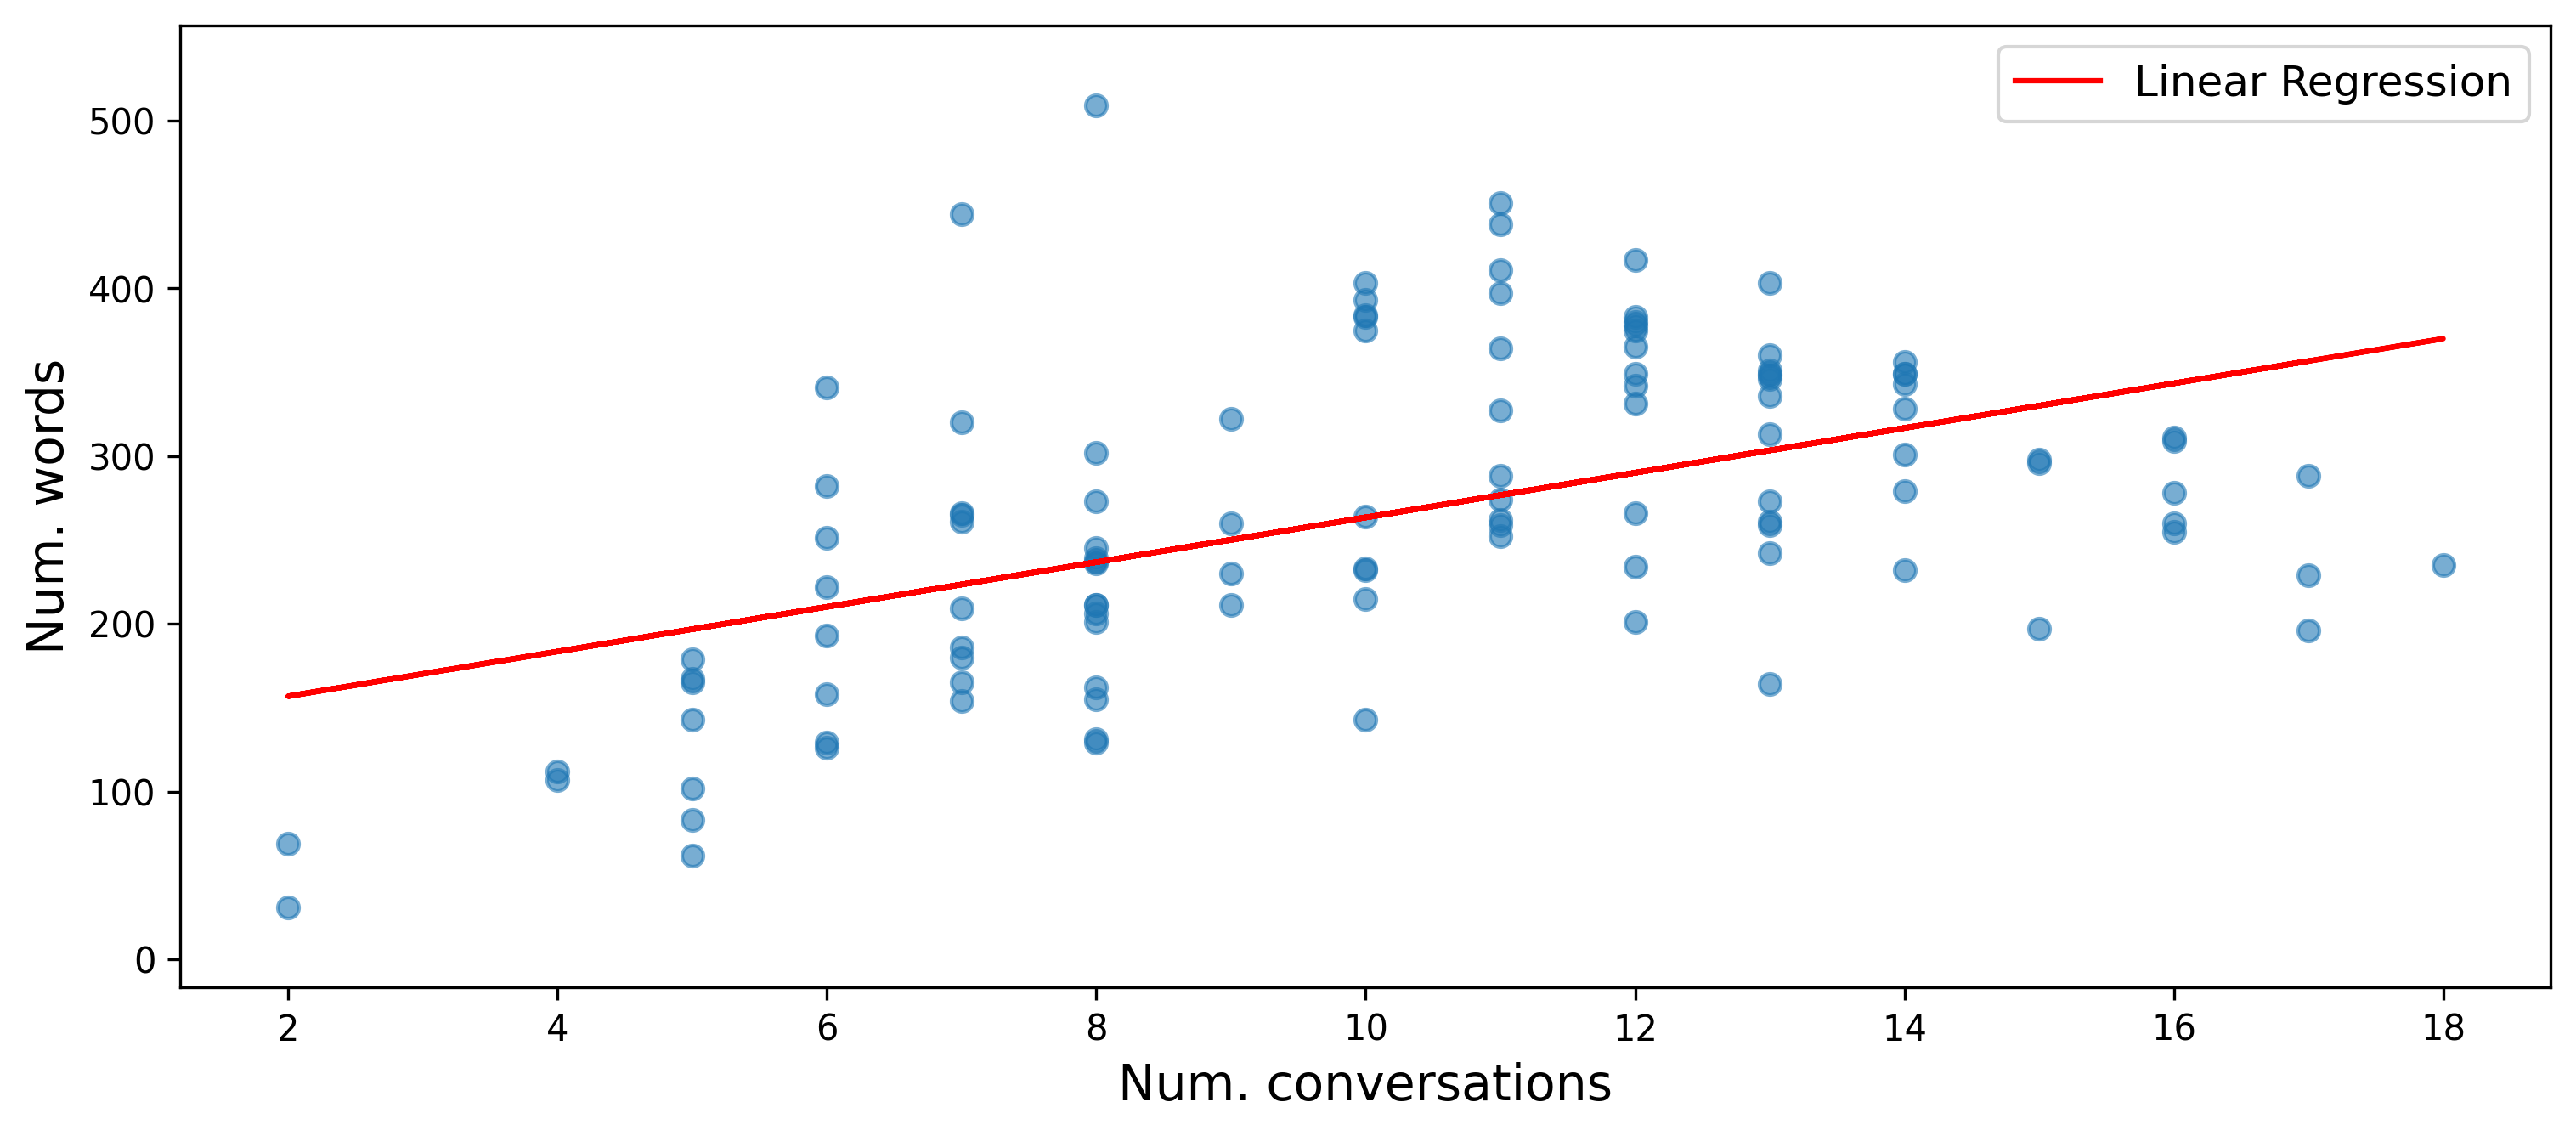

Correlation value 0.8503666039321494
P-value ***
Coefficients: 
 [1.34714925] 
Intercept: 
 -16.113975171987875
R-square: 0.72


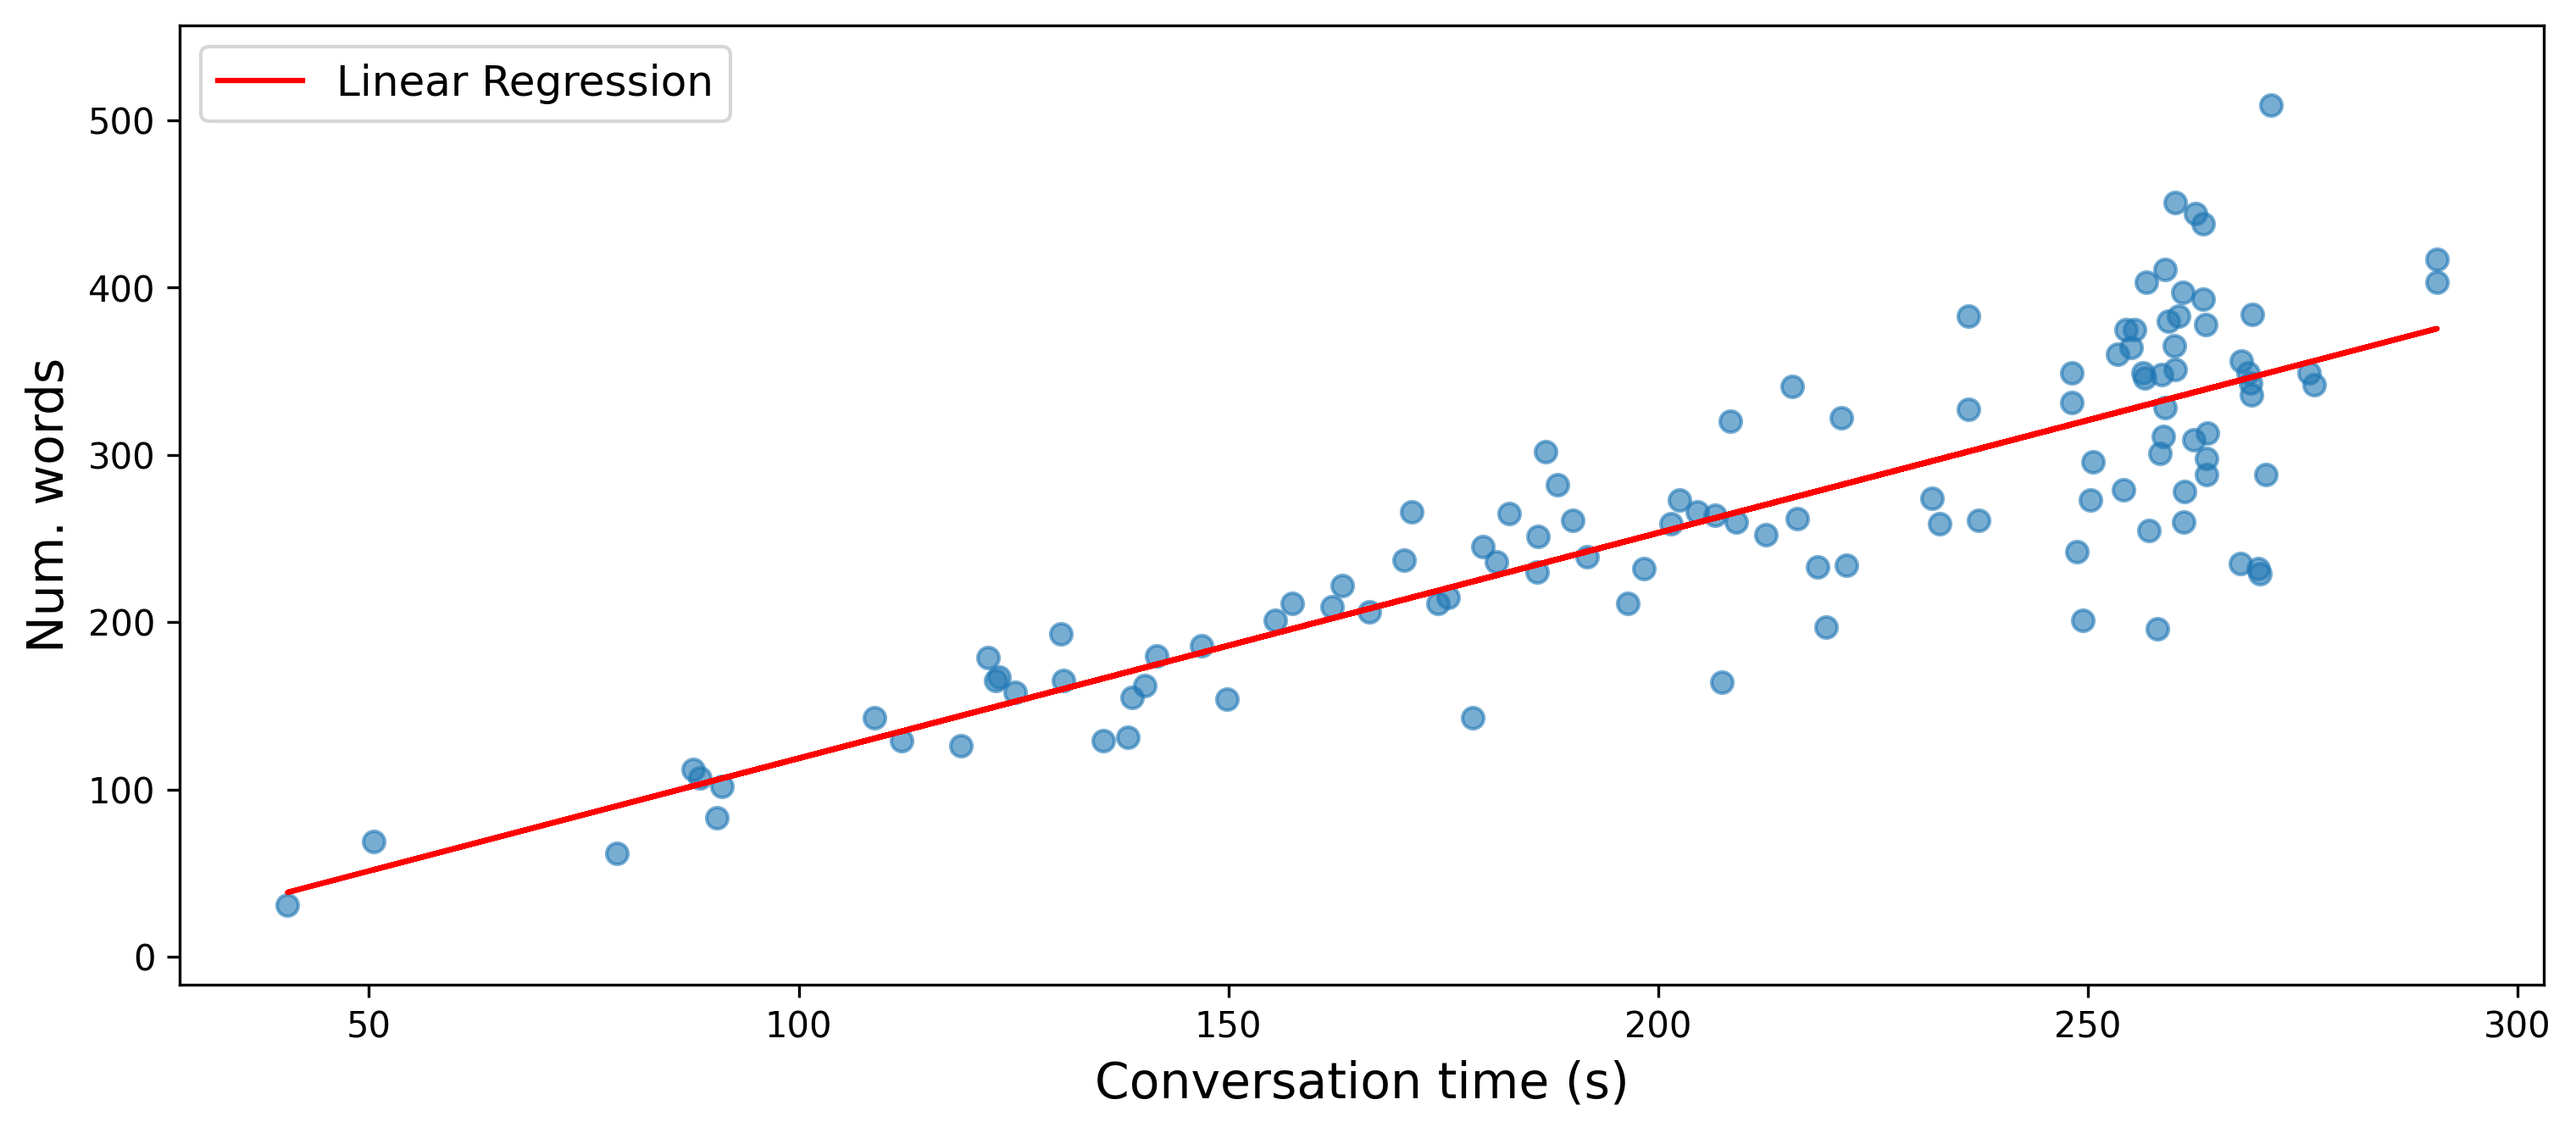

In [21]:
aute.make_scatter_plot(data=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(data=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

In [22]:
# I should do boxplots of this.

Mean All number of words = 265.8333 +/- 94.2437 ; Median = 261.5 ; Min. =  31 ; Max. =  509
Mean Person number of words = 111.7193 +/- 52.4064 ; Median = 107.0 ; Min. =  7 ; Max. =  268
Mean Bot number of words = 154.114 +/- 54.9377 ; Median = 153.0 ; Min. =  24 ; Max. =  306
P-value 1.0922022437791557e-08 string p value ***


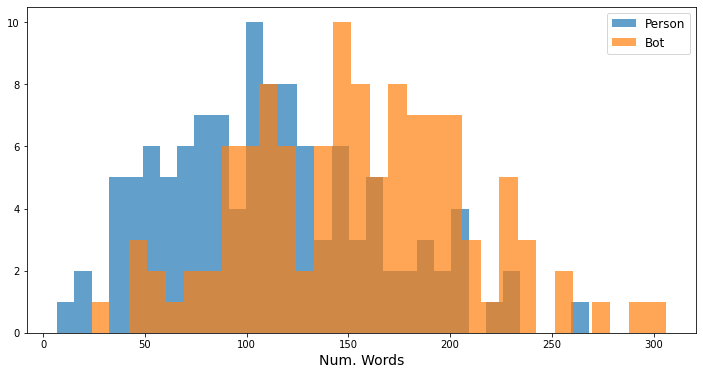

Mean All unique number of words = 107.6404 +/- 32.4332 ; Median = 107.0 ; Min. =  18 ; Max. =  195
Mean Person unique words = 60.5175 +/- 24.6652 ; Median = 59.0 ; Min. =  5 ; Max. =  126
Mean Bot unique words = 68.3684 +/- 22.4399 ; Median = 70.5 ; Min. =  13 ; Max. =  122
P-value 0.013030334963844857 string p value *


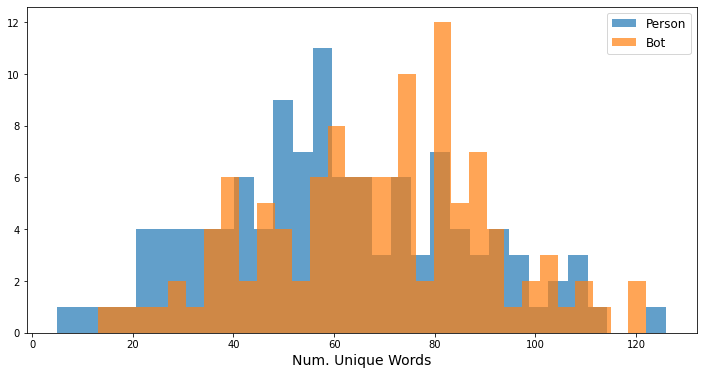

In [23]:
# #######################
# ### Number of words ###
# #######################

aute.stat_print(df_save["AllNumWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumWords"].values, "Person number of words")
aute.stat_print(df_save["BotNumWords"].values, "Bot number of words")
_, p = sp.stats.f_oneway(df_save["PersonNumWords"].values, df_save["BotNumWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

# ####################
# ### Unique words ###
# ####################

aute.stat_print(df_save["AllNumUniqWords"].values, "All unique number of words")
aute.stat_print(df_save["PersonNumUniqWords"].values, "Person unique words")
aute.stat_print(df_save["BotNumUniqWords"].values, "Bot unique words")
_, p = sp.stats.f_oneway(df_save["PersonNumUniqWords"].values, df_save["BotNumUniqWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumUniqWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumUniqWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Unique Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

#### EDA in times

In [24]:
check_list = []
for df in all_df_list:
    
    dict_data = {
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["S2TEndUnix"].iloc[-1] - df["UnixTimestampLoopInit"].iloc[0])/60,
    }
    
    dict_res = include_time_columns(df, col_name_init="AWSStartUniX", col_name_end="AWSEndUniX", label="AWS")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="S2TStartUnix", col_name_end="S2TEndUnix", label="GoogleS2T")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="BotStartUnix", col_name_end="BotEndUnix", label="OpenAI")
    dict_data.update(dict_res)
    
    check_list.append(dict_data)
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 21.0175 +/- 6.9812 ; Median = 21.0 ; Min. =  5 ; Max. =  36



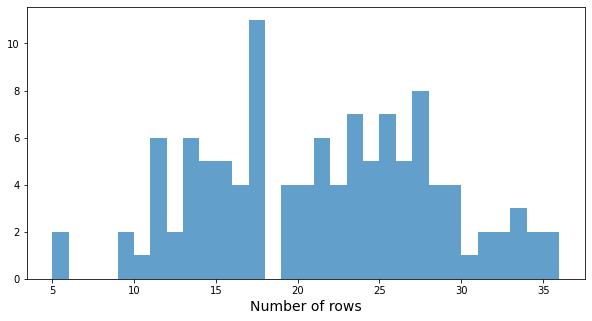

Mean Number of cols = 22.0 +/- 0.0 ; Median = 22.0 ; Min. =  22 ; Max. =  22

Mean Time conversation (min) = 3.9666 +/- 0.7779 ; Median = 4.3399 ; Min. =  2.0559 ; Max. =  4.8433



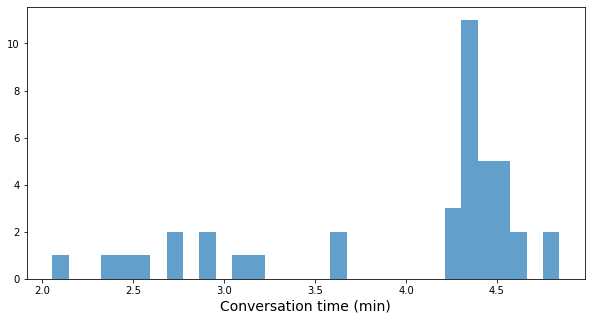

In [25]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.763 +/- 0.4333 ; Median = 1.7051 ; Min. =  0.8919 ; Max. =  3.338
Mean Mean_AWStime_s = 0.1278 +/- 0.0295 ; Median = 0.1298 ; Min. =  0.0845 ; Max. =  0.2155
Mean Mean_S2Ttime_s = 1.679 +/- 0.3175 ; Median = 1.5987 ; Min. =  1.294 ; Max. =  3.1064


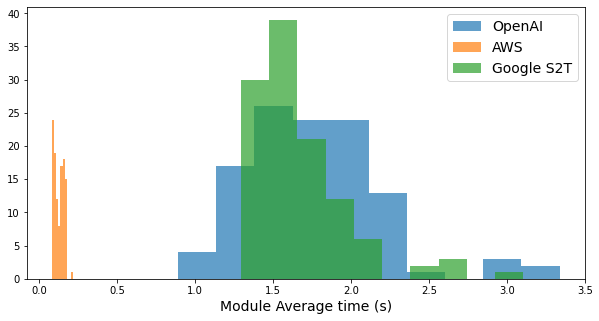

In [26]:
aute.stat_print(df_check["Mean_OpenAI"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Mean_AWS"], "Mean_AWStime_s")
aute.stat_print(df_check["Mean_GoogleS2T"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Mean_OpenAI"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Mean_AWS"], alpha=0.7, label="AWS")
plt.hist(df_check["Mean_GoogleS2T"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

In [27]:
save_time_dict = {
    "AWS_t": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "Google_S2T": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "OpenAI": {
        "num_words": [],
        "num_characters": [],
        "time": []
    }
}
for df in all_df_list:

    df_person = df[df["Source"]=="Person"]
    df_bot = df[df["Source"]=="Bot"]

    for i in range(df_bot.shape[0]):
        bot_sentence = df_bot["SpanishMessage"].iloc[i]
        num_all_words = len( "".join(re.findall(r'\w+', bot_sentence)) )
        save_time_dict["AWS_t"]["num_words"].append( num_all_words )
        save_time_dict["AWS_t"]["num_characters"].append( len(bot_sentence) )
        save_time_dict["AWS_t"]["time"].append( df_bot["AWSEndUniX"].iloc[i] - df_bot["AWSStartUniX"].iloc[i] )
    
    for i in range(df_person.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_person["SpanishMessage"].iloc[i])) )
        save_time_dict["Google_S2T"]["num_words"].append( num_all_words )
        save_time_dict["Google_S2T"]["num_characters"].append( len(df_person["SpanishMessage"].iloc[i]) )
        save_time_dict["Google_S2T"]["time"].append( df_person["S2TEndUnix"].iloc[i] - df_person["S2TStartUnix"].iloc[i] )

    for i in range(df_bot.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_bot["GlobalMessage"].iloc[i])) )
        save_time_dict["OpenAI"]["num_words"].append( num_all_words )
        save_time_dict["OpenAI"]["num_characters"].append( len(df_bot["GlobalMessage"].iloc[i]) )
        save_time_dict["OpenAI"]["time"].append( df_bot["BotTalkEndUnix"].iloc[i] - df_bot["BotTalkStartUnix"].iloc[i] )

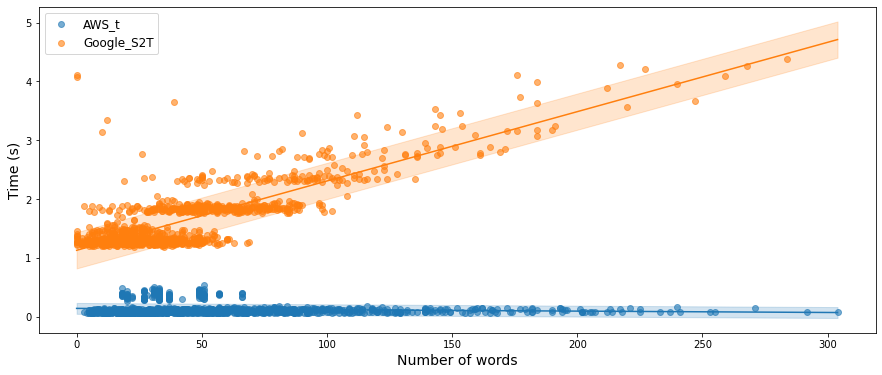

In [28]:
min_num_words = np.min([np.min(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])
max_num_words = np.max([np.max(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])

plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):
    
    if k is not "OpenAI":
    
        sort_x_idx = np.argsort(v["num_words"])
        y_time = np.array(v["time"])[sort_x_idx]
        x_len_text = np.array(v["num_words"])[sort_x_idx]

        x_to_lr = np.array(x_len_text).reshape(-1, 1)
        lr = LinearRegression(n_jobs=-1)
        lr.fit(x_to_lr, y_time)
        y_pred = lr.predict(x_to_lr)

        err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
        y_time_plus = y_pred + err_pred
        y_time_minus = y_pred - err_pred

        x_lim_min_max = np.array([max_num_words, min_num_words])
        y_lim_min_max = lr.predict(x_lim_min_max.reshape(-1, 1))

        plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
        plt.plot(x_lim_min_max, y_lim_min_max, color=aute.PLT_DEFAULT_COLORS[i])
        plt.fill_between(x_lim_min_max, 
                         y_lim_min_max + err_pred, 
                         y_lim_min_max - err_pred, 
                         alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

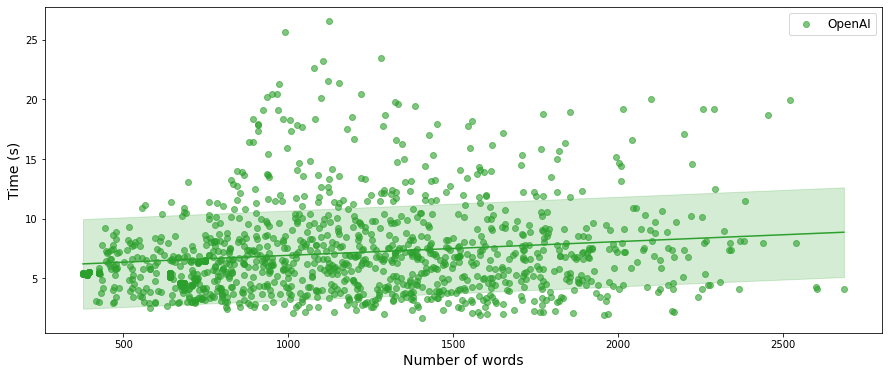

In [29]:
k = "OpenAI"
v = save_time_dict[k]

plt.figure(figsize=(15, 6))
    
sort_x_idx = np.argsort(v["num_words"])
y_time = np.array(v["time"])[sort_x_idx]
x_len_text = np.array(v["num_words"])[sort_x_idx]

x_to_lr = np.array(x_len_text).reshape(-1, 1)
lr = LinearRegression(n_jobs=-1)
lr.fit(x_to_lr, y_time)
y_pred = lr.predict(x_to_lr)

err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
y_time_plus = y_pred + err_pred
y_time_minus = y_pred - err_pred


plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

In [30]:
resource_name_list = ["OpenAItime_s", "AWStime_s", "S2Ttime_s"]
save_time_list = []
counter = 0
for df in all_df_list:
    
    max_index_take = df[df["Source"] == "Bot"].index[-1]
    df_to_study = df.loc[1:(max_index_take+1)].reset_index(drop=True)

    n_iter = (df_to_study.shape[0] // 2)

    for i in range(n_iter):

        delta_aws_t = (df_to_study["AWSEndUniX"].iloc[2*i+1] - df_to_study["AWSStartUniX"].iloc[2*i+1])
        delta_s2t_t = (df_to_study["S2TEndUnix"].iloc[2*i] - df_to_study["S2TStartUnix"].iloc[2*i])
        delta_bot_t = (df_to_study["BotEndUnix"].iloc[2*i+1] - df_to_study["BotStartUnix"].iloc[2*i+1])

        total_time = df_to_study["BotTalkStartUnix"].iloc[2*i+1] - df_to_study["PersonTalkEndUnix"].iloc[2*i]
        rest_time = total_time - delta_bot_t - delta_s2t_t - delta_aws_t

        all_times_list = [
            (delta_aws_t, "AWS"), 
            (delta_s2t_t, "S2T"), 
            (delta_bot_t, "OpenAI"), 
            (total_time, "Total"), 
            (rest_time, "Rest")
        ]
        
        for elt in all_times_list:
            save_time_list.append({
                "Iteration": counter,
                "Source": elt[1],
                "Time": elt[0]
            })

        counter += 1
        
df_times = pd.DataFrame(save_time_list)
print("Shape", df_times.shape)

Shape (5605, 3)


In [31]:
all_times_list = []
for g, df_g in df_times.groupby("Iteration"):
    dict_times = dict(zip(df_g["Source"].values.tolist(), df_g["Time"].values.tolist()))
    all_times_list.append(dict_times)
df_all_t_sources = pd.DataFrame(all_times_list)

df_all_t_sources.to_csv("../Documents/ResultsTable/SaveToBoxplot.csv", index=False)

for col in df_all_t_sources.columns:
    print("Source", col, "takes:")
    aute.stat_print(df_all_t_sources[col], col + " (s)")
    print("In percentage", np.round(100 * np.sum(df_all_t_sources[col])/np.sum(df_all_t_sources["Total"]), 4), "%")
    print()

Source AWS takes:
Mean AWS (s) = 0.1008 +/- 0.0513 ; Median = 0.0957 ; Min. =  0.0578 ; Max. =  0.5326
In percentage 2.201 %

Source S2T takes:
Mean S2T (s) = 1.6653 +/- 0.5429 ; Median = 1.4093 ; Min. =  1.1878 ; Max. =  4.3842
In percentage 36.3632 %

Source OpenAI takes:
Mean OpenAI (s) = 1.8899 +/- 1.1141 ; Median = 1.6674 ; Min. =  0.0 ; Max. =  7.4341
In percentage 41.2678 %

Source Total takes:
Mean Total (s) = 4.5797 +/- 1.4894 ; Median = 4.2965 ; Min. =  1.6207 ; Max. =  10.9466
In percentage 100.0 %

Source Rest takes:
Mean Rest (s) = 0.9236 +/- 0.4102 ; Median = 0.8757 ; Min. =  0.2134 ; Max. =  4.1228
In percentage 20.168 %



In [32]:
all_diff = df_all_t_sources["Total"] - np.sum(df_all_t_sources[["Rest", "OpenAI", "S2T", "AWS"]], axis=1)
np.max(all_diff)

0.0

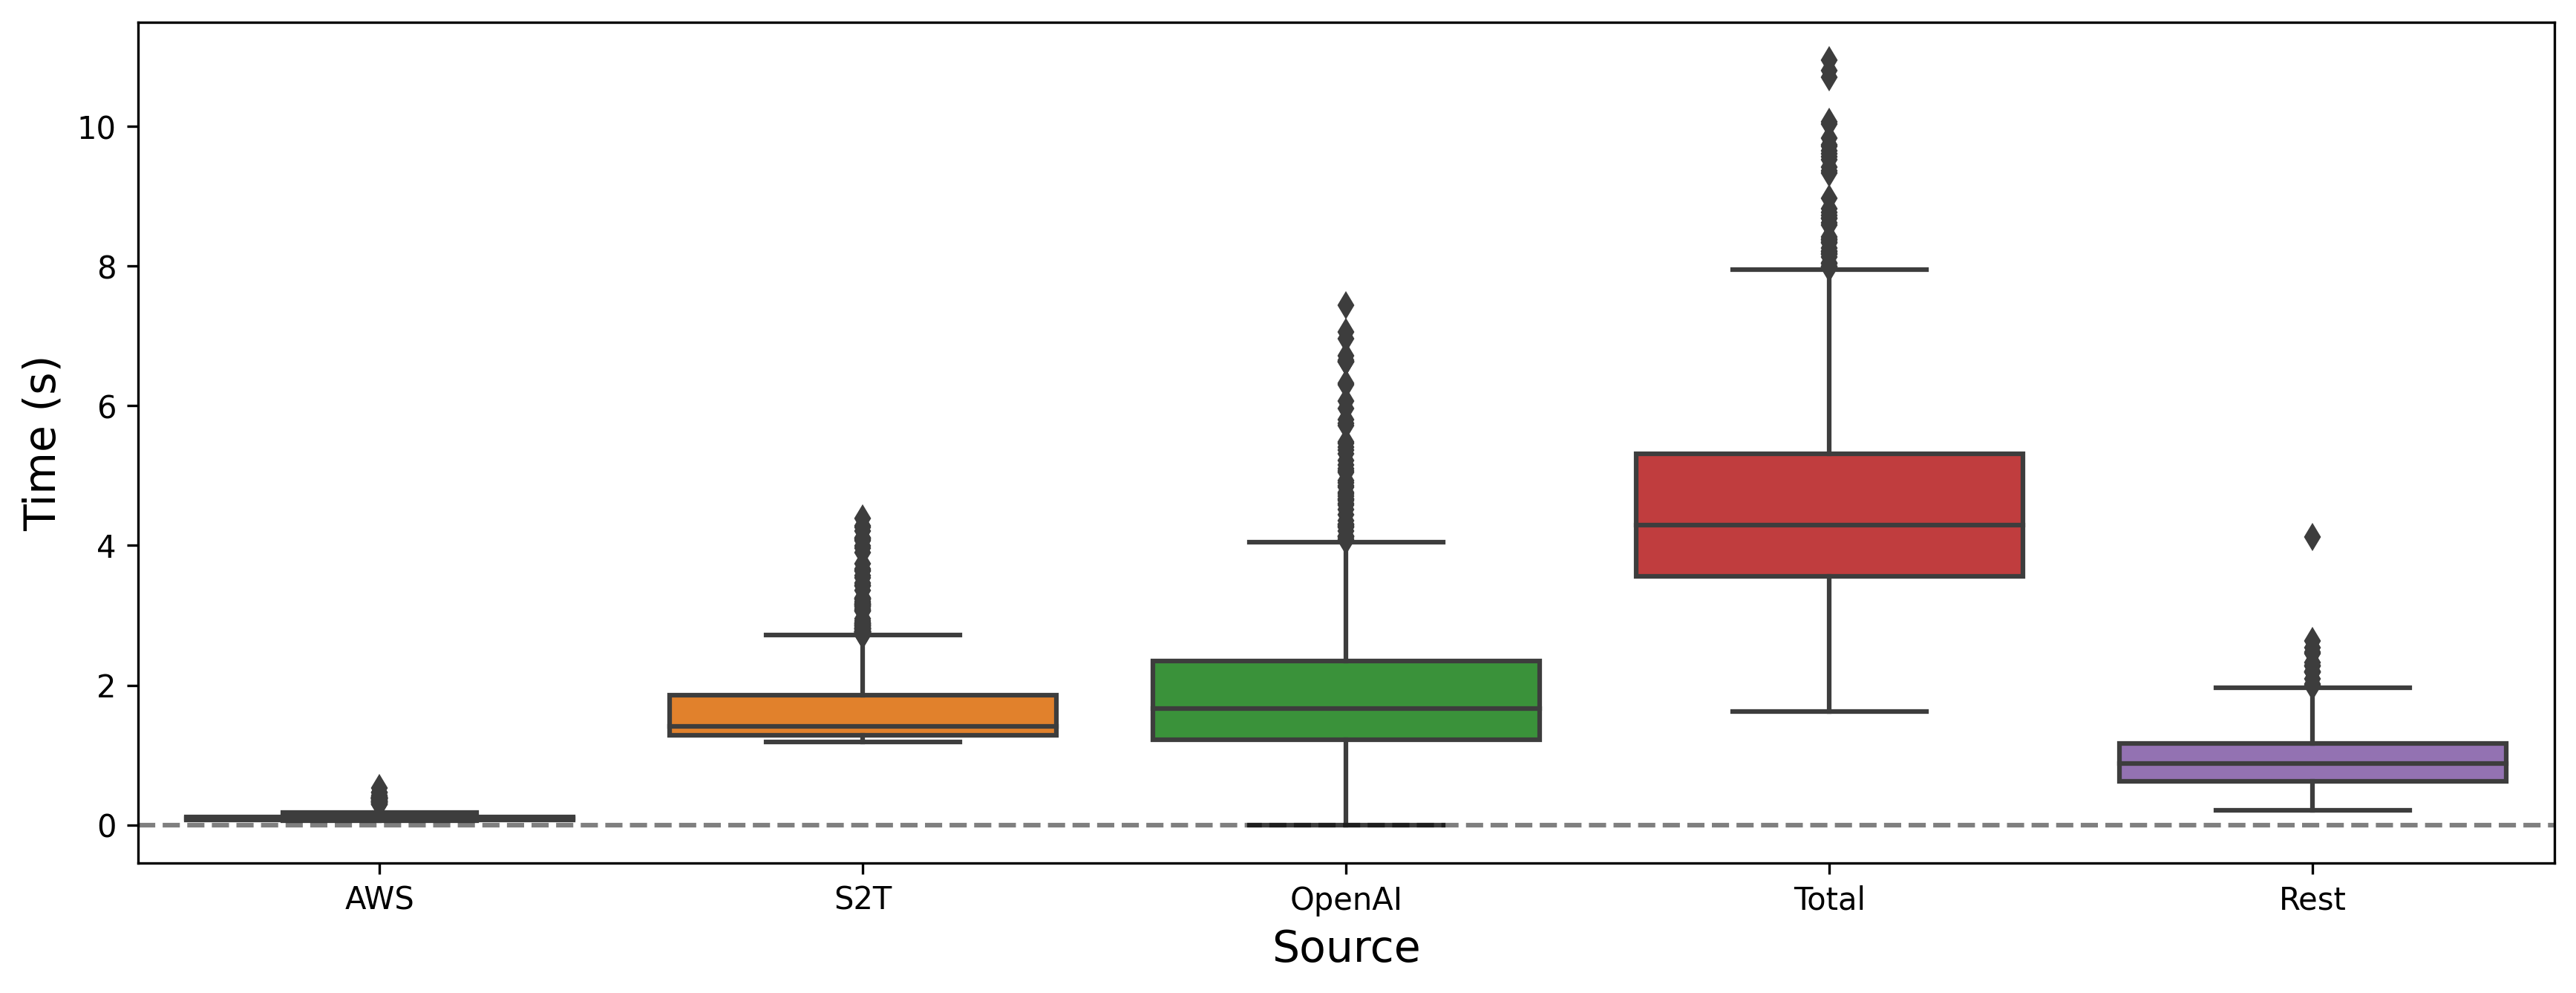

In [33]:
plt.figure(figsize=(14, 5), dpi=300)
sns.boxplot(x="Source", y="Time", data=df_times)

plt.axhline(0, c="black", linestyle="--", alpha=0.5)

plt.xlabel("Source", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.savefig('../Documents/Images/save_boxplot.pdf', format='pdf', dpi=300)
plt.savefig('../Documents/Images/save_boxplot.png', format='png', dpi=300)

plt.show()

### Crude Text 

#### Token size analysis

In [34]:
def obtain_word_analysis(data, target):
    result_list = []
    for text in data[target].tolist():
        
        original_text_clean = clean_text_func(text, subject_name=None, use_stemmer=False)
        sentence_list = [sentence for sentence in original_text_clean.split(".") if len(sentence) > 1]
        len_list = [len(sent.split()) for sent in sentence_list]
        
        result_list.append({
            "mean": np.mean(len_list),
            "median": np.median(len_list),
            "std": np.std(len_list),
            "num_words_in_sentence": len_list
        })

    return pd.DataFrame(result_list)

Mean Number of words for BOT by sentence = 7.9237 +/- 5.6436 ; Median = 6.0 ; Min. =  1 ; Max. =  35
Mean Number of words for Person by sentence = 9.6829 +/- 8.0658 ; Median = 8.0 ; Min. =  1 ; Max. =  67
P-value 1.2620619561905988e-13 string p value ***


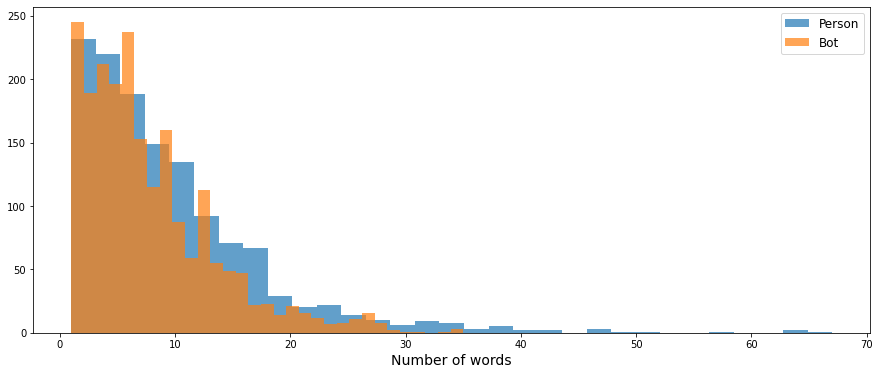

In [35]:
df_bot_result = obtain_word_analysis(df_save, "BotOriginalText")
df_person_result = obtain_word_analysis(df_save, "PersonOriginalText")

bot_word_number = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    bot_word_number += my_list

person_word_number = []
for my_list in df_person_result["num_words_in_sentence"].tolist():
    person_word_number += my_list

aute.stat_print(bot_word_number, "Number of words for BOT by sentence")
aute.stat_print(person_word_number, "Number of words for Person by sentence")

_, p = sp.stats.f_oneway(person_word_number, bot_word_number)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(15, 6))

plt.hist(person_word_number, bins=31, alpha=0.7, label="Person")
plt.hist(bot_word_number, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Number of words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Mean Number of words for ALL by sentence = 8.5975 +/- 6.7141 ; Median = 7.0 ; Min. =  1 ; Max. =  67


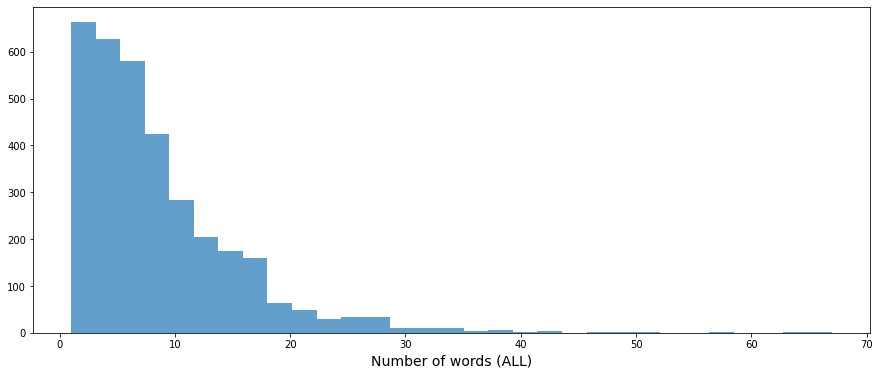

In [36]:
df_all_result = obtain_word_analysis(df_save, "AllOriginalText")

all_word_number = []
for my_list in df_all_result["num_words_in_sentence"].tolist():
    all_word_number += my_list

aute.stat_print(all_word_number, "Number of words for ALL by sentence")

plt.figure(figsize=(15, 6))

plt.hist(all_word_number, bins=31, alpha=0.7, label="All")
plt.xlabel("Number of words (ALL)", fontsize=14)

plt.show()

## Study by personalities

In the following section it will be studied the time spend, number of words, time between senteces etc in terms of the personality.

In [37]:
uniq_config_name = df_save["ConfigName"].unique()

In [38]:
save_personality_res_list = []
for personality_label in uniq_config_name:
    
    print("Personality", personality_label)
    
    study_pers_list = [df_check for df_check in all_df_list if personality_label == df_check["ConfigName"].iloc[0]]
    df_study = pd.concat(study_pers_list).reset_index(drop=True)
    
    for i in range(df_study.shape[0]):
        source = df_study["Source"].iloc[i]
        
        gender_check = personality_label.split("_")[1]
        if gender_check == "Male":
            gender = "Man"
        elif gender_check == "Female":
            gender = "Woman"
        else:
            gender = gender_check
            
        save_personality_res_list.append({
            "Label": personality_label,
            "Personality": personality_label.split("_")[0],
            "Gender": gender,
            "GenderBotId": personality_label.split("_")[2],
            "Source": source,
            "SibjectId": df_study["SubjectId"].iloc[i],
            "DeltaTimeTalk": df_study[source + "TalkEndUnix"].values[i] - df_study[source + "TalkStartUnix"].values[i],
            "NumWordsUsed": len(df_study["SpanishMessage"].values[i].split())
        })
        
df_met_by_sent = pd.DataFrame(save_personality_res_list)
print("Shape", df_met_by_sent.shape)
print("Columns", df_met_by_sent.columns)
display(df_met_by_sent.head(5))

Personality Neutral_Female_2
Personality Neutral_Male_1
Personality Happy_Woman_1
Personality Relax_Man_2
Personality Sad_Woman_2
Personality Angry_Man_1
Personality Neutral_Male_2
Personality Happy_Man_1
Personality Relax_Woman_2
Personality Sad_Woman_1
Personality Sad_Man_2
Personality Relax_Woman_1
Personality Neutral_Female_1
Personality Happy_Man_2
Personality Angry_Man_2
Personality Happy_Woman_2
Personality Angry_Woman_1
Personality Sad_Man_1
Personality Relax_Man_1
Personality Angry_Woman_2
Shape (2396, 8)
Columns Index(['Label', 'Personality', 'Gender', 'GenderBotId', 'Source', 'SibjectId',
       'DeltaTimeTalk', 'NumWordsUsed'],
      dtype='object')


,Label,Personality,Gender,GenderBotId,Source,SibjectId,DeltaTimeTalk,NumWordsUsed
0,Neutral_Female_2,Neutral,Woman,2,Bot,User_01_CB,5.504184,9
1,Neutral_Female_2,Neutral,Woman,2,Person,User_01_CB,6.223614,4
2,Neutral_Female_2,Neutral,Woman,2,Bot,User_01_CB,4.158248,4
3,Neutral_Female_2,Neutral,Woman,2,Person,User_01_CB,6.221283,5
4,Neutral_Female_2,Neutral,Woman,2,Bot,User_01_CB,11.109357,21


### Studying person

P-value 0.10445139768100452 with significance -


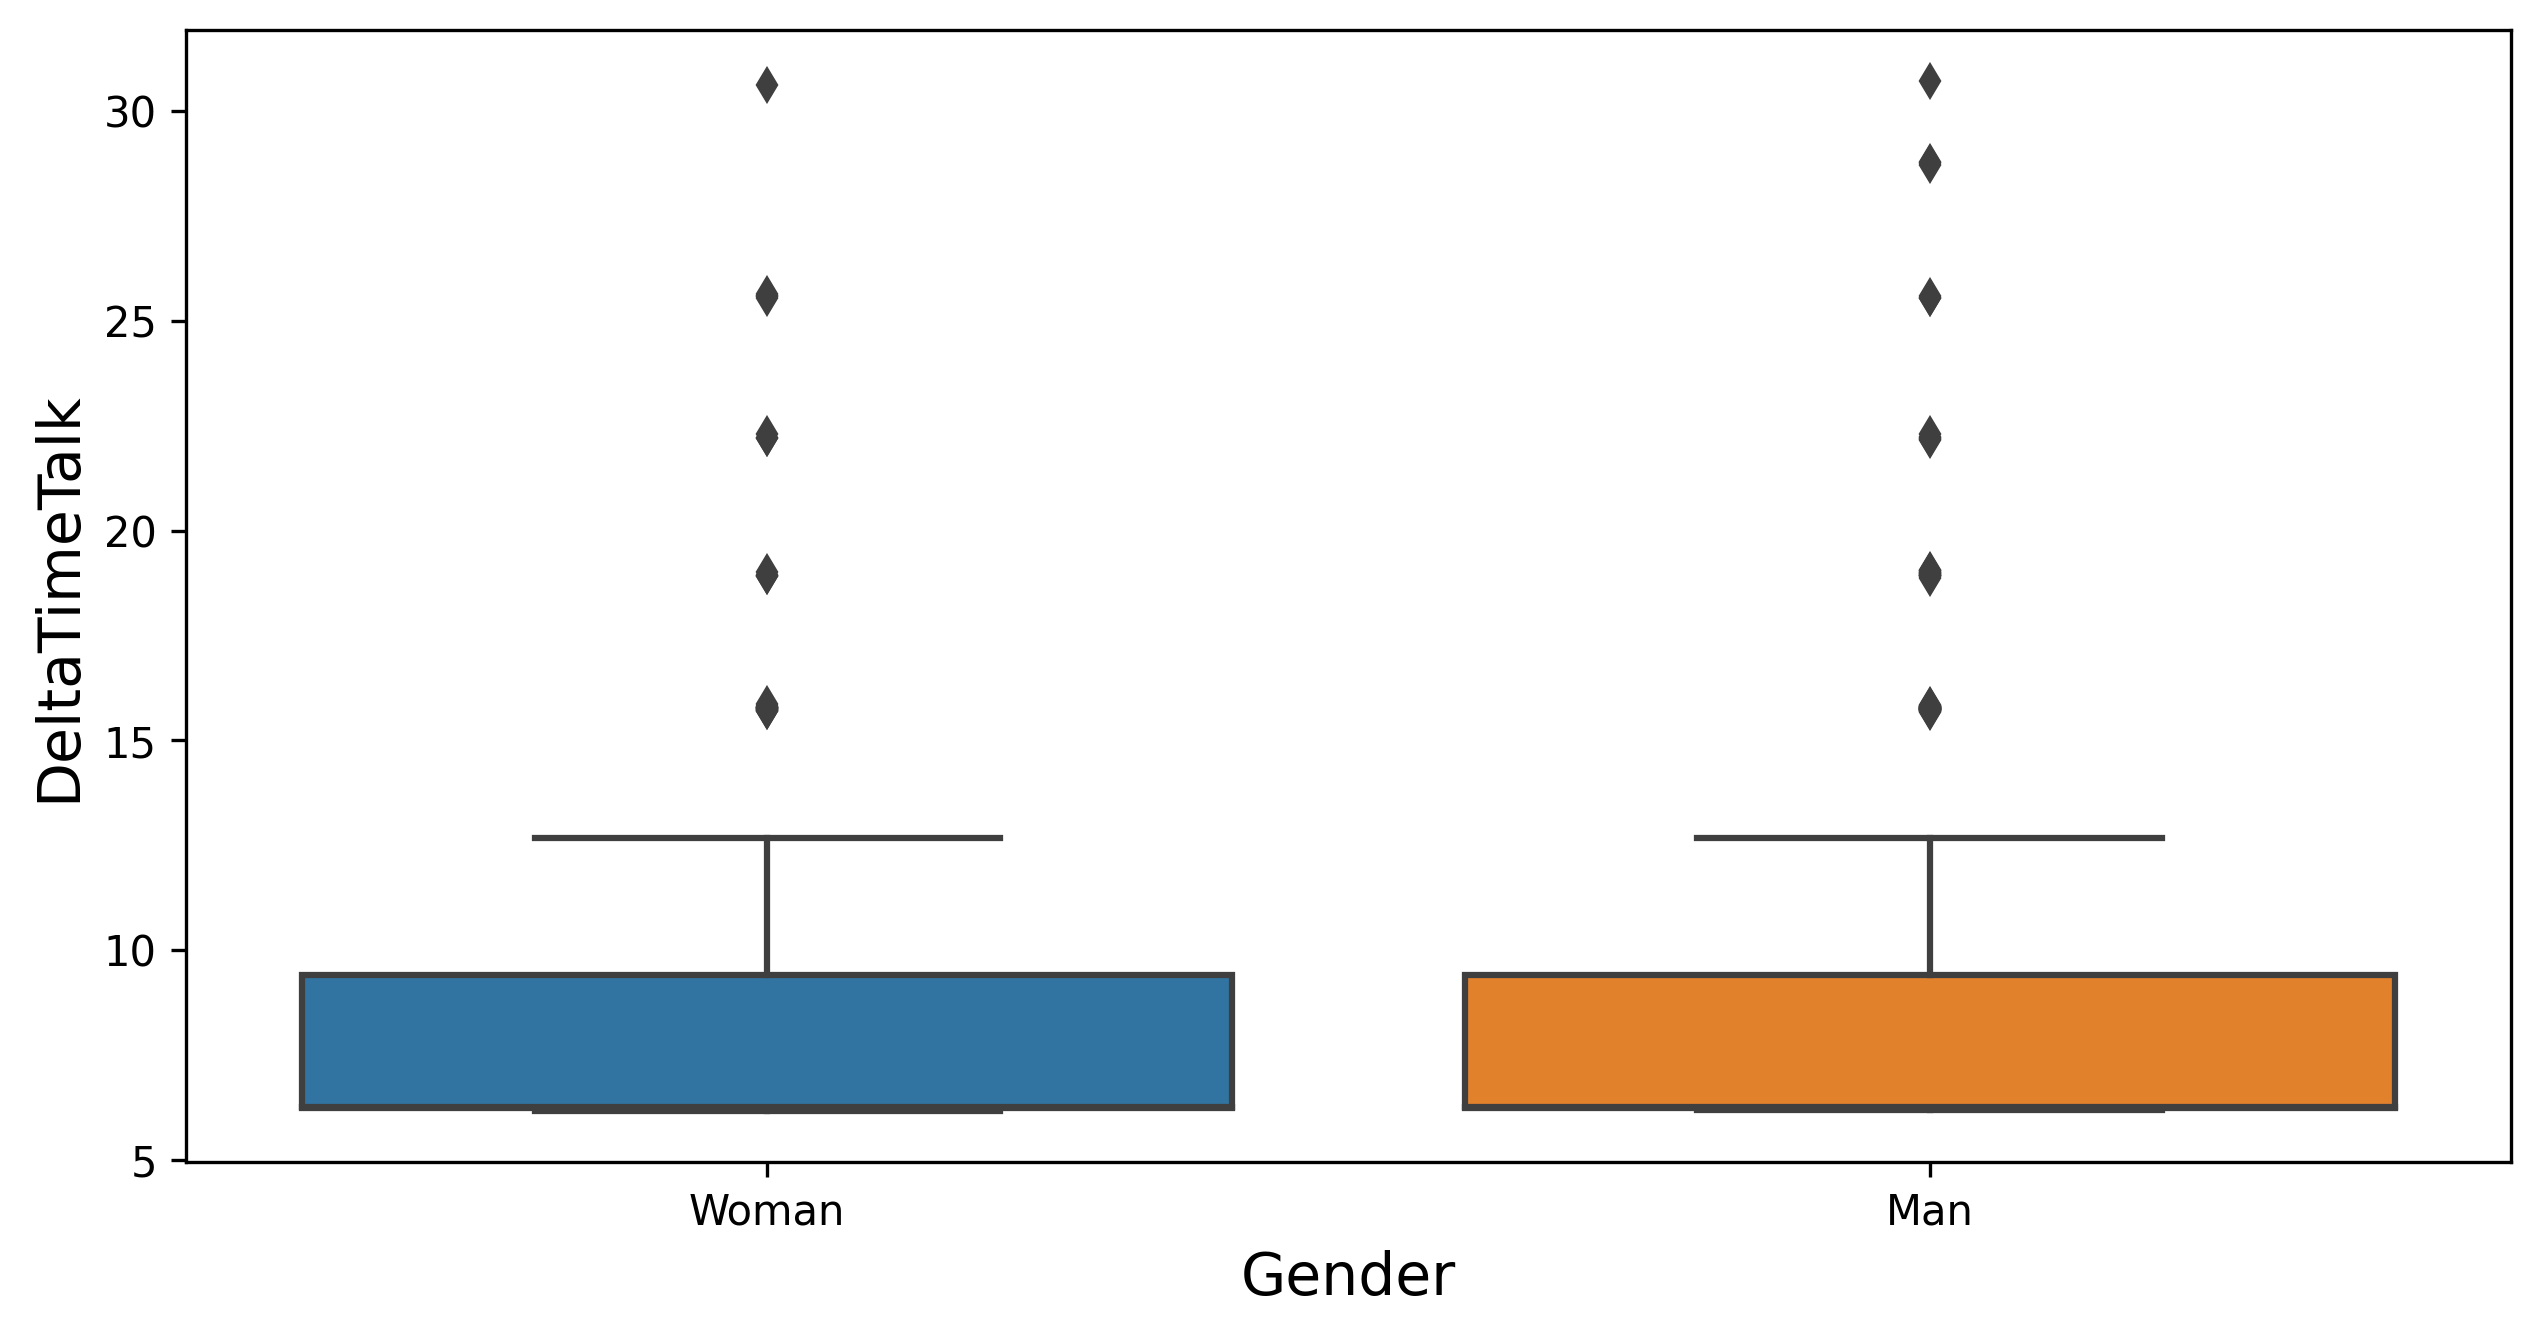

P-value 0.10483941581013585 with significance -


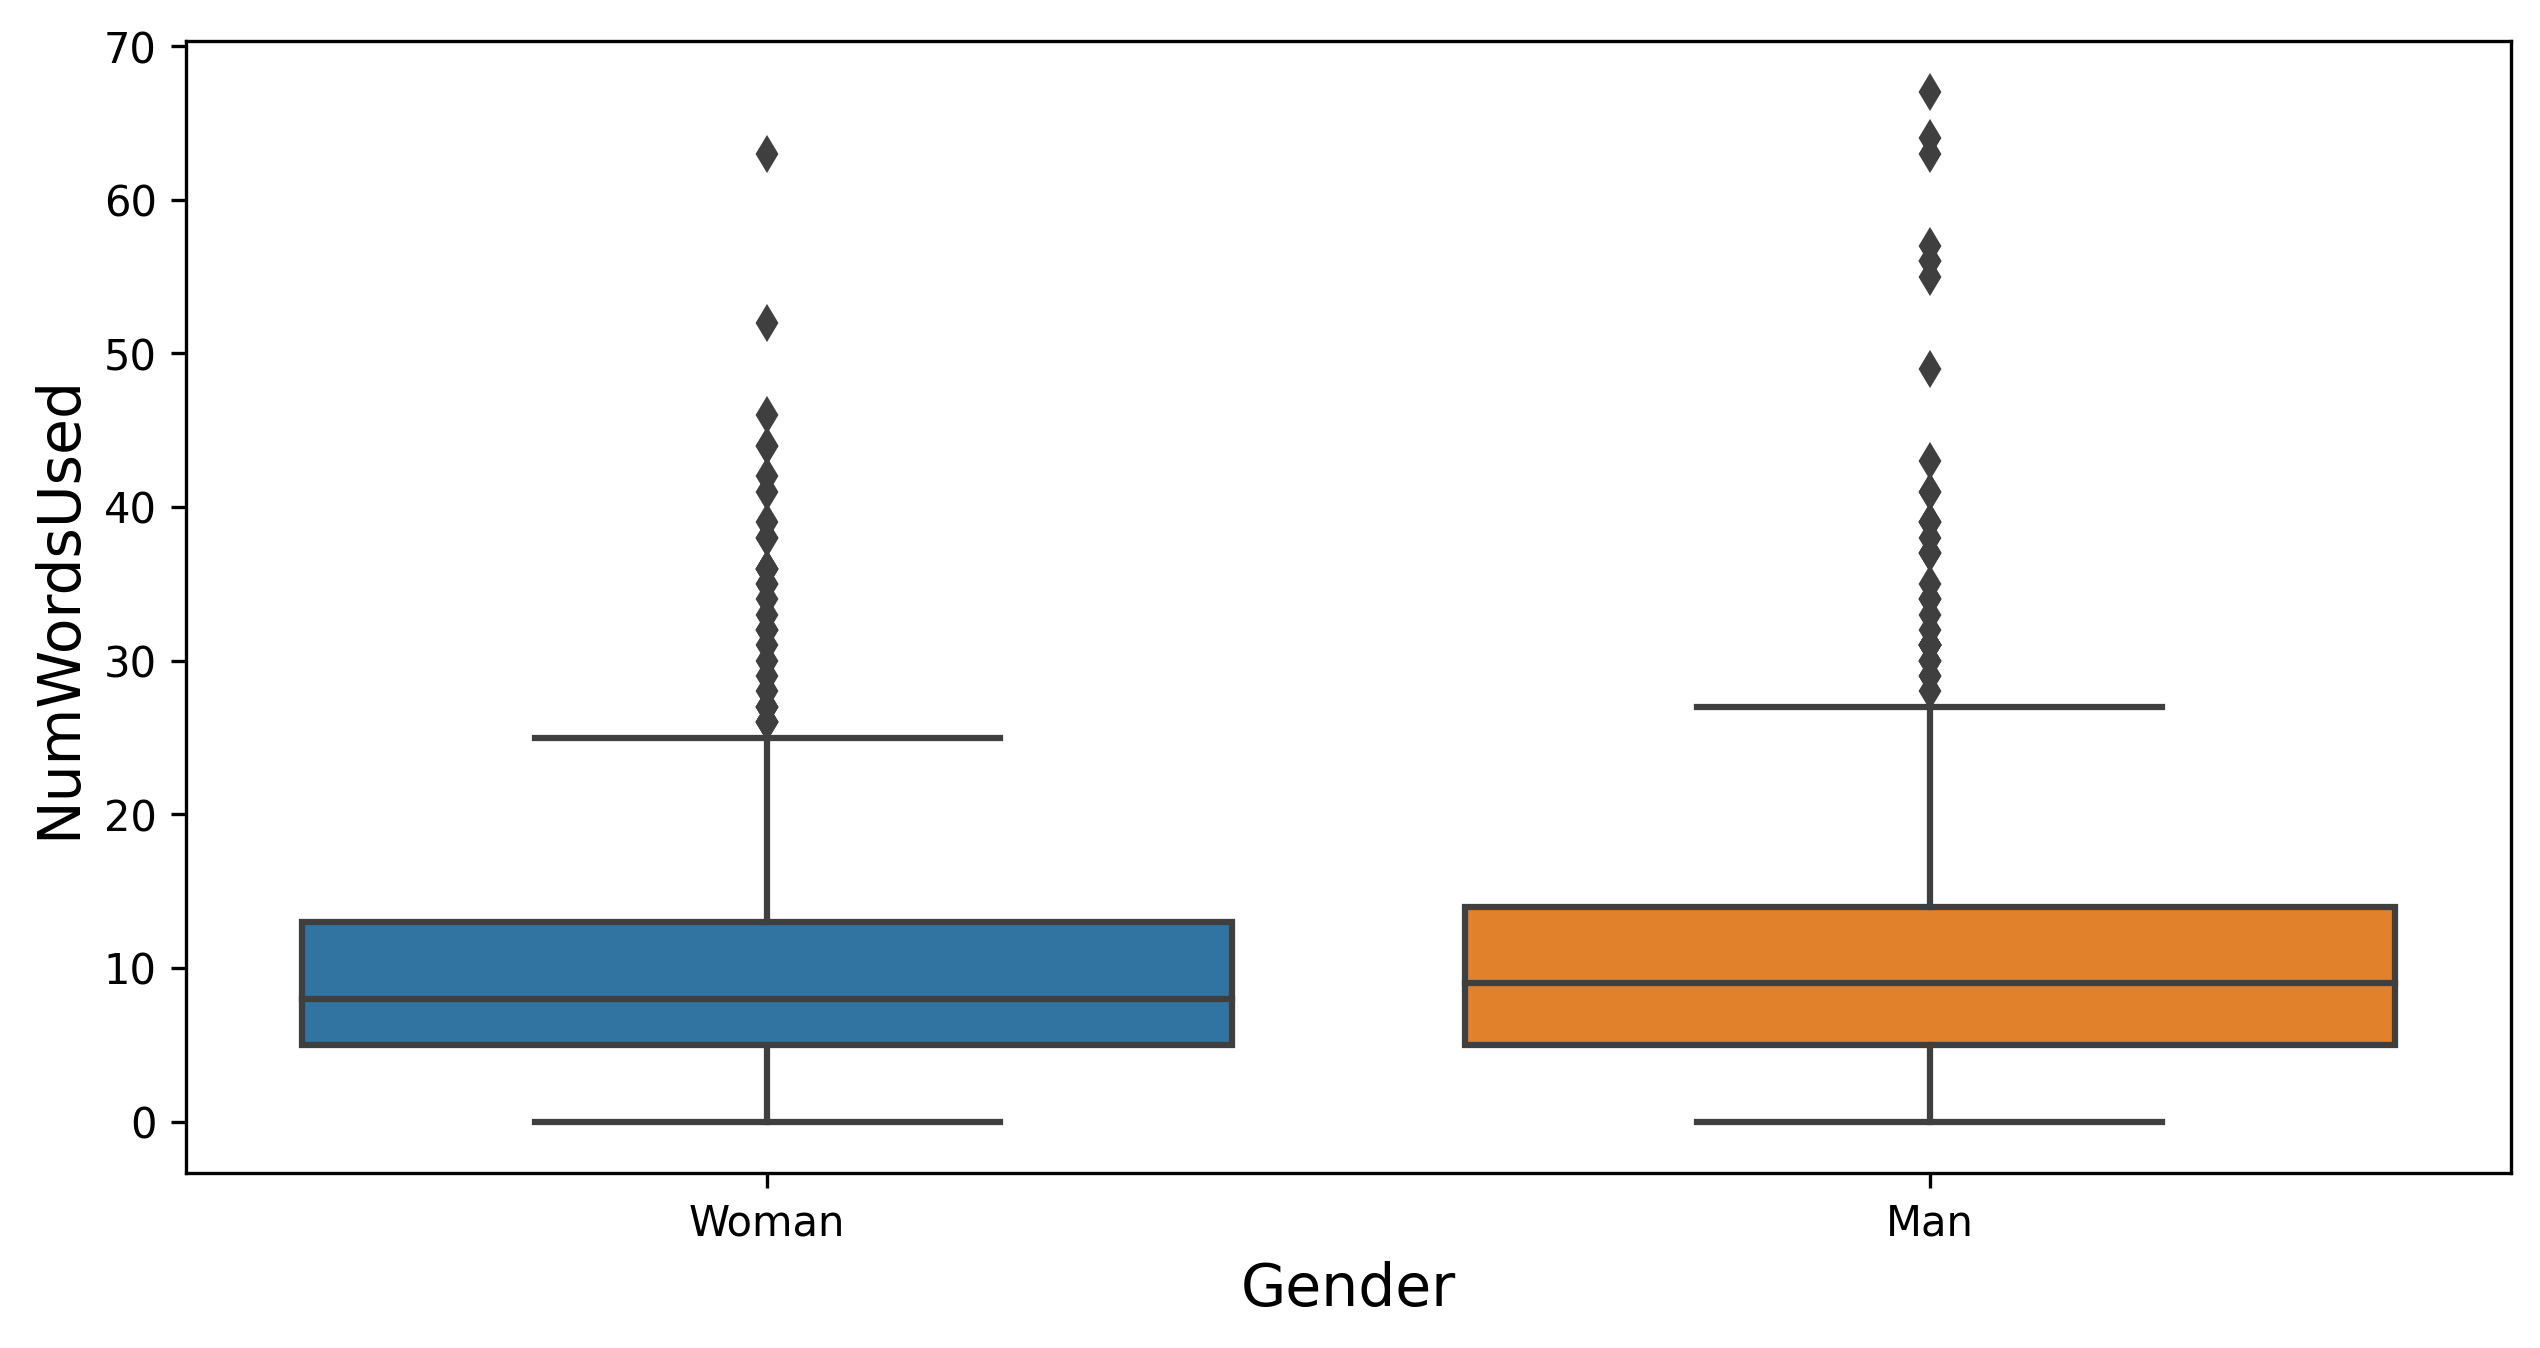

In [39]:
df_to_plot = df_met_by_sent[df_met_by_sent["Source"] == "Person"]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Gender", x_name="Gender", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Gender", x_name="Gender", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

P-value 0.005356148601688759 with significance **


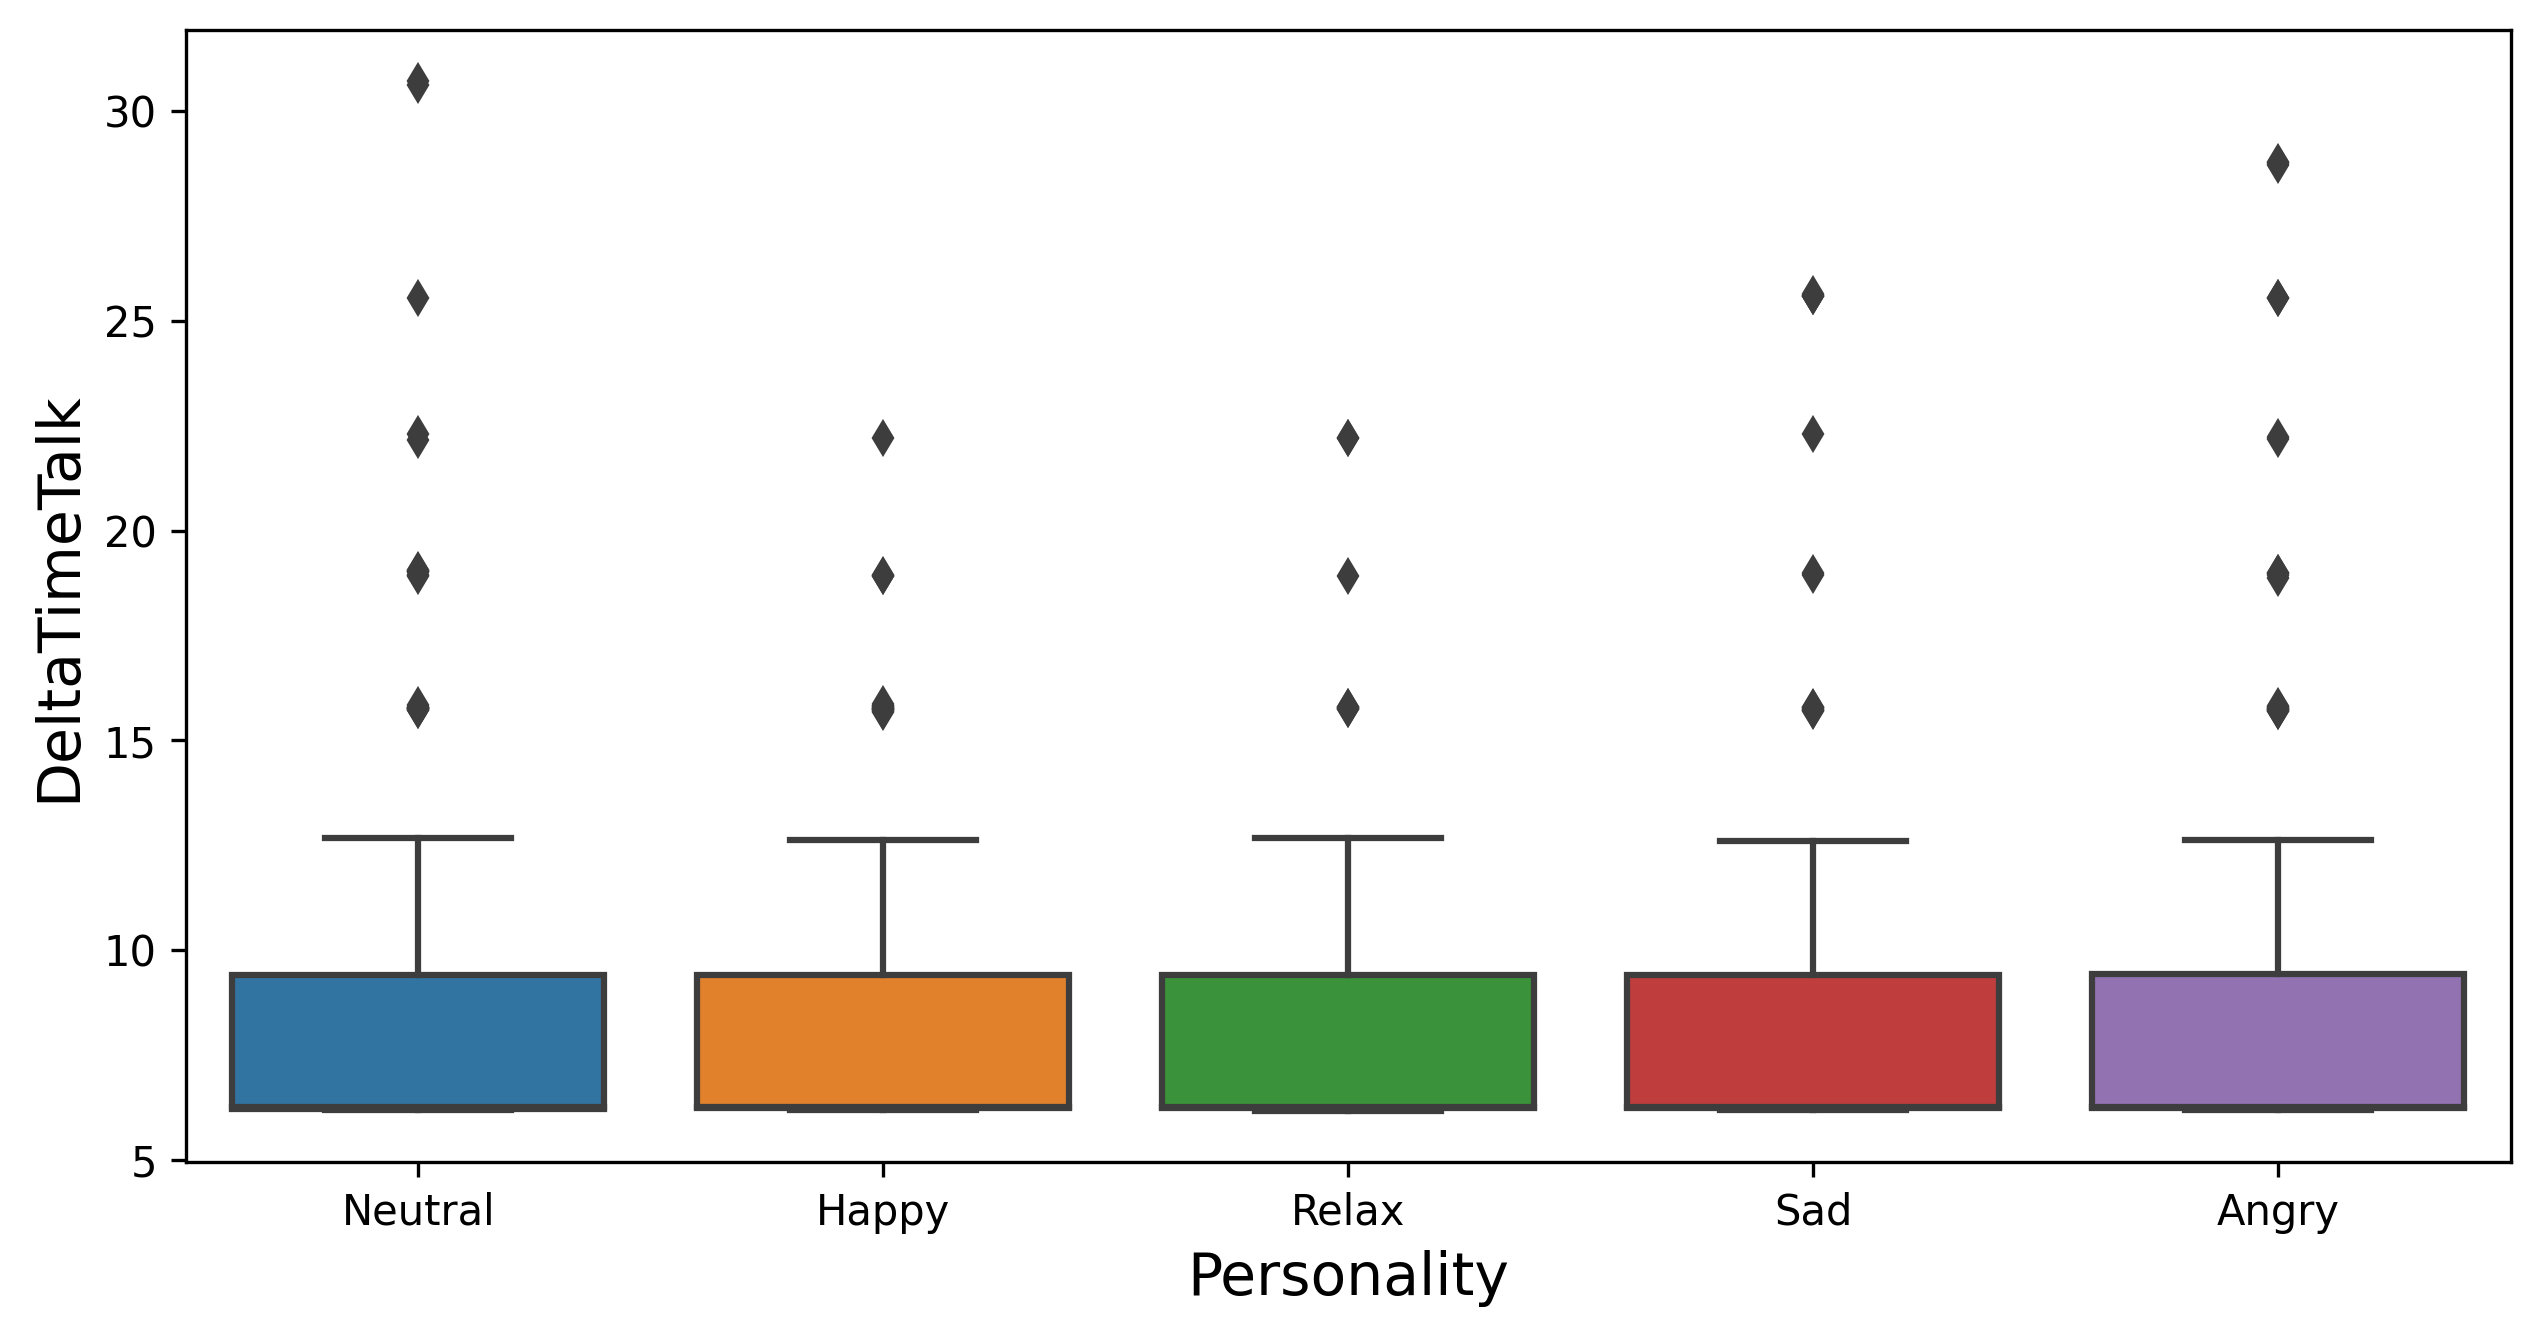

P-value 2.966120849235481e-05 with significance ***


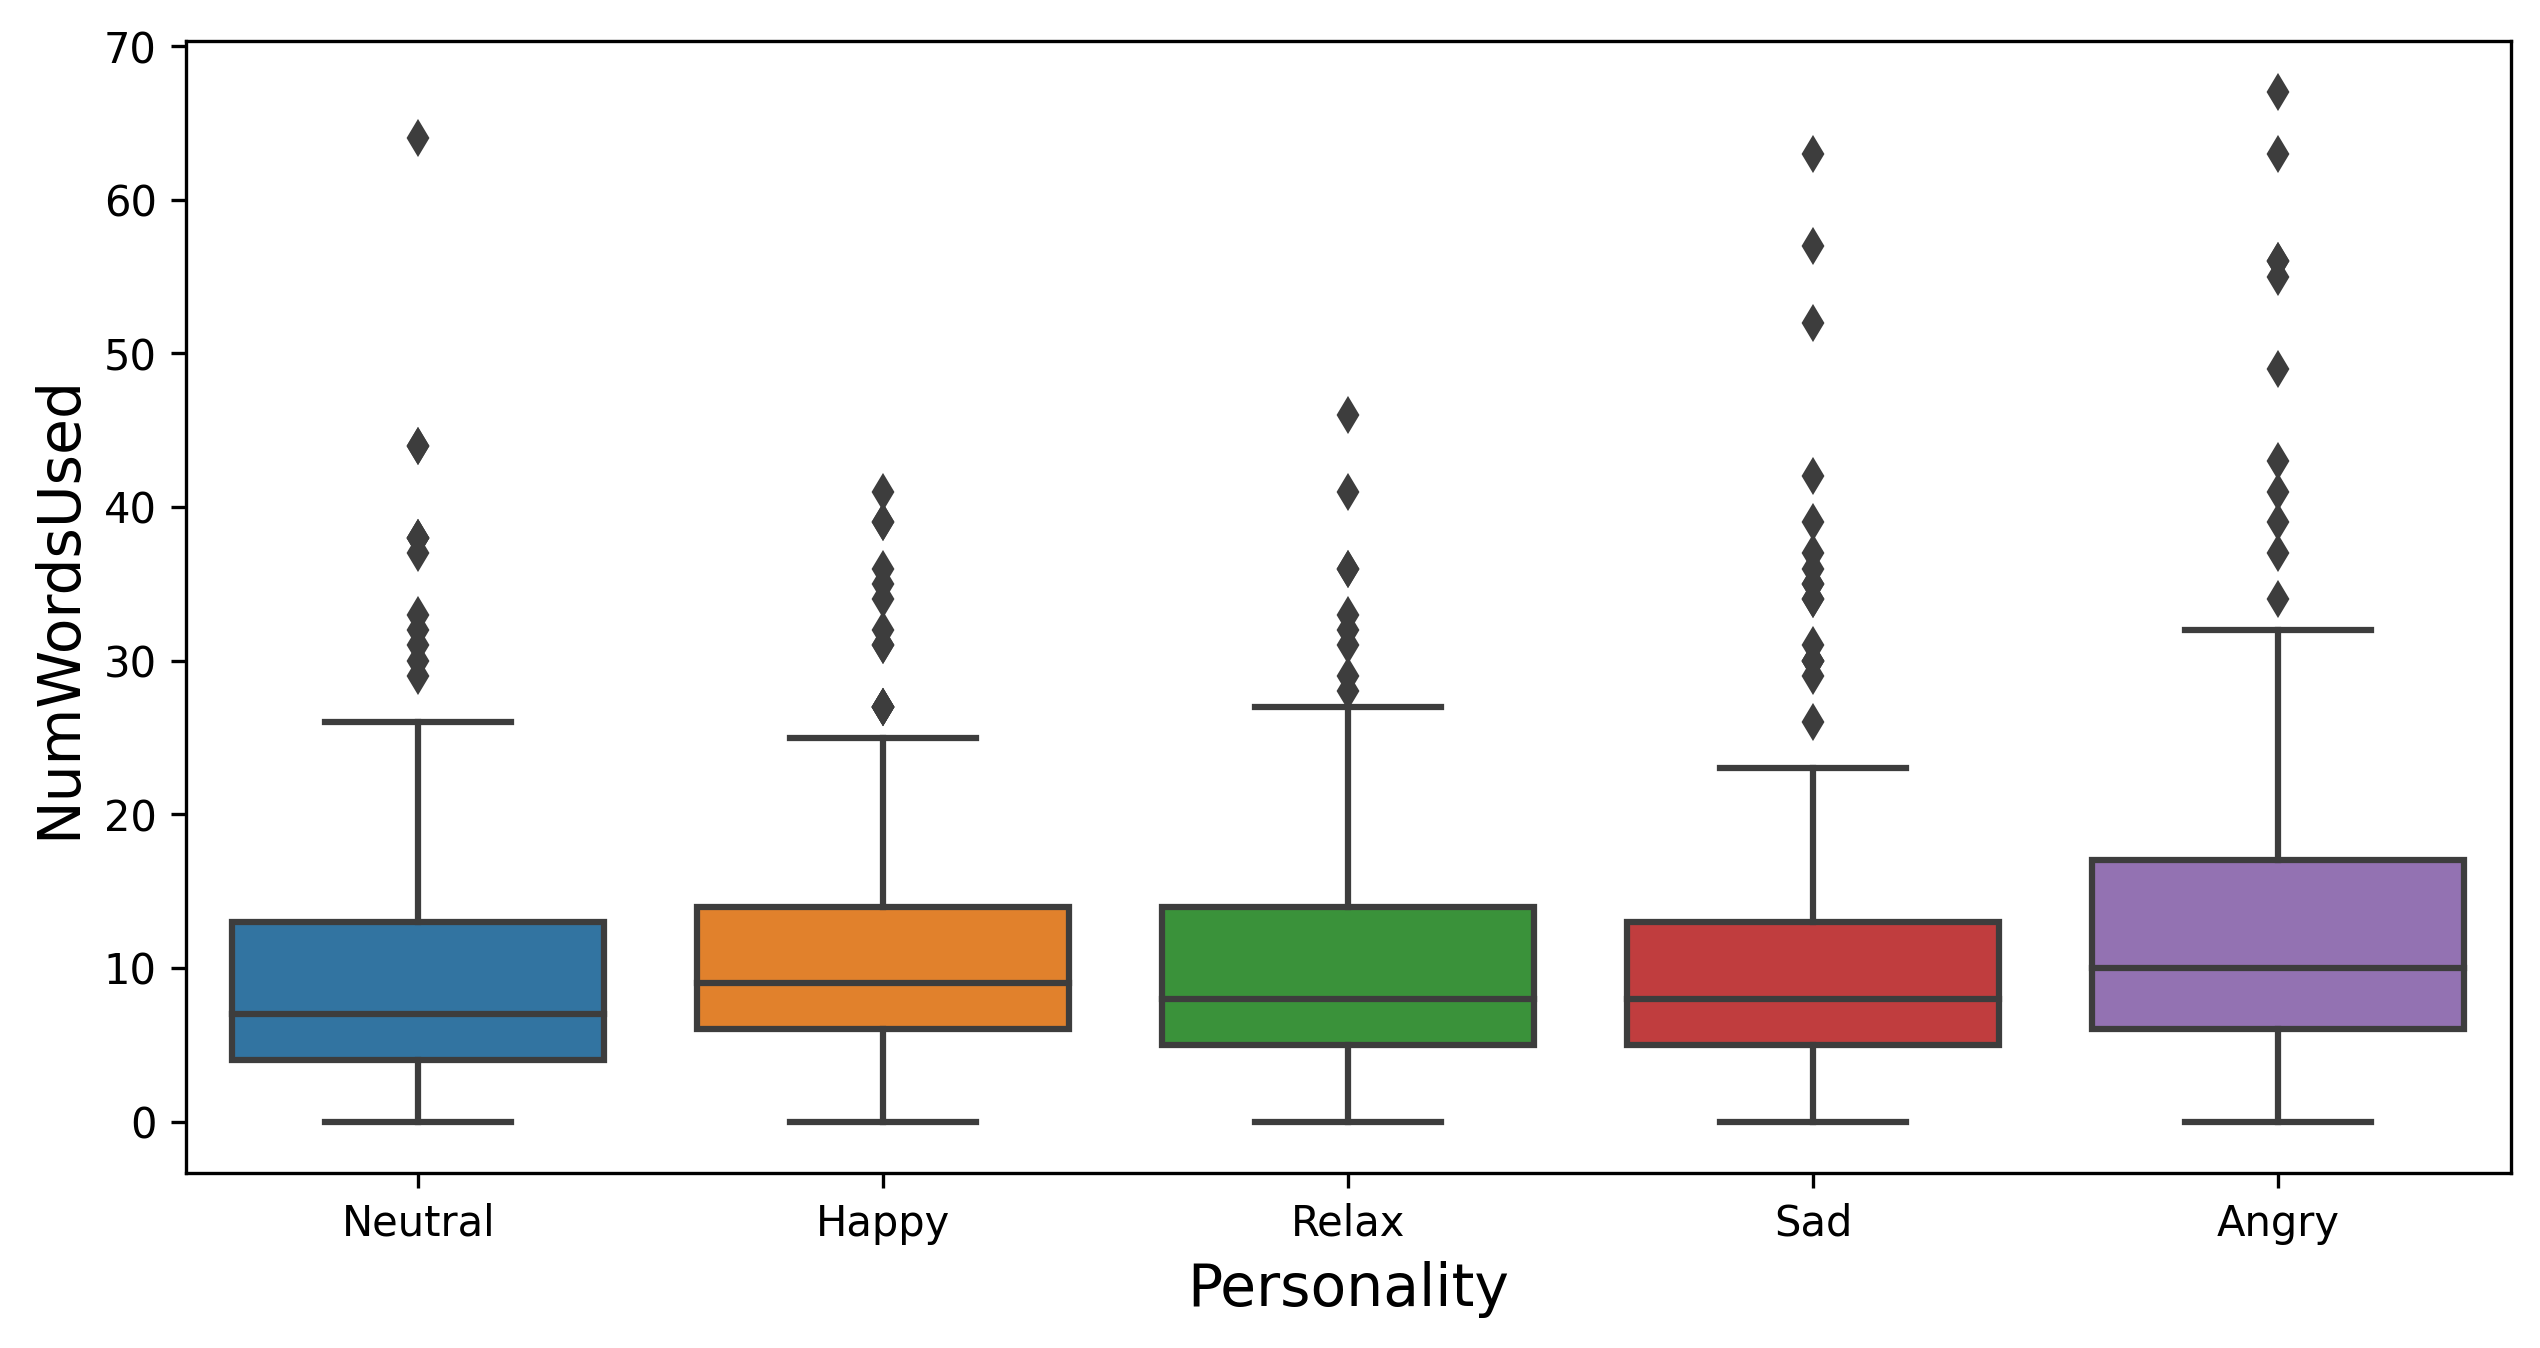

In [40]:
df_to_plot = df_met_by_sent[df_met_by_sent["Source"] == "Person"]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

P-value 0.17573642525617825 with significance -


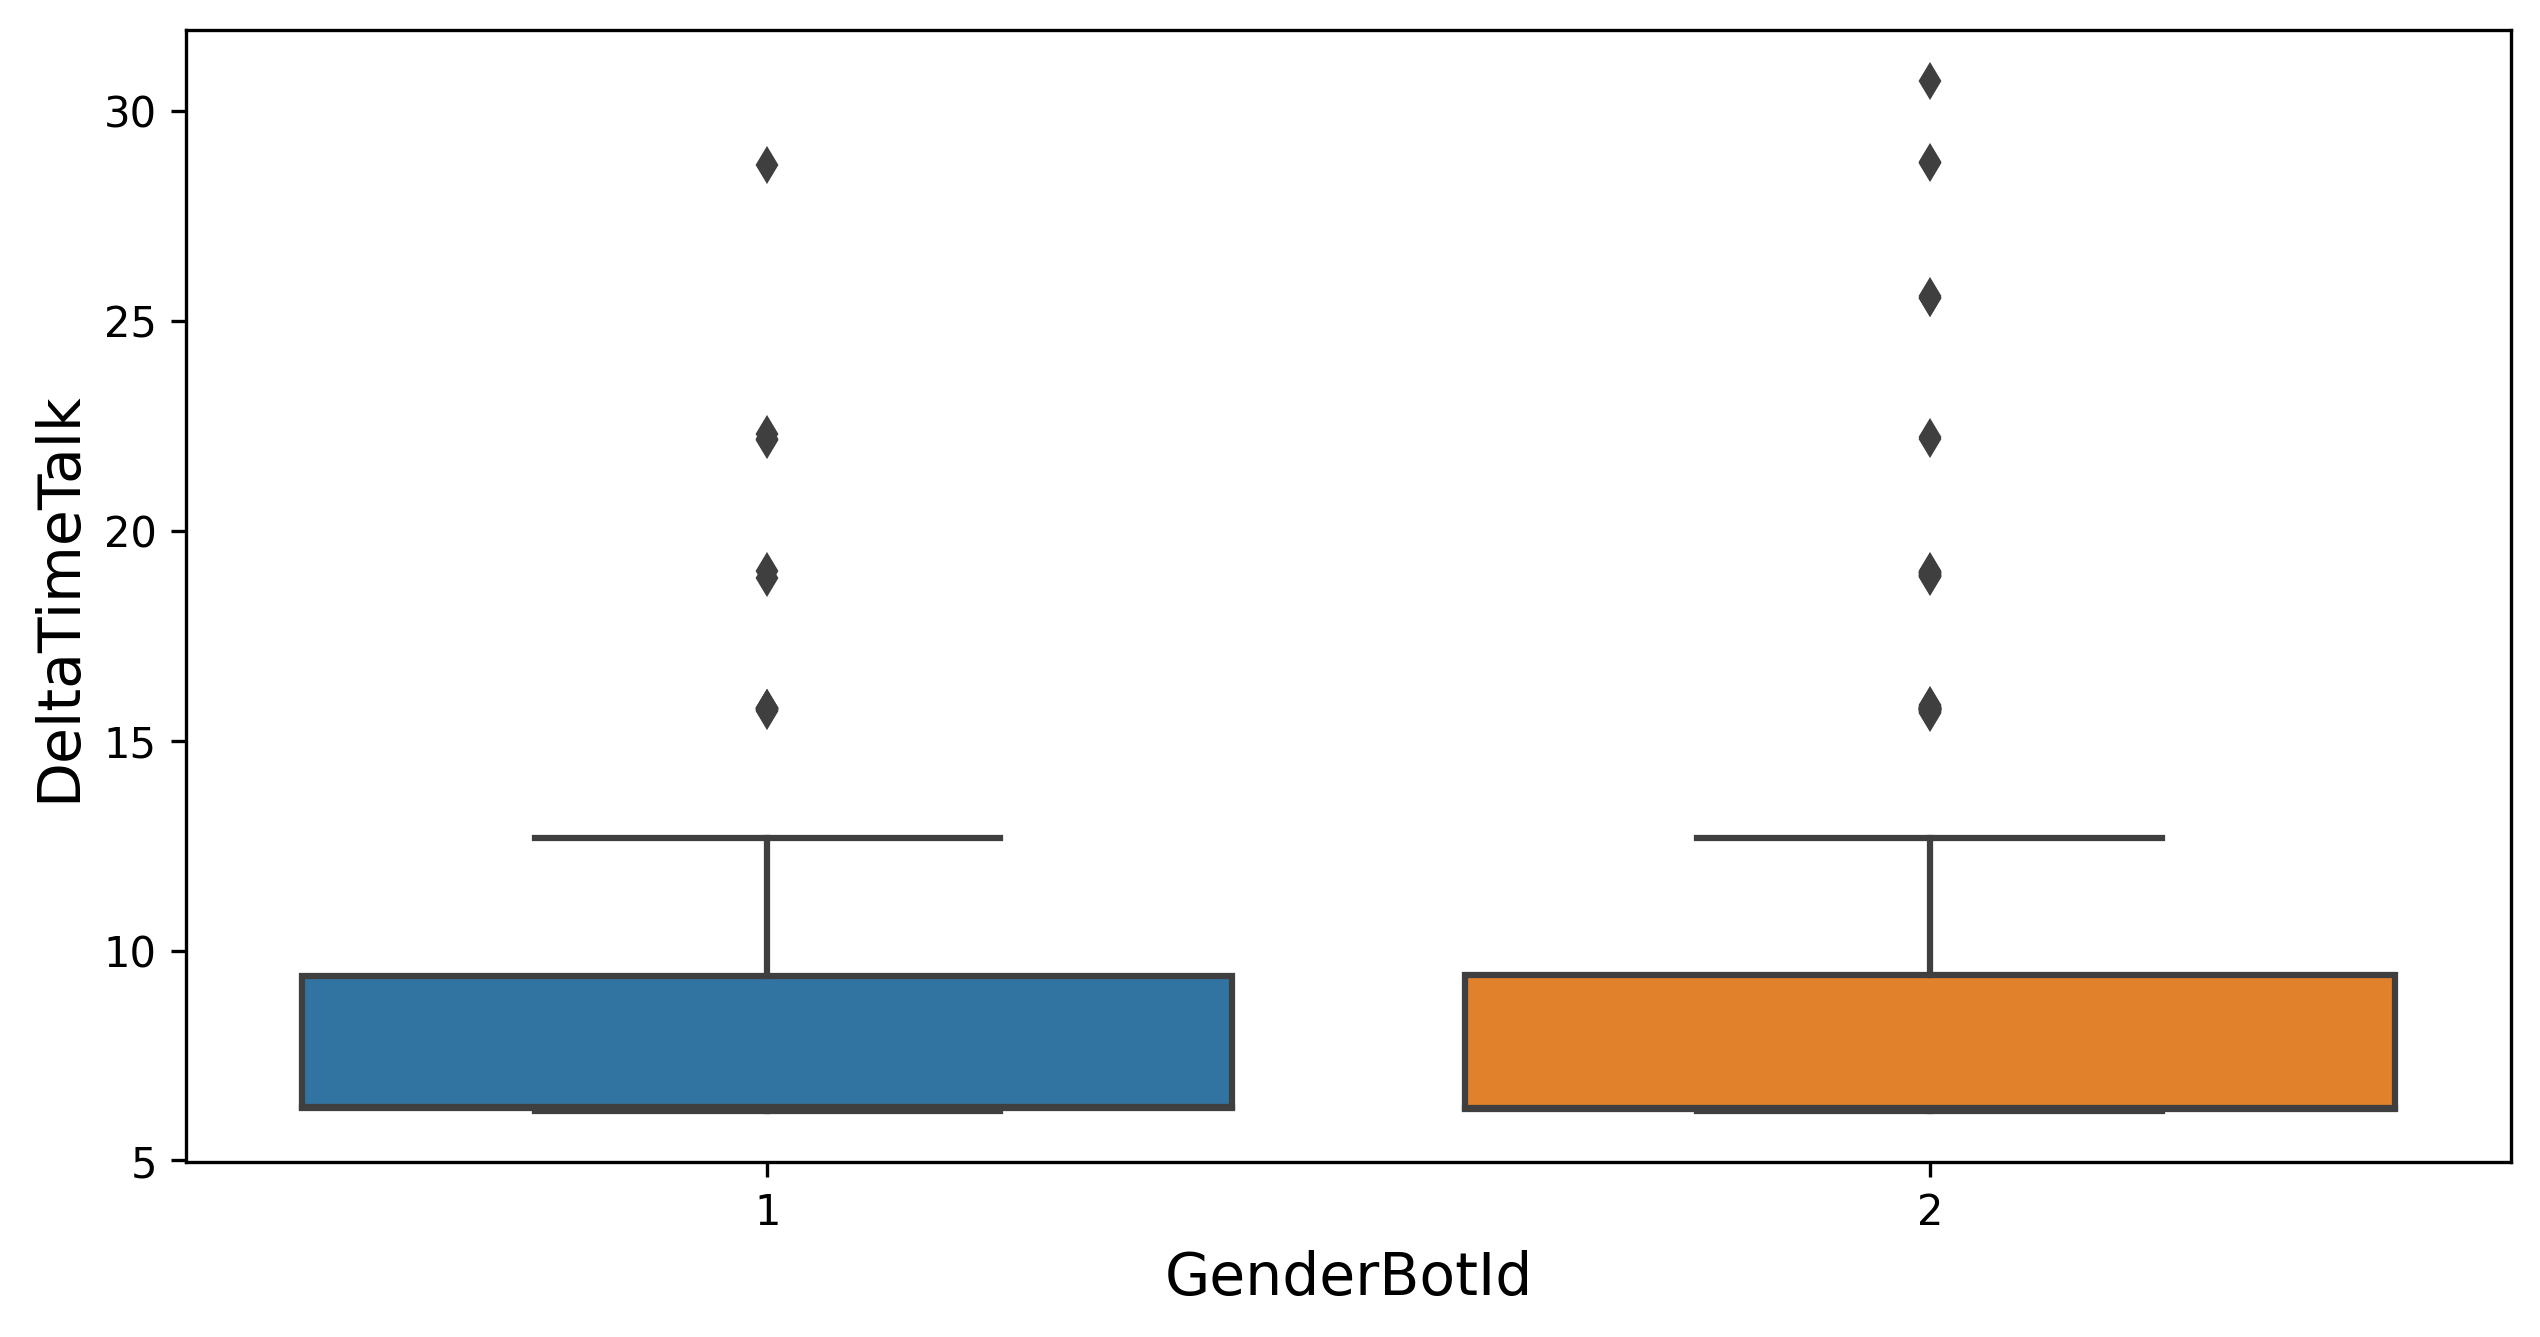

P-value 0.42382006883703294 with significance -


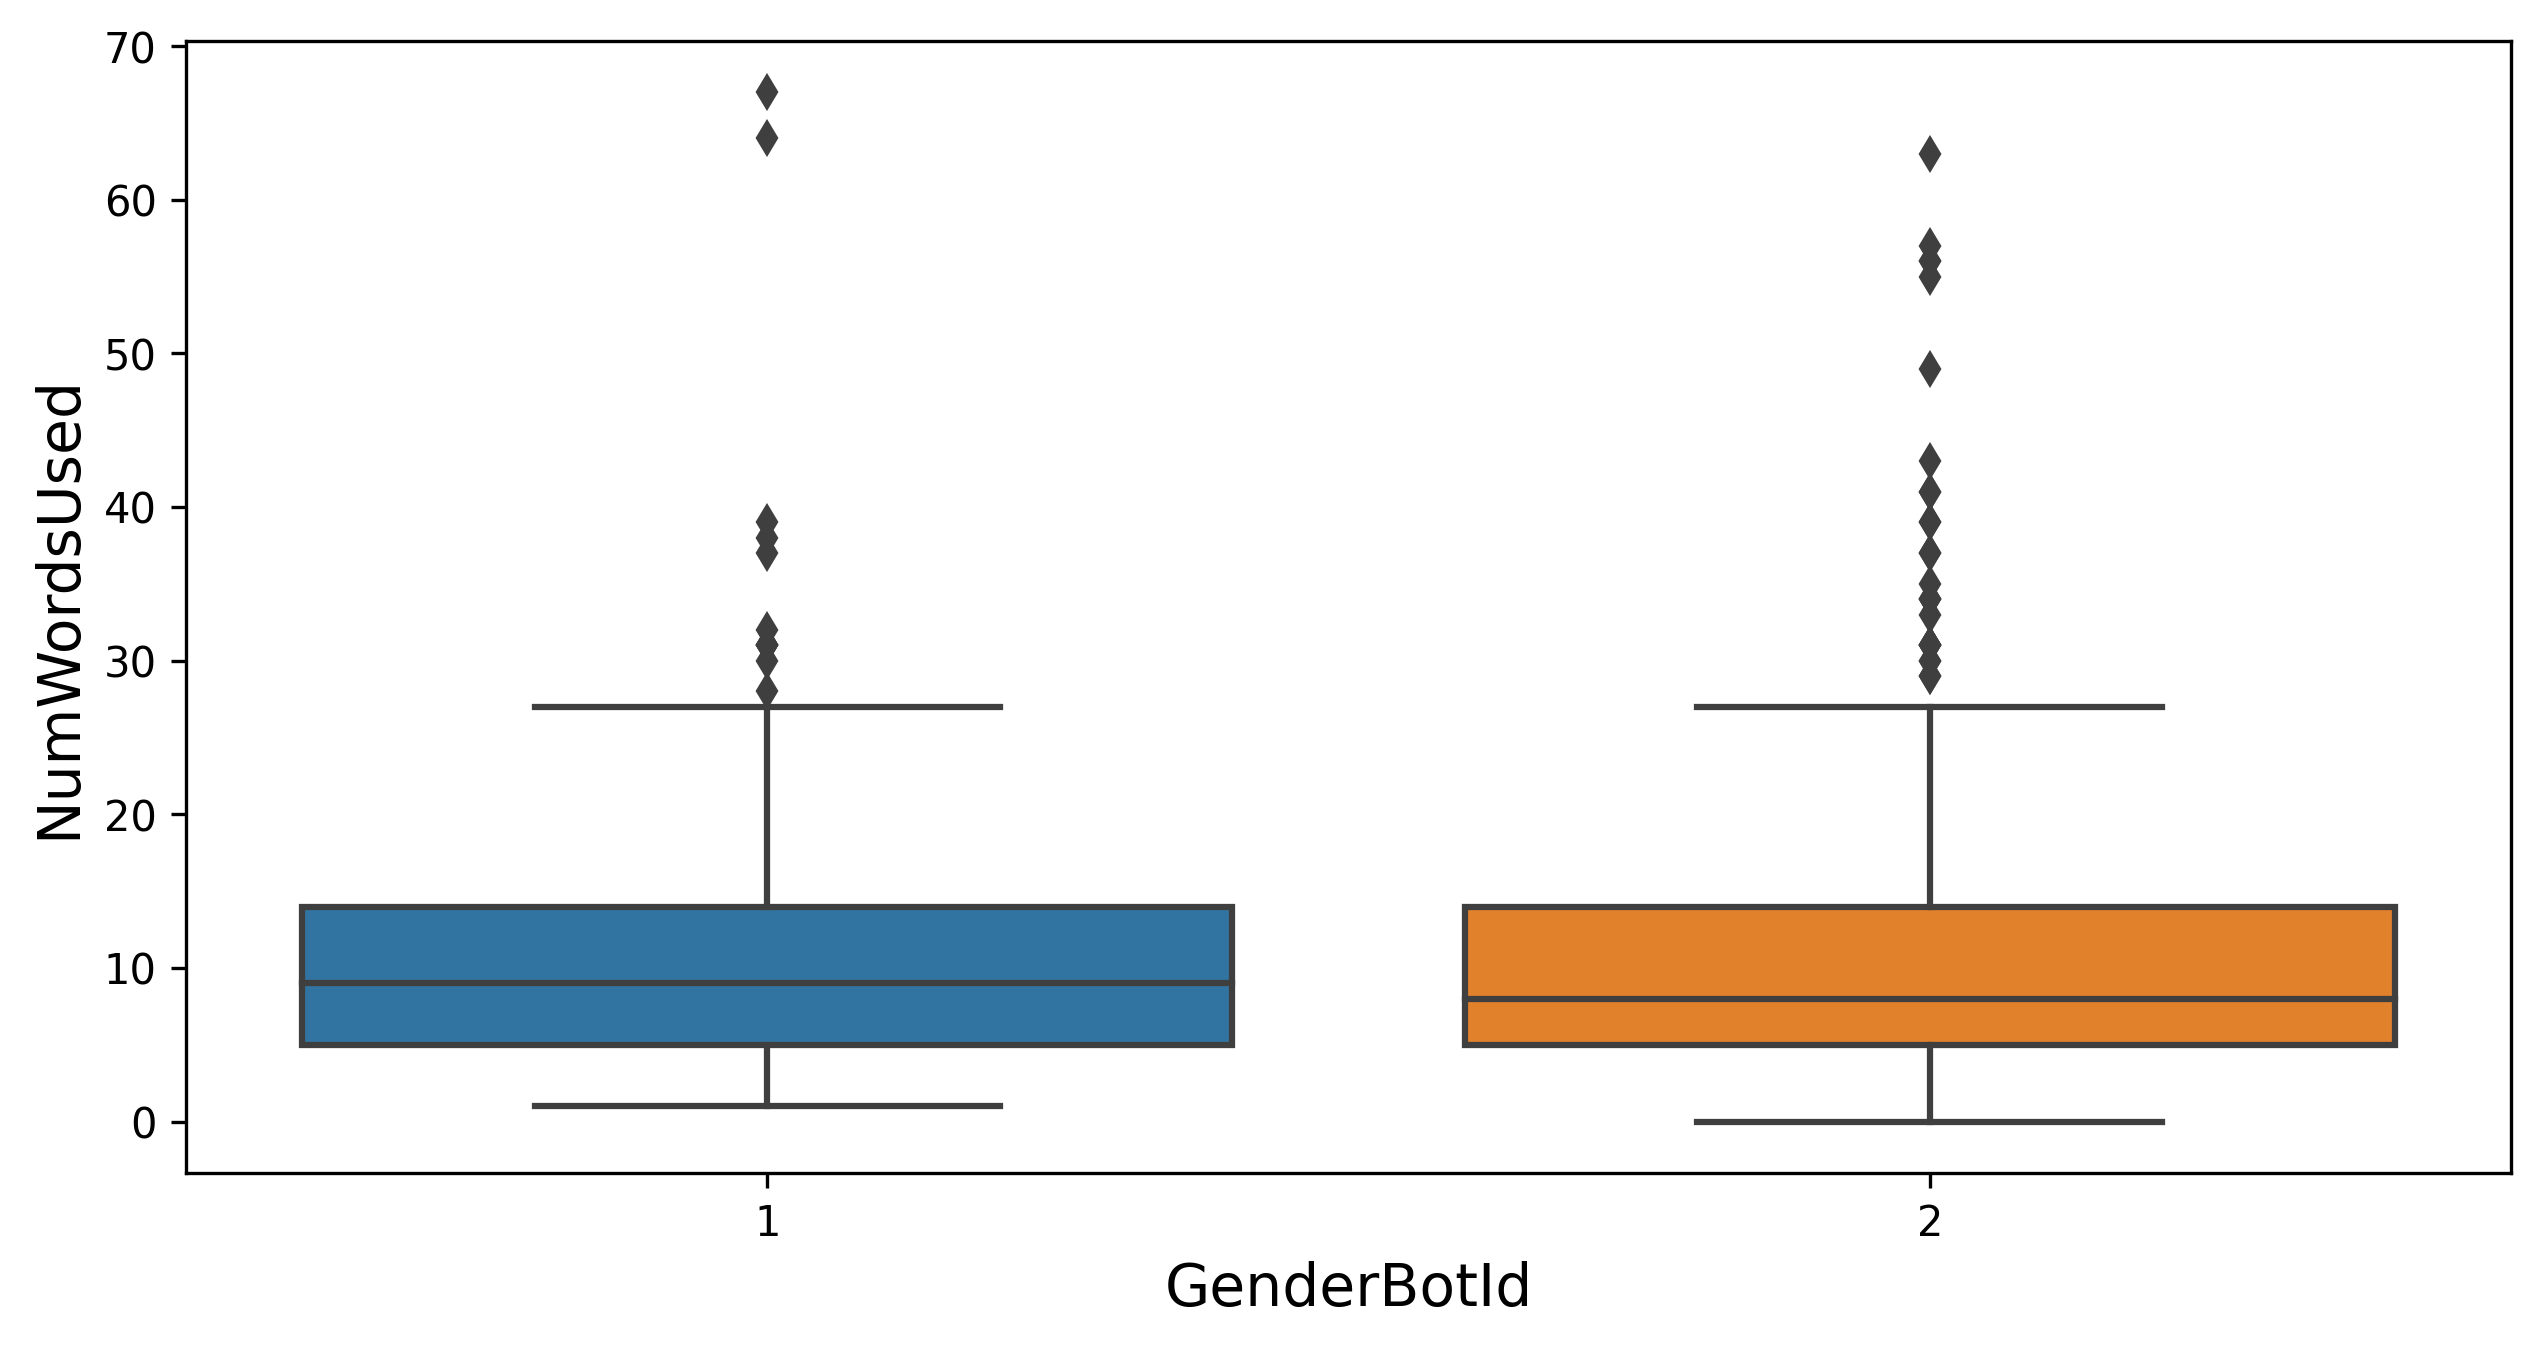

P-value 0.512505700890421 with significance -


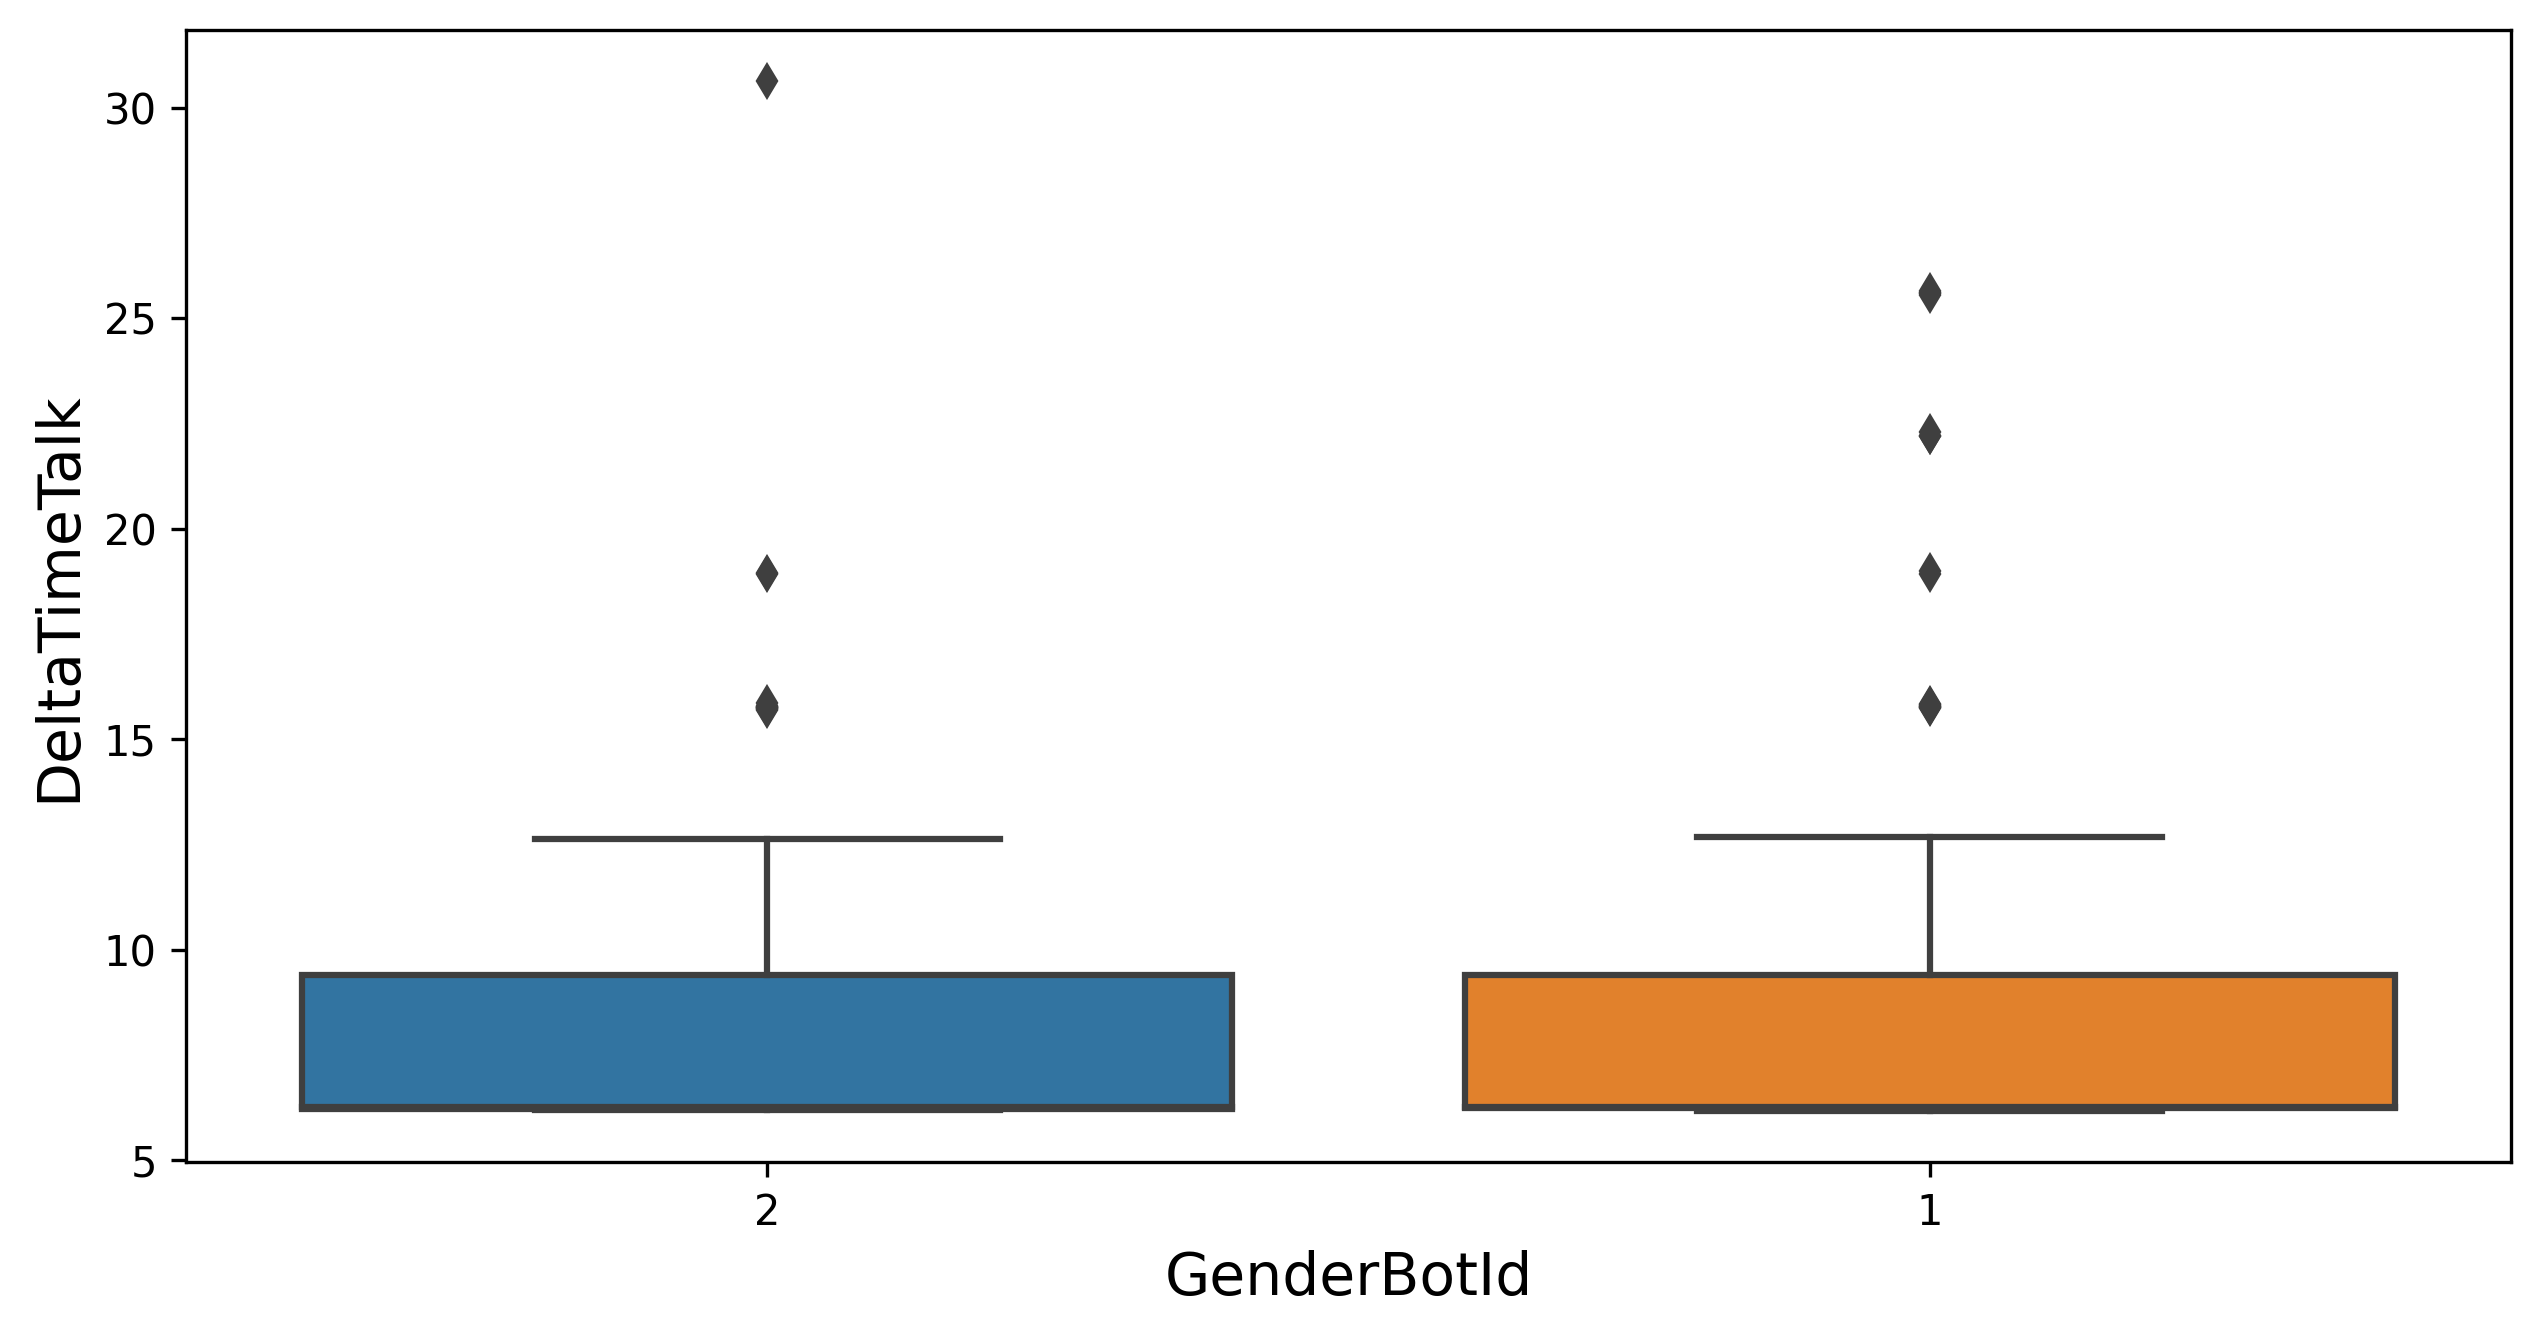

P-value 0.5157130388179365 with significance -


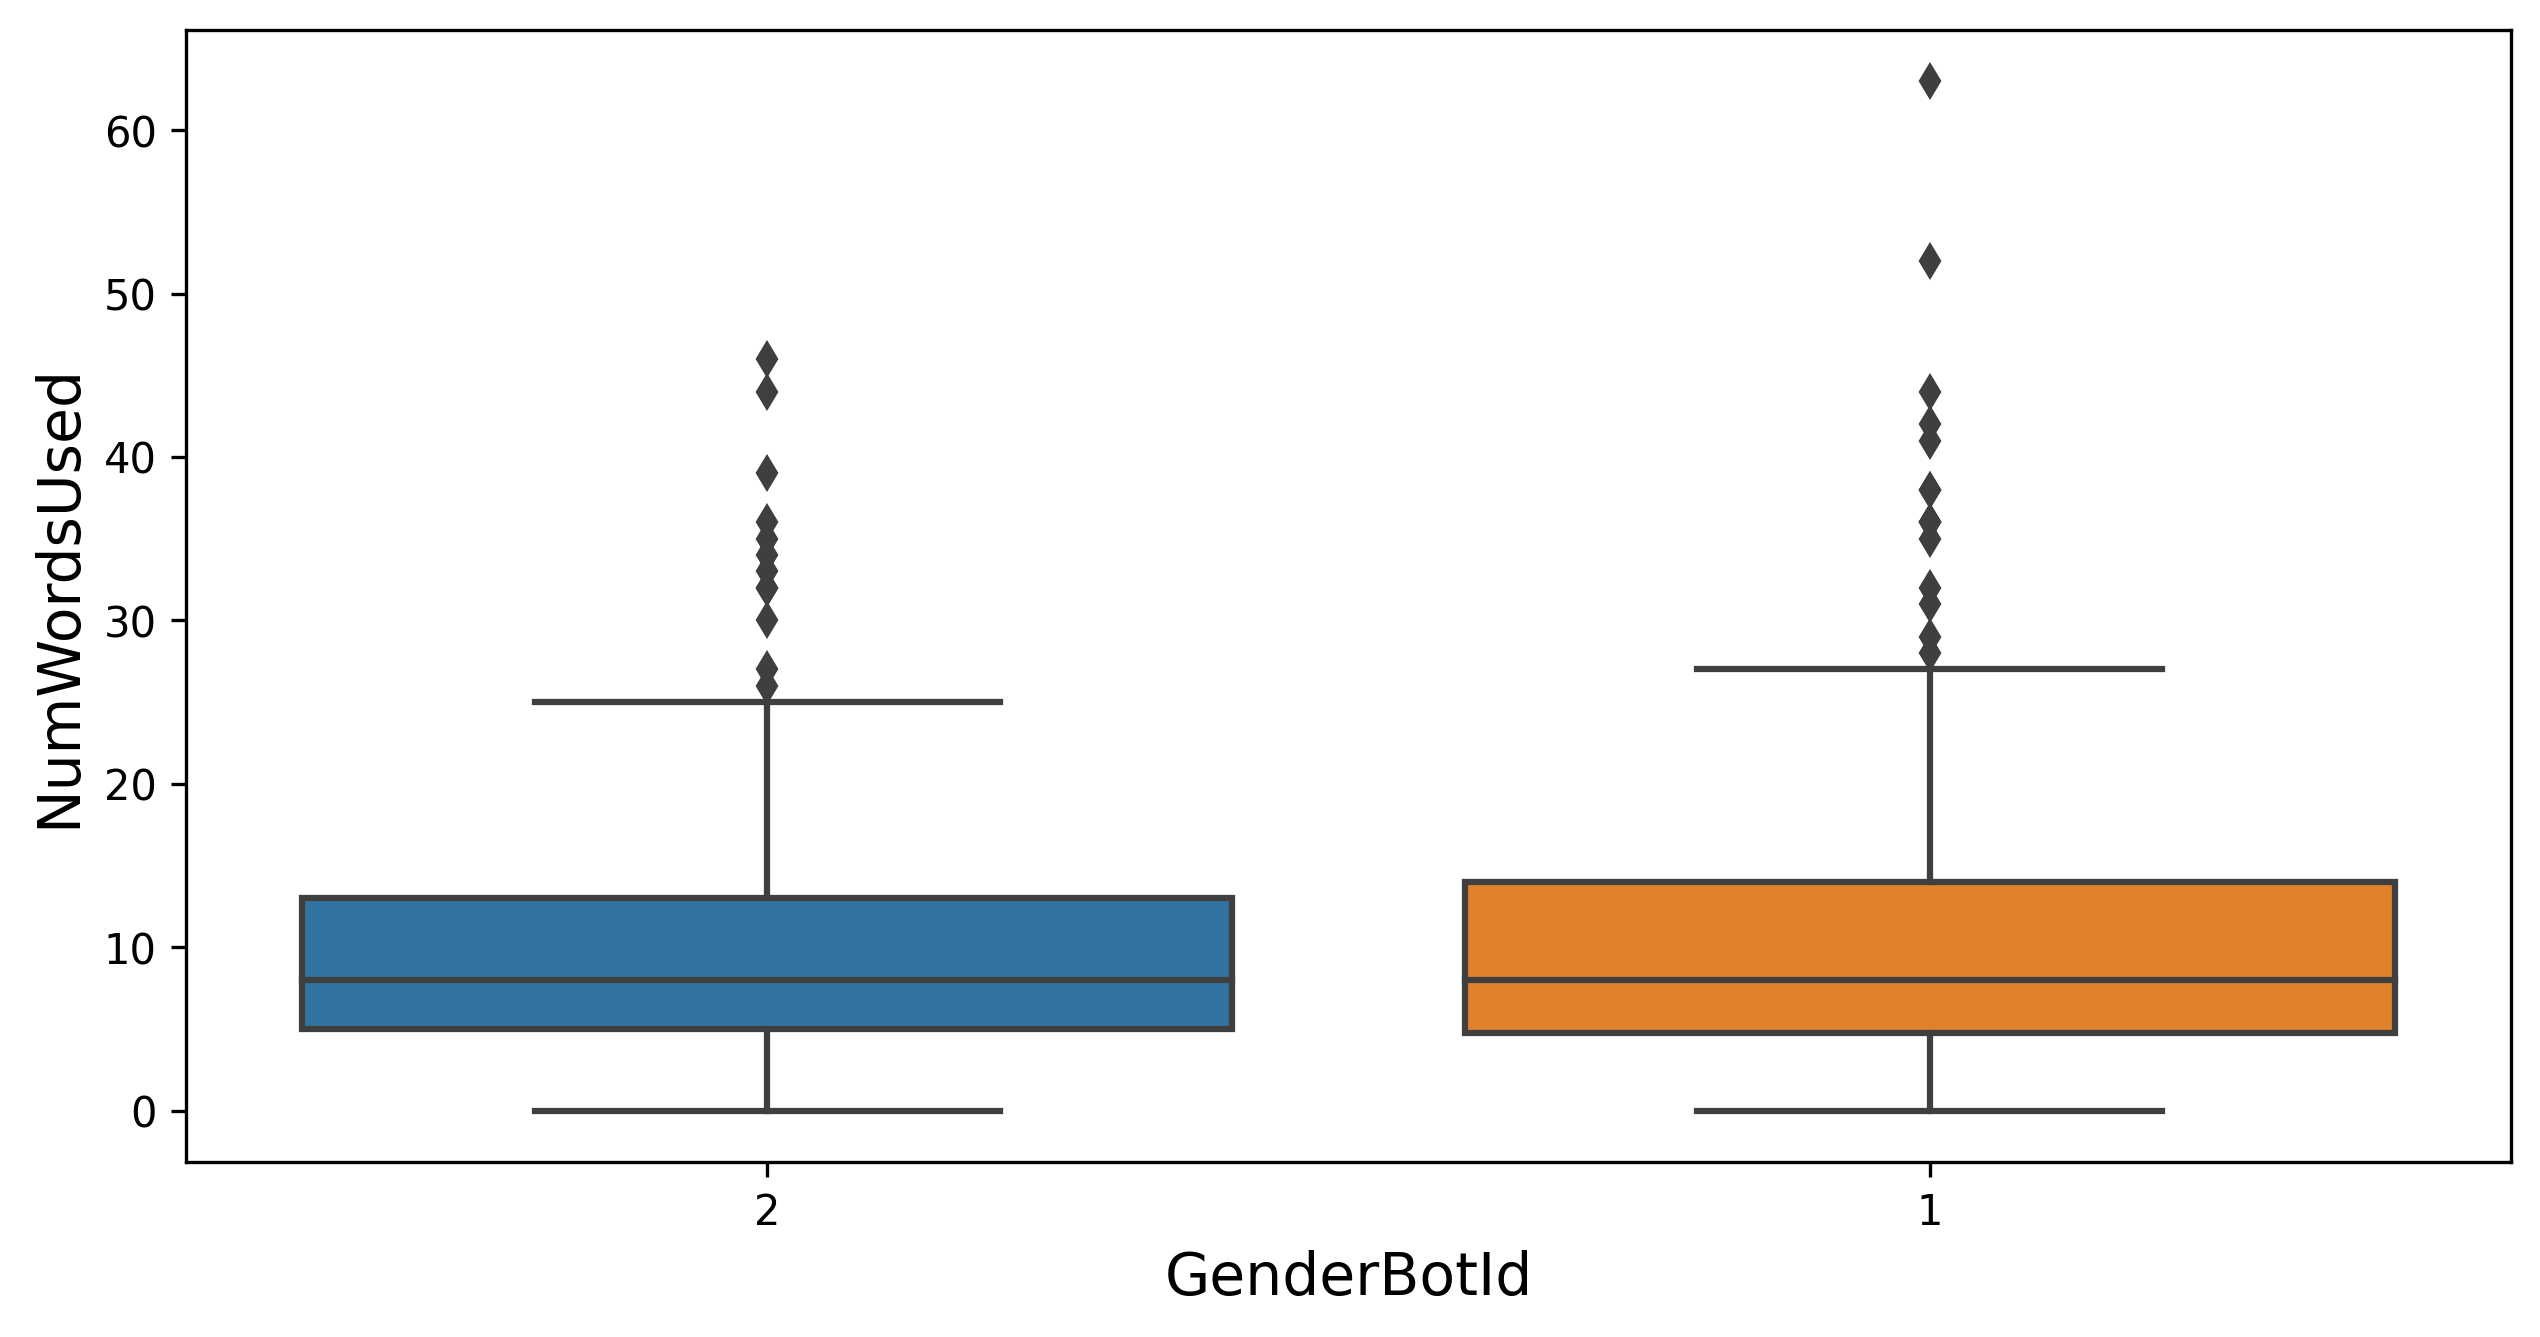

In [41]:
df_to_plot = df_met_by_sent[(df_met_by_sent["Source"] == "Person") & (df_met_by_sent["Gender"] == "Man")]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

# -------------------------------------------------------------------------------

df_to_plot = df_met_by_sent[(df_met_by_sent["Source"] == "Person") & (df_met_by_sent["Gender"] == "Woman")]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

### Studying Avatar

P-value 4.163752898993573e-19 with significance ***


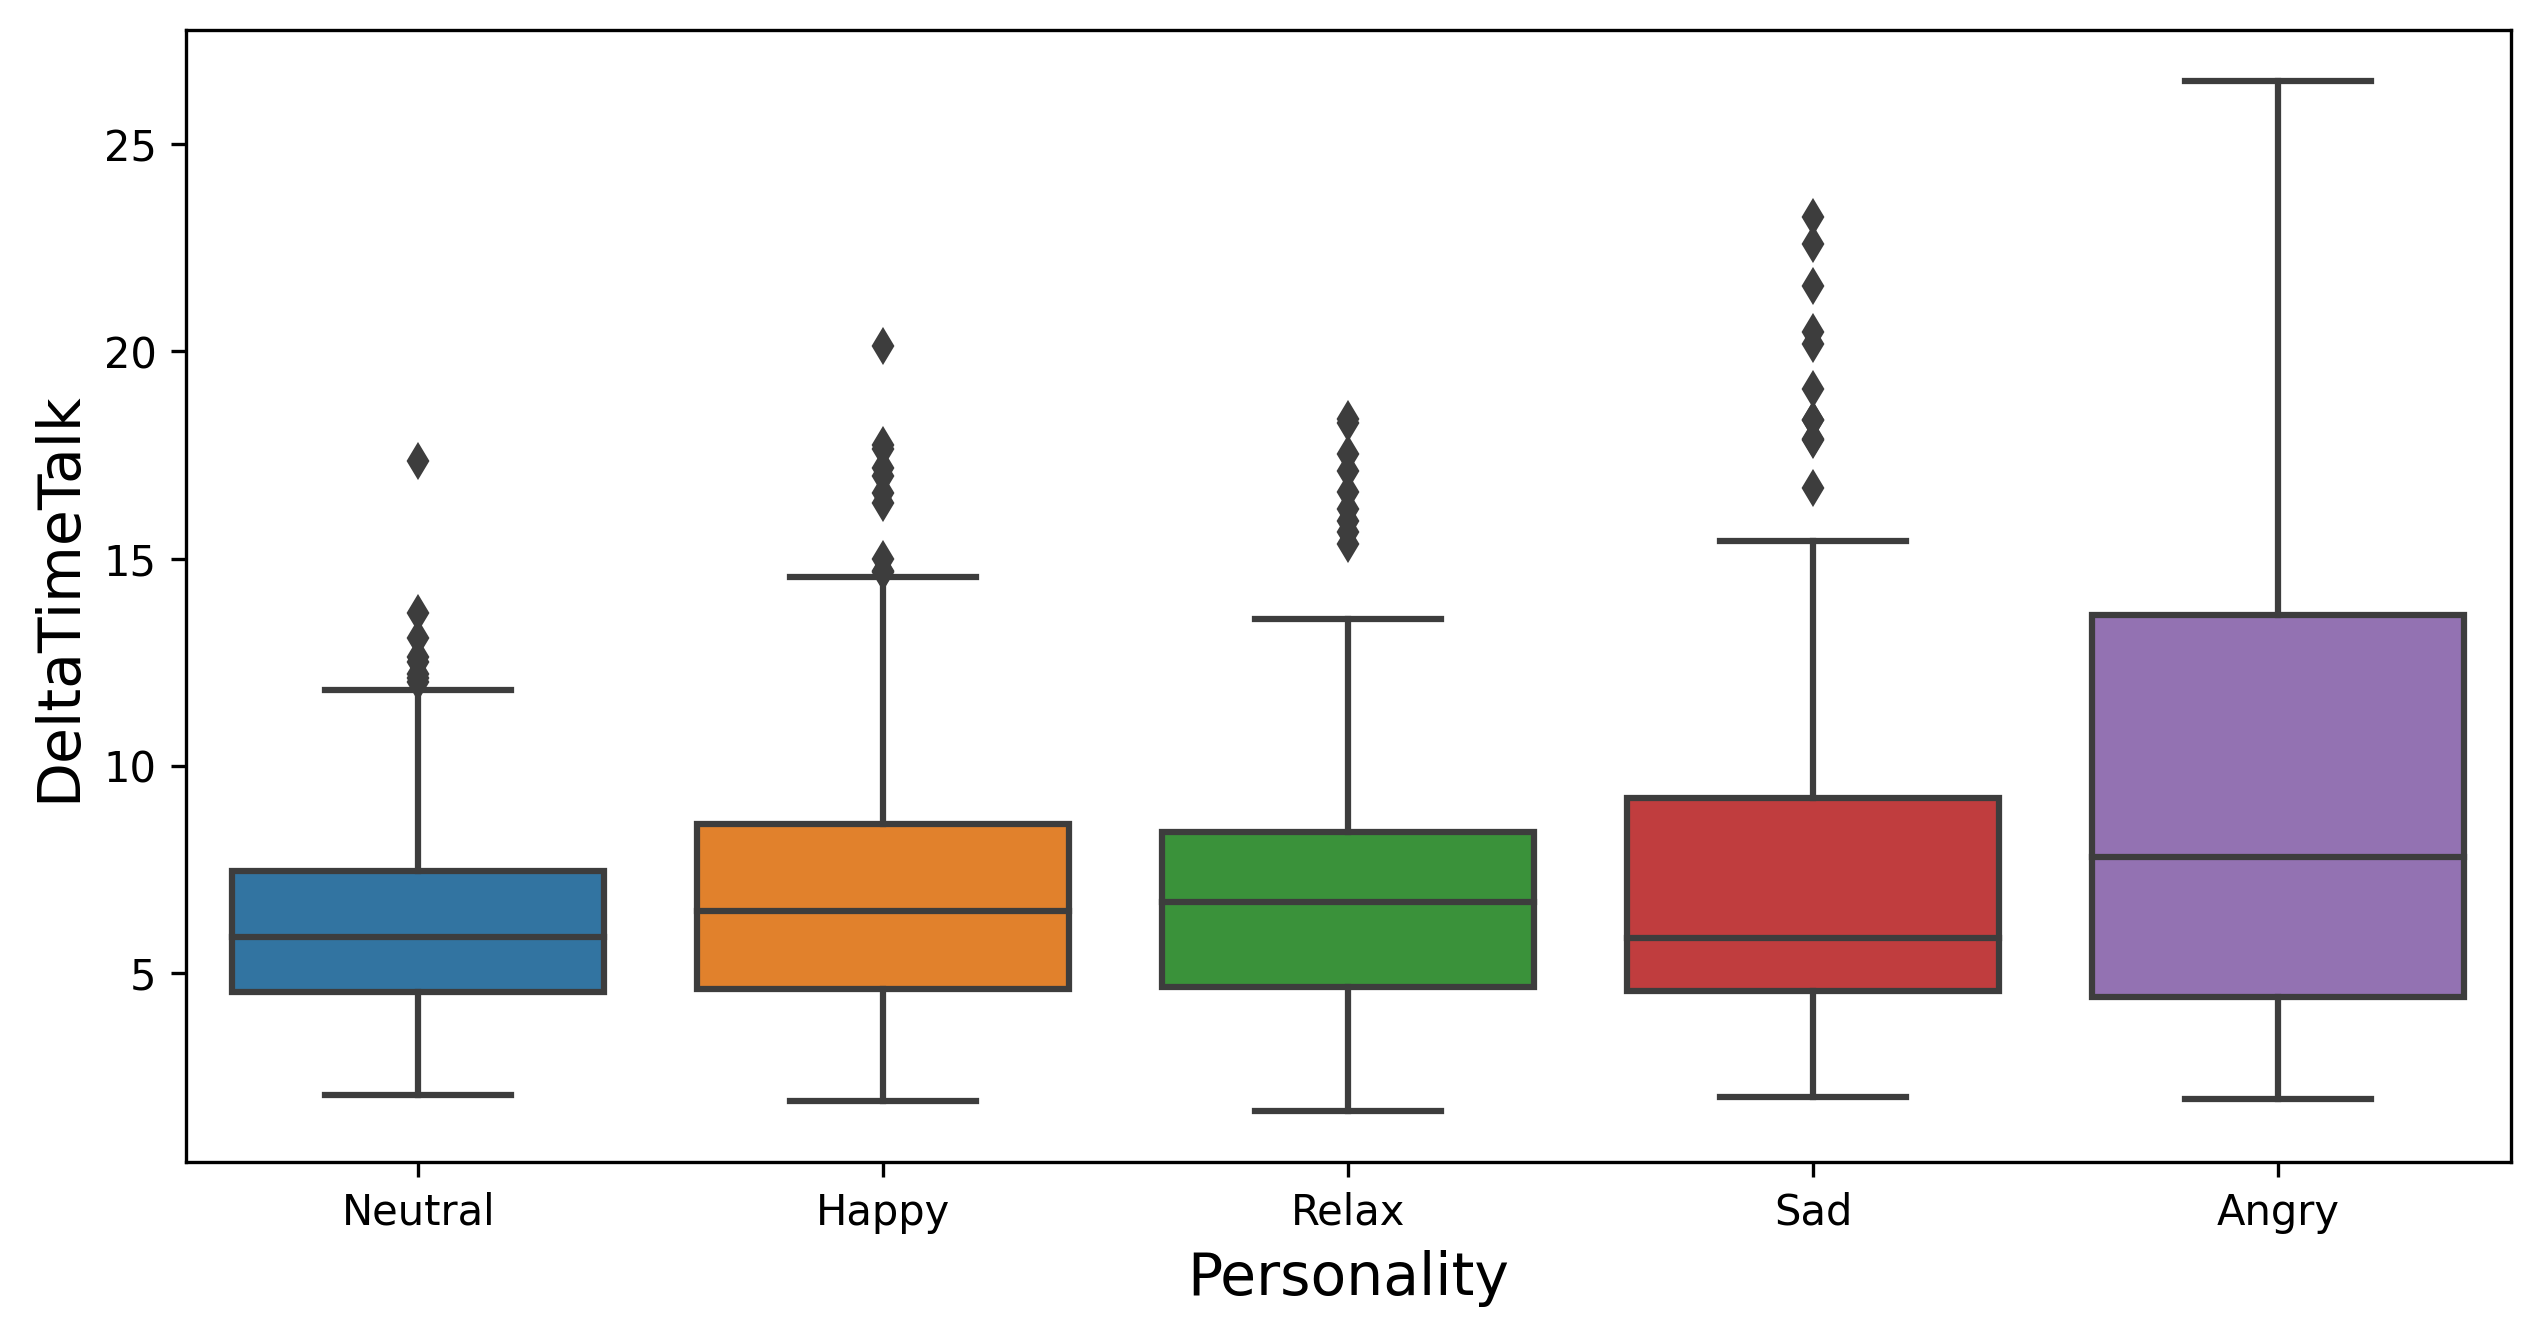

P-value 1.3410955634366998e-23 with significance ***


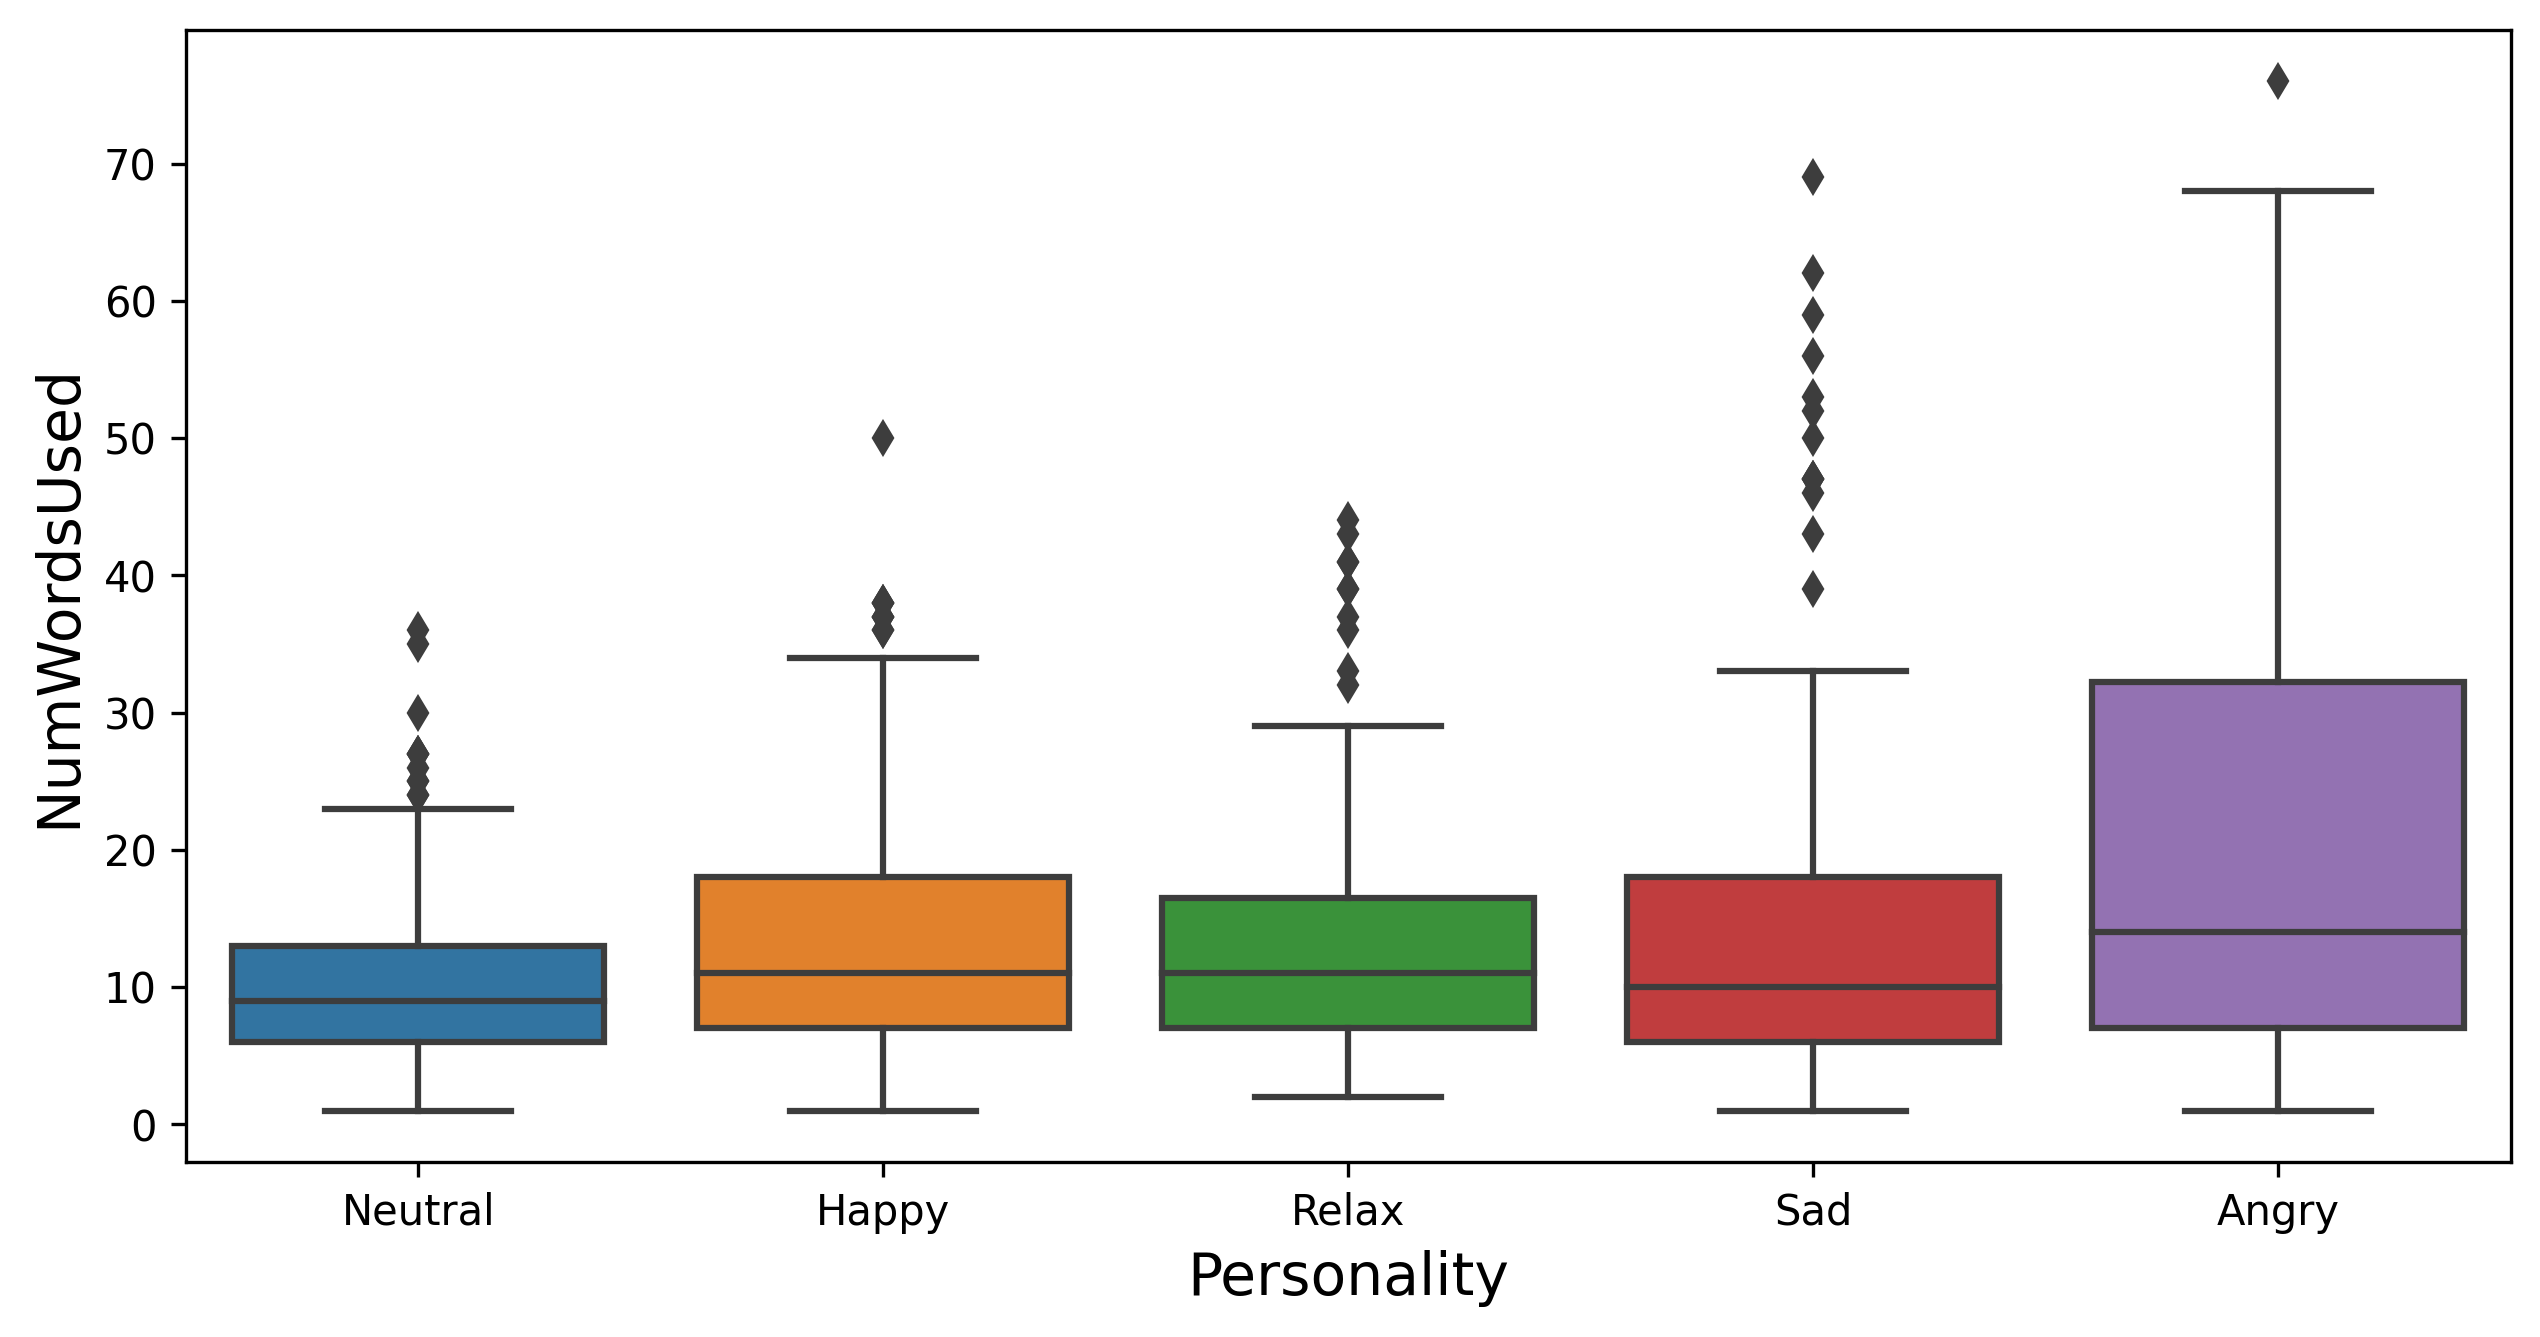

In [42]:
df_to_plot = df_met_by_sent[df_met_by_sent["Source"] == "Bot"]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

### Is Neutral different from the other four personalities ?

In [43]:
df_neut = df_save.copy()

In [44]:
df_neut["NeutralBool"] = (df_neut["BotPersonality"] == "Neutral")*1

In [45]:
df_neut.columns

Index(['SubjectId', 'ConfigName', 'BotPersonality', 'FirstDate', 'LastDate',
       'ConvTime_s', 'AboveMaximumTime', 'NumConv', 'NumSamples',
       'AllTextClean', 'AllNumUniqWordsClean', 'AllNumUniqWords',
       'AllOriginalText', 'AllNumWords', 'AllNumWordsClean', 'AllNumQuestions',
       'BotTextClean', 'BotNumUniqWordsClean', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotNumWordsClean', 'BotNumQuestions',
       'Mean_OpenAI', 'Max_OpenAI', 'Min_OpenAI', 'Diff_OpenAI', 'Mean_AWS',
       'Max_AWS', 'Min_AWS', 'Diff_AWS', 'Mean_BotTalk', 'Max_BotTalk',
       'Min_BotTalk', 'Diff_BotTalk', 'PersonTextClean',
       'PersonNumUniqWordsClean', 'PersonNumUniqWords', 'PersonOriginalText',
       'PersonNumWords', 'PersonNumWordsClean', 'PersonNumQuestions',
       'Mean_PersonTalk', 'Max_PersonTalk', 'Min_PersonTalk',
       'Diff_PersonTalk', 'NeutralBool'],
      dtype='object')

In [46]:
df_neut.head(5)

,SubjectId,ConfigName,BotPersonality,FirstDate,LastDate,ConvTime_s,AboveMaximumTime,NumConv,NumSamples,AllTextClean,...,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonNumWordsClean,PersonNumQuestions,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk,NeutralBool
0,User_01_CB,Neutral_Female_2,Neutral,1.668588e+09,NaN,163.274568,False,6,13,"hola, nombr laur llam tu. buen jesus. eres, je...",...,57,"buenas yo soy Jesús. yo sí, Valencia y tú. Pue...",105,53,1,10.987555,18.949747,6.200216,-0.023398,1
1,User_01_CB,Neutral_Male_1,Neutral,1.668589e+09,NaN,87.746197,False,4,9,"hola, nombr dav llam tu. buen jesus. hola, jes...",...,31,buenas yo soy Jesús. Encantado mi deporte favo...,50,21,0,7.830935,9.427005,6.227488,3.175351,1
2,User_01_CB,Happy_Woman_1,Happy,1.668589e+09,1.668589e+09,123.356988,False,5,10,"encant conocerte, nombr mari nombre. hol buen ...",...,43,hola buenas yo me llamo Jesús encantado Yo soy...,66,32,0,9.411009,15.750861,6.265236,-3.125580,0
3,User_01_CB,Relax_Man_2,Relax,1.668589e+09,NaN,182.710761,False,7,15,"hola, nombr pabl nombre. hola, llam jesus gust...",...,60,"Hola, yo me llamo Jesús te gusta la playa, qué...",106,49,2,9.390276,15.737232,6.210278,3.124682,0
4,User_01_CB,Sad_Woman_2,Sad,1.668590e+09,NaN,138.772165,False,8,17,"hola, llam sar tu. hola, sar jesus hac buen di...",...,43,"Hola, Sara yo soy Jesús hace un buen día, no?....",70,34,1,7.026681,9.435585,6.209277,0.030921,0


P-value 0.5563012019733558 with significance -


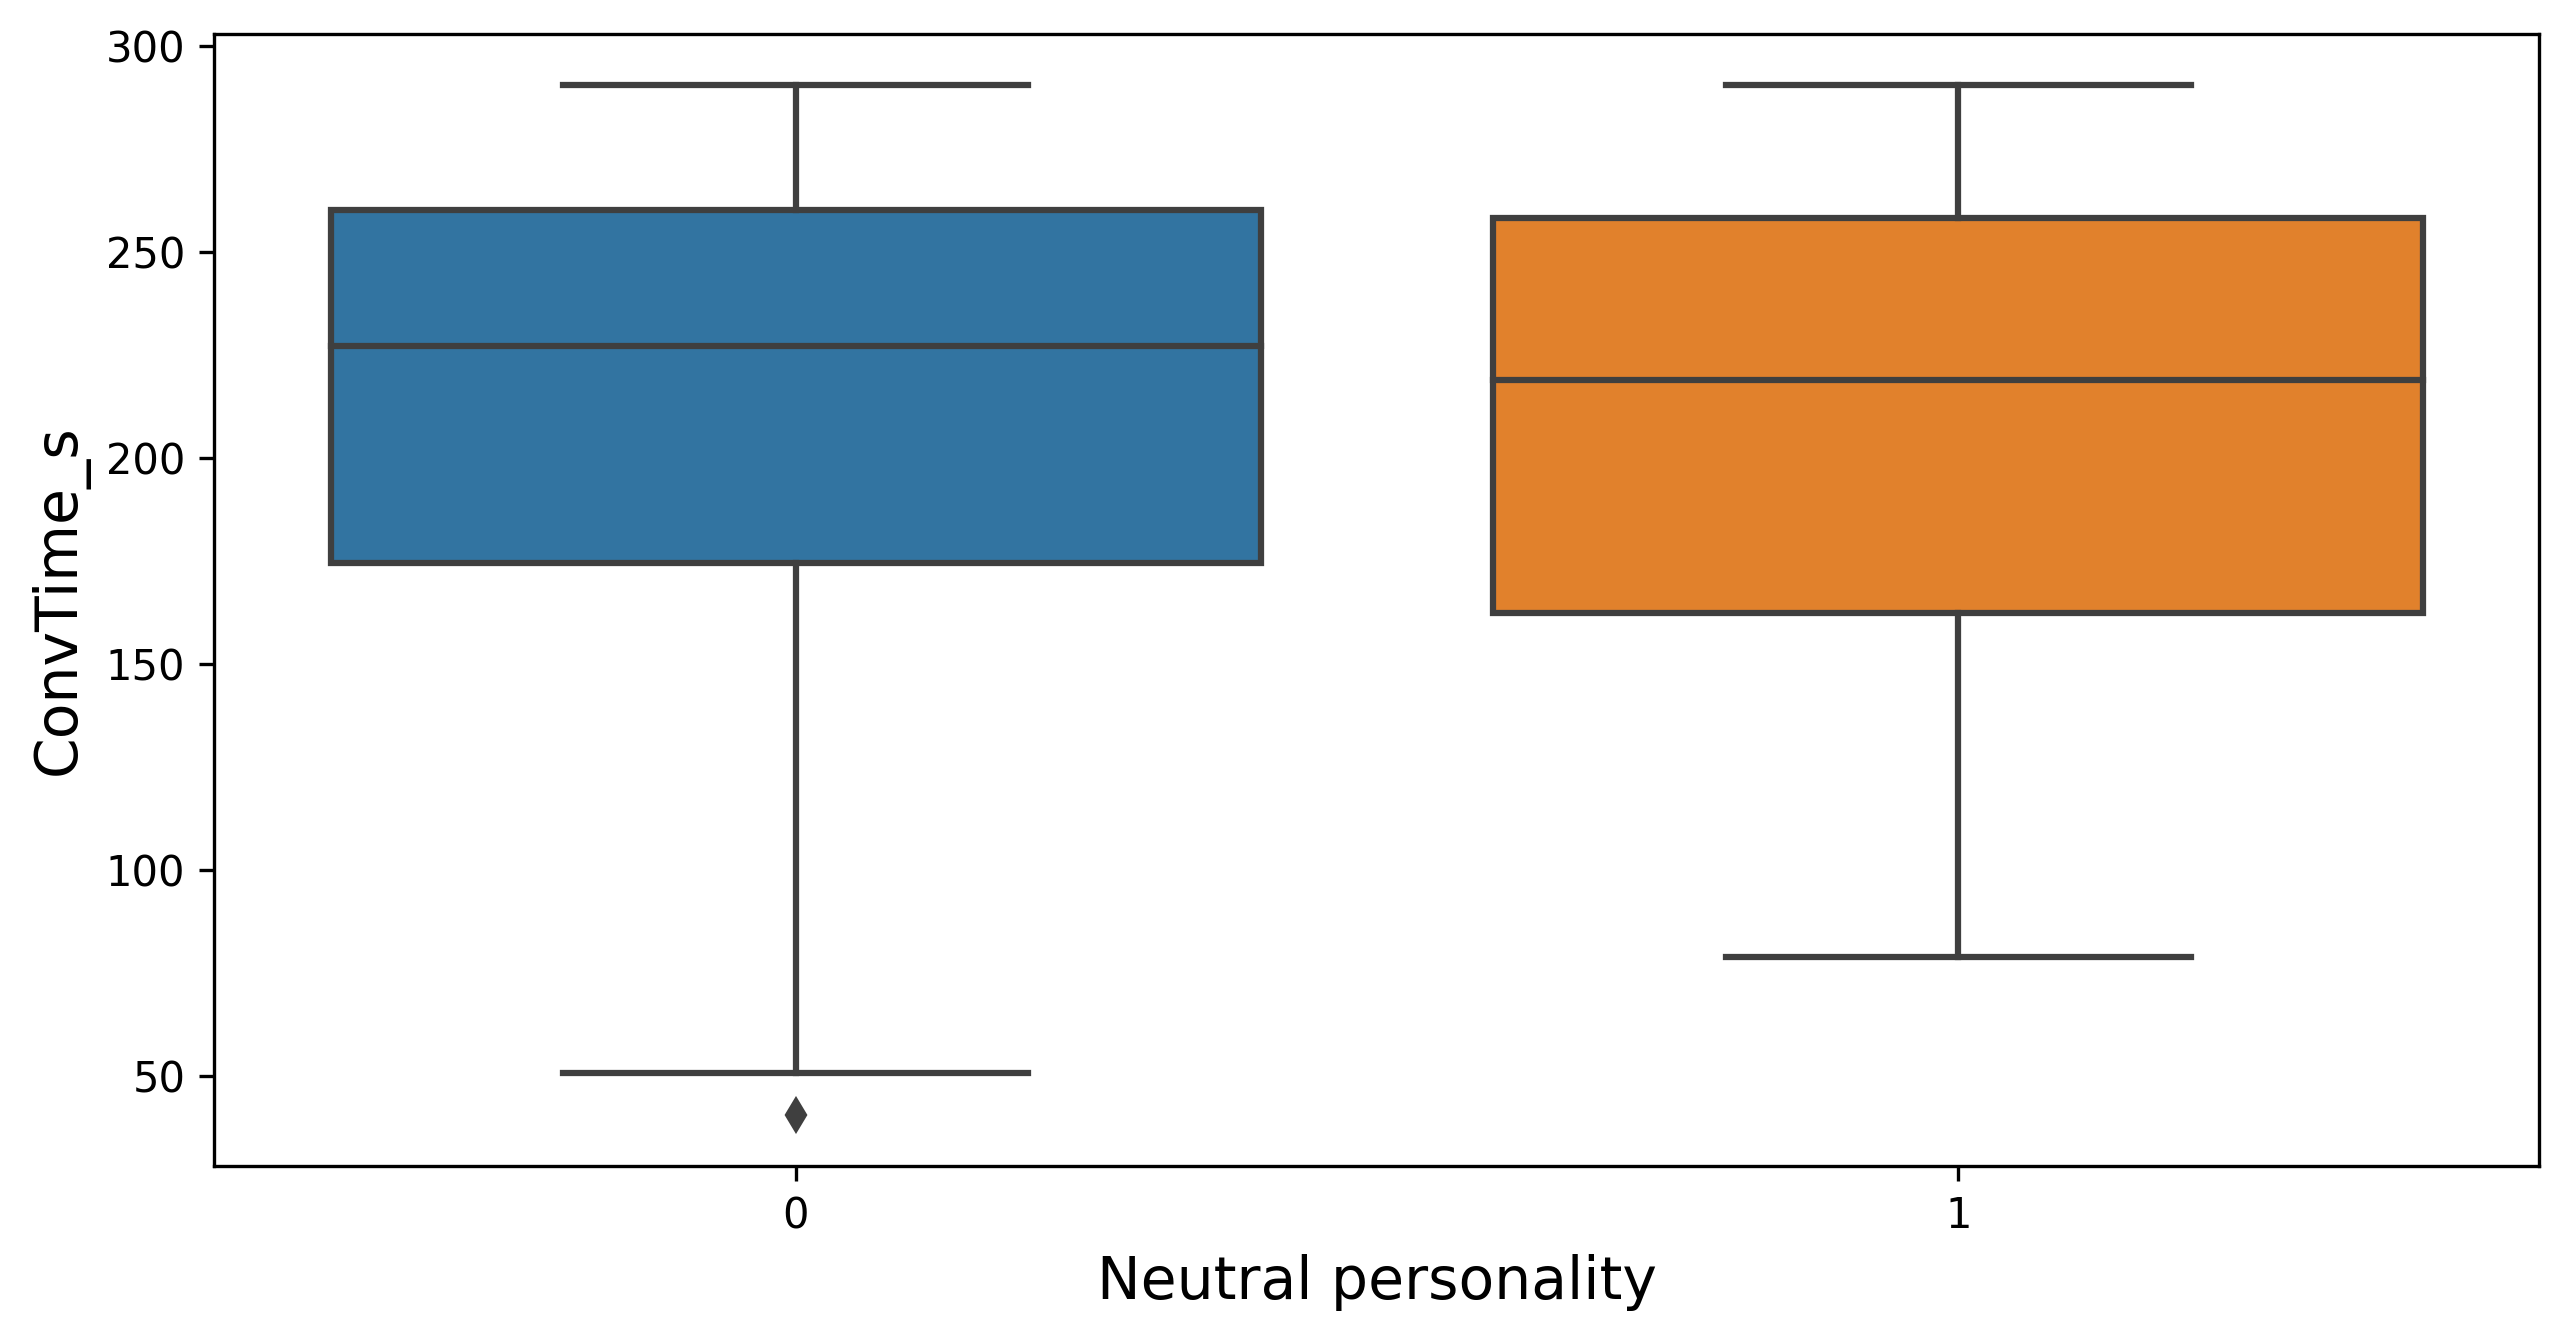

P-value 0.1547028636266281 with significance -


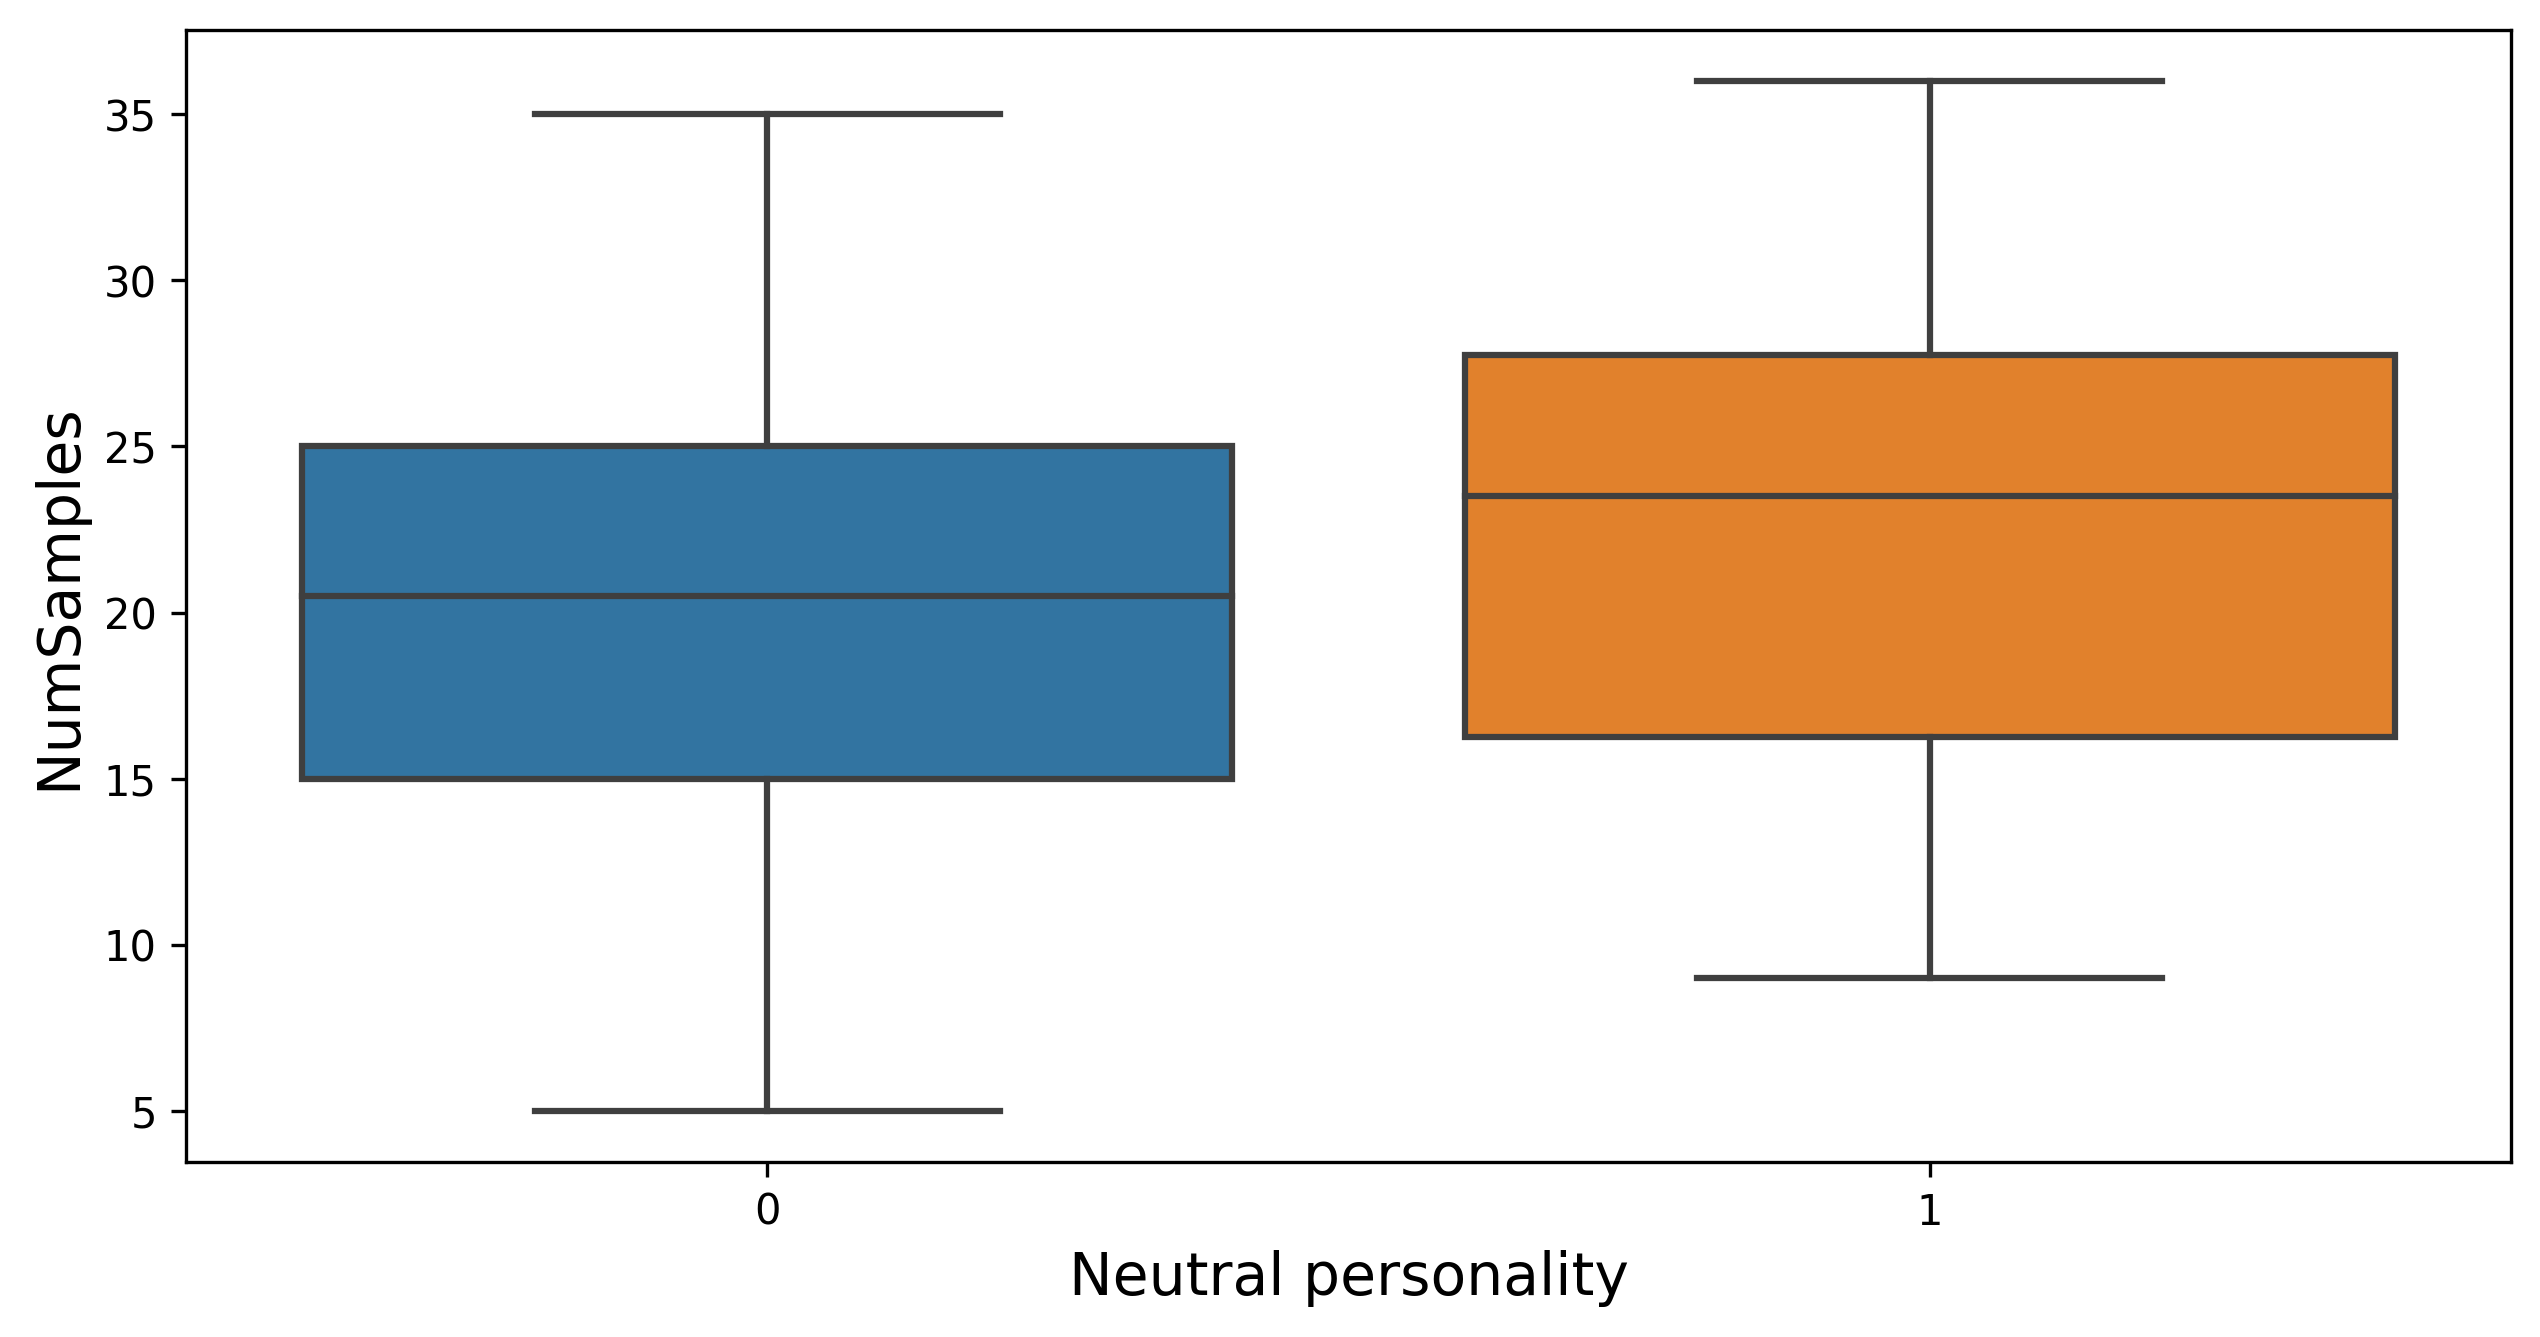

P-value 0.09927061606428281 with significance -


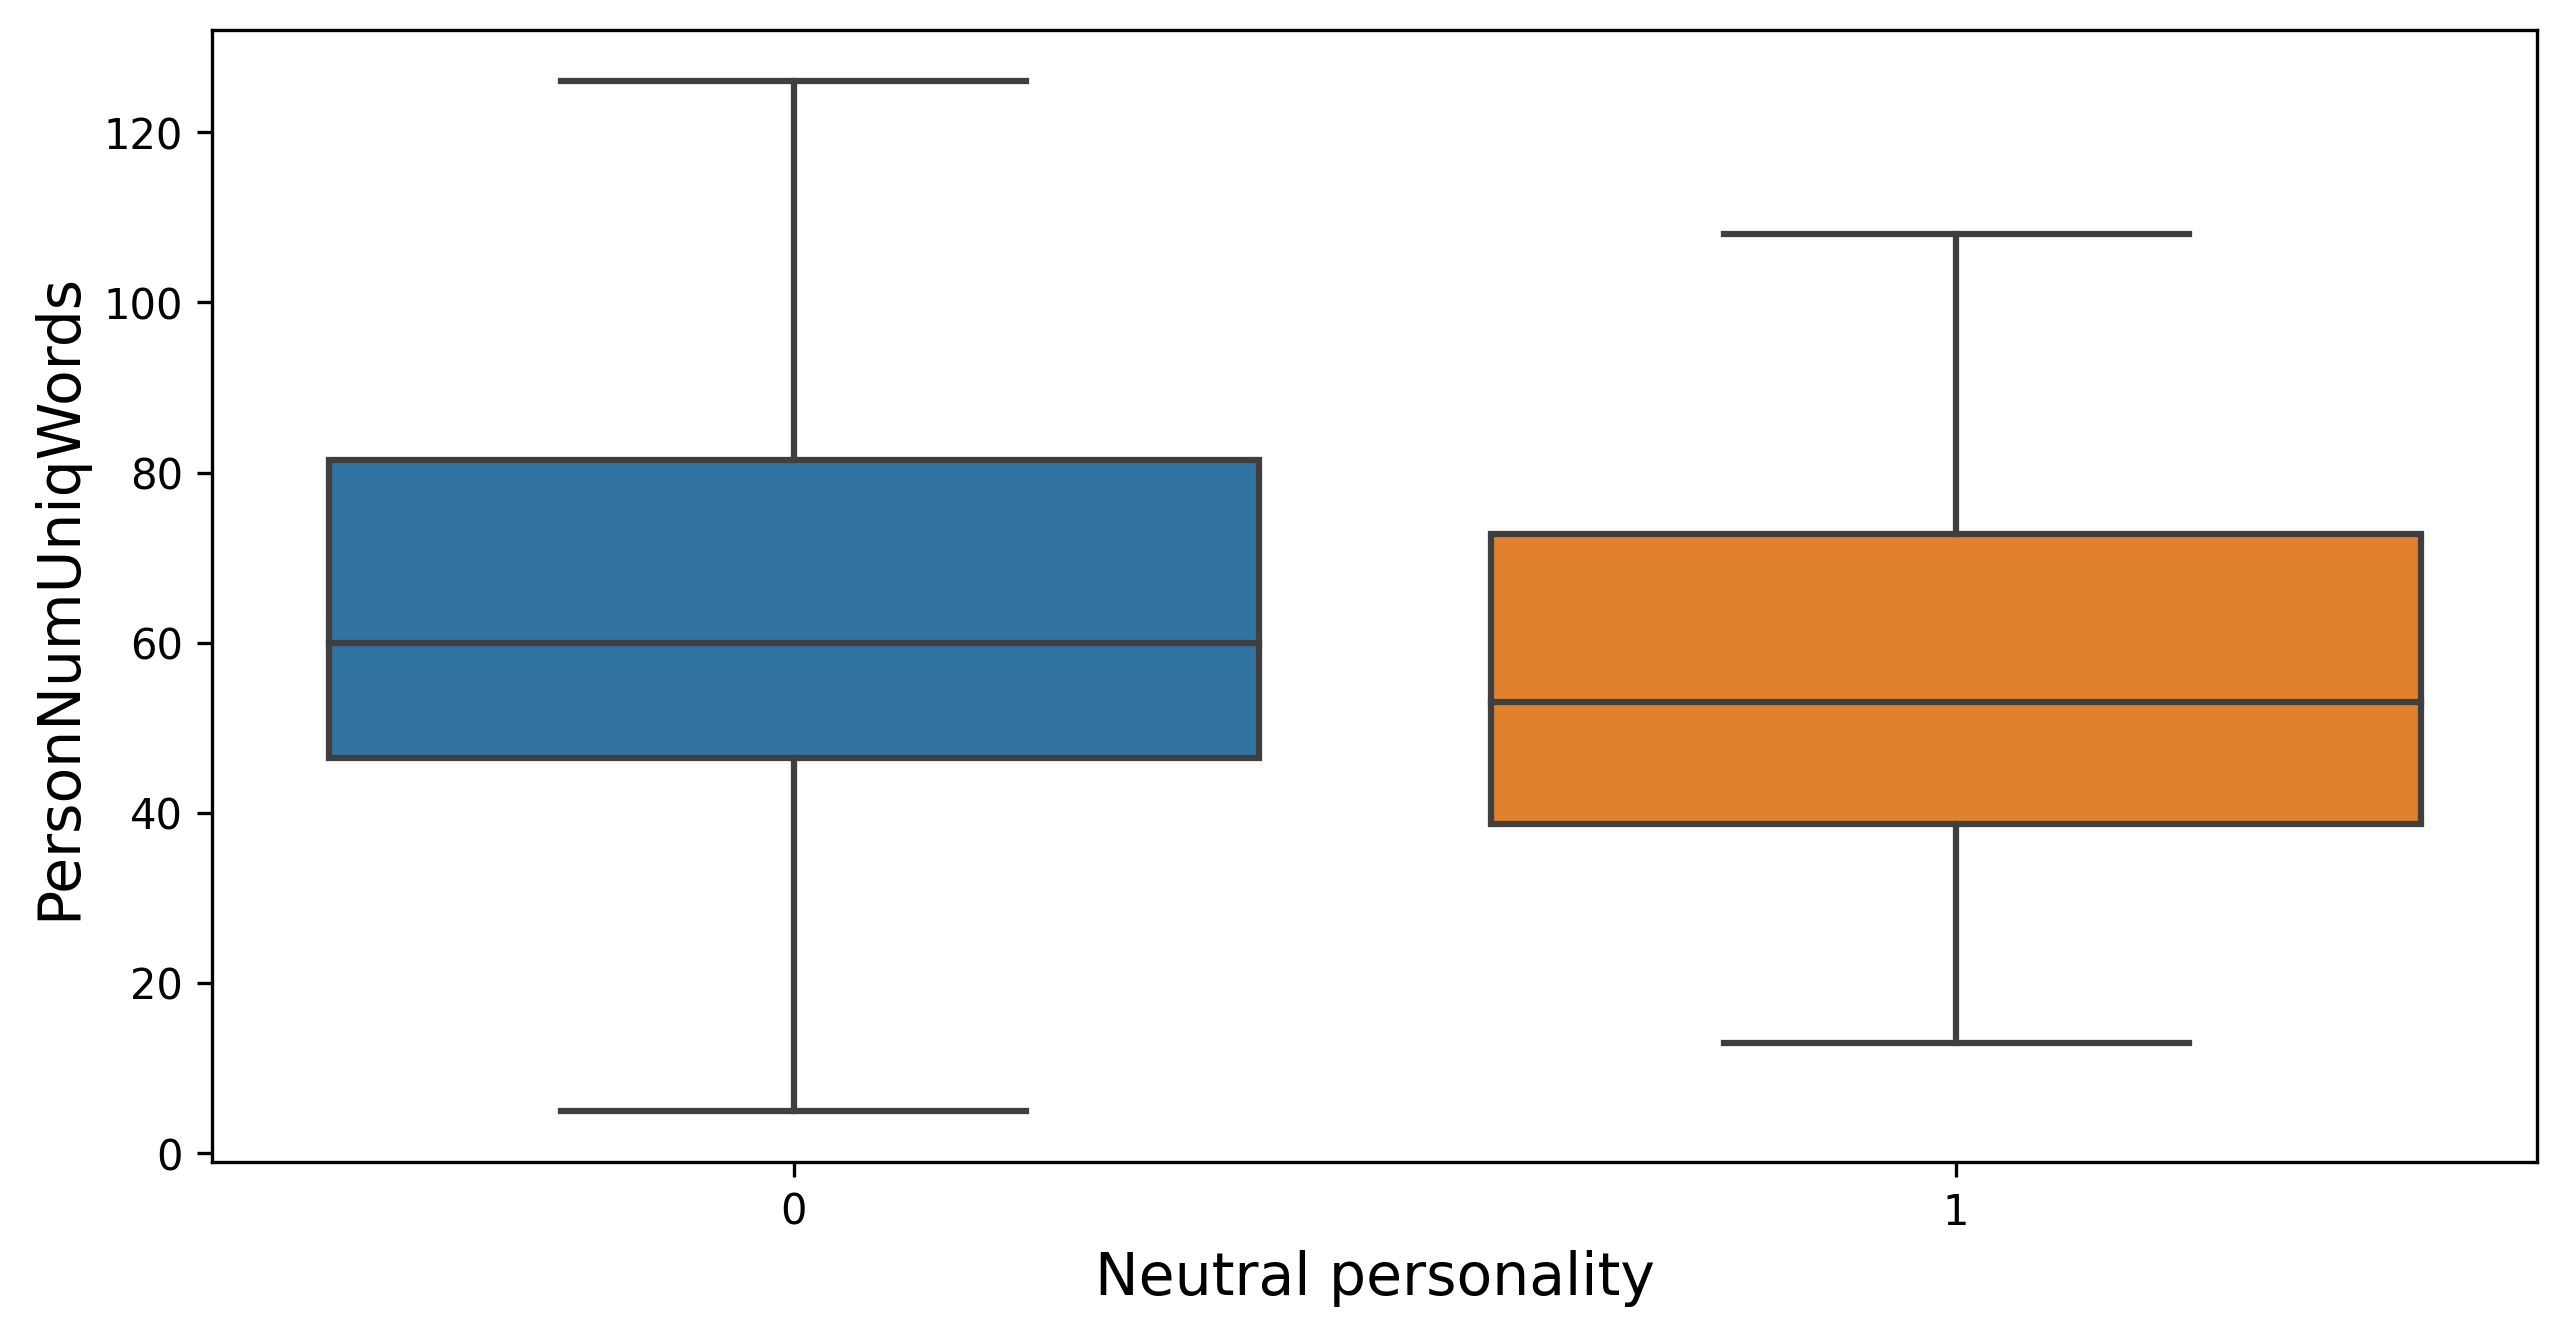

P-value 0.0917859930957817 with significance -


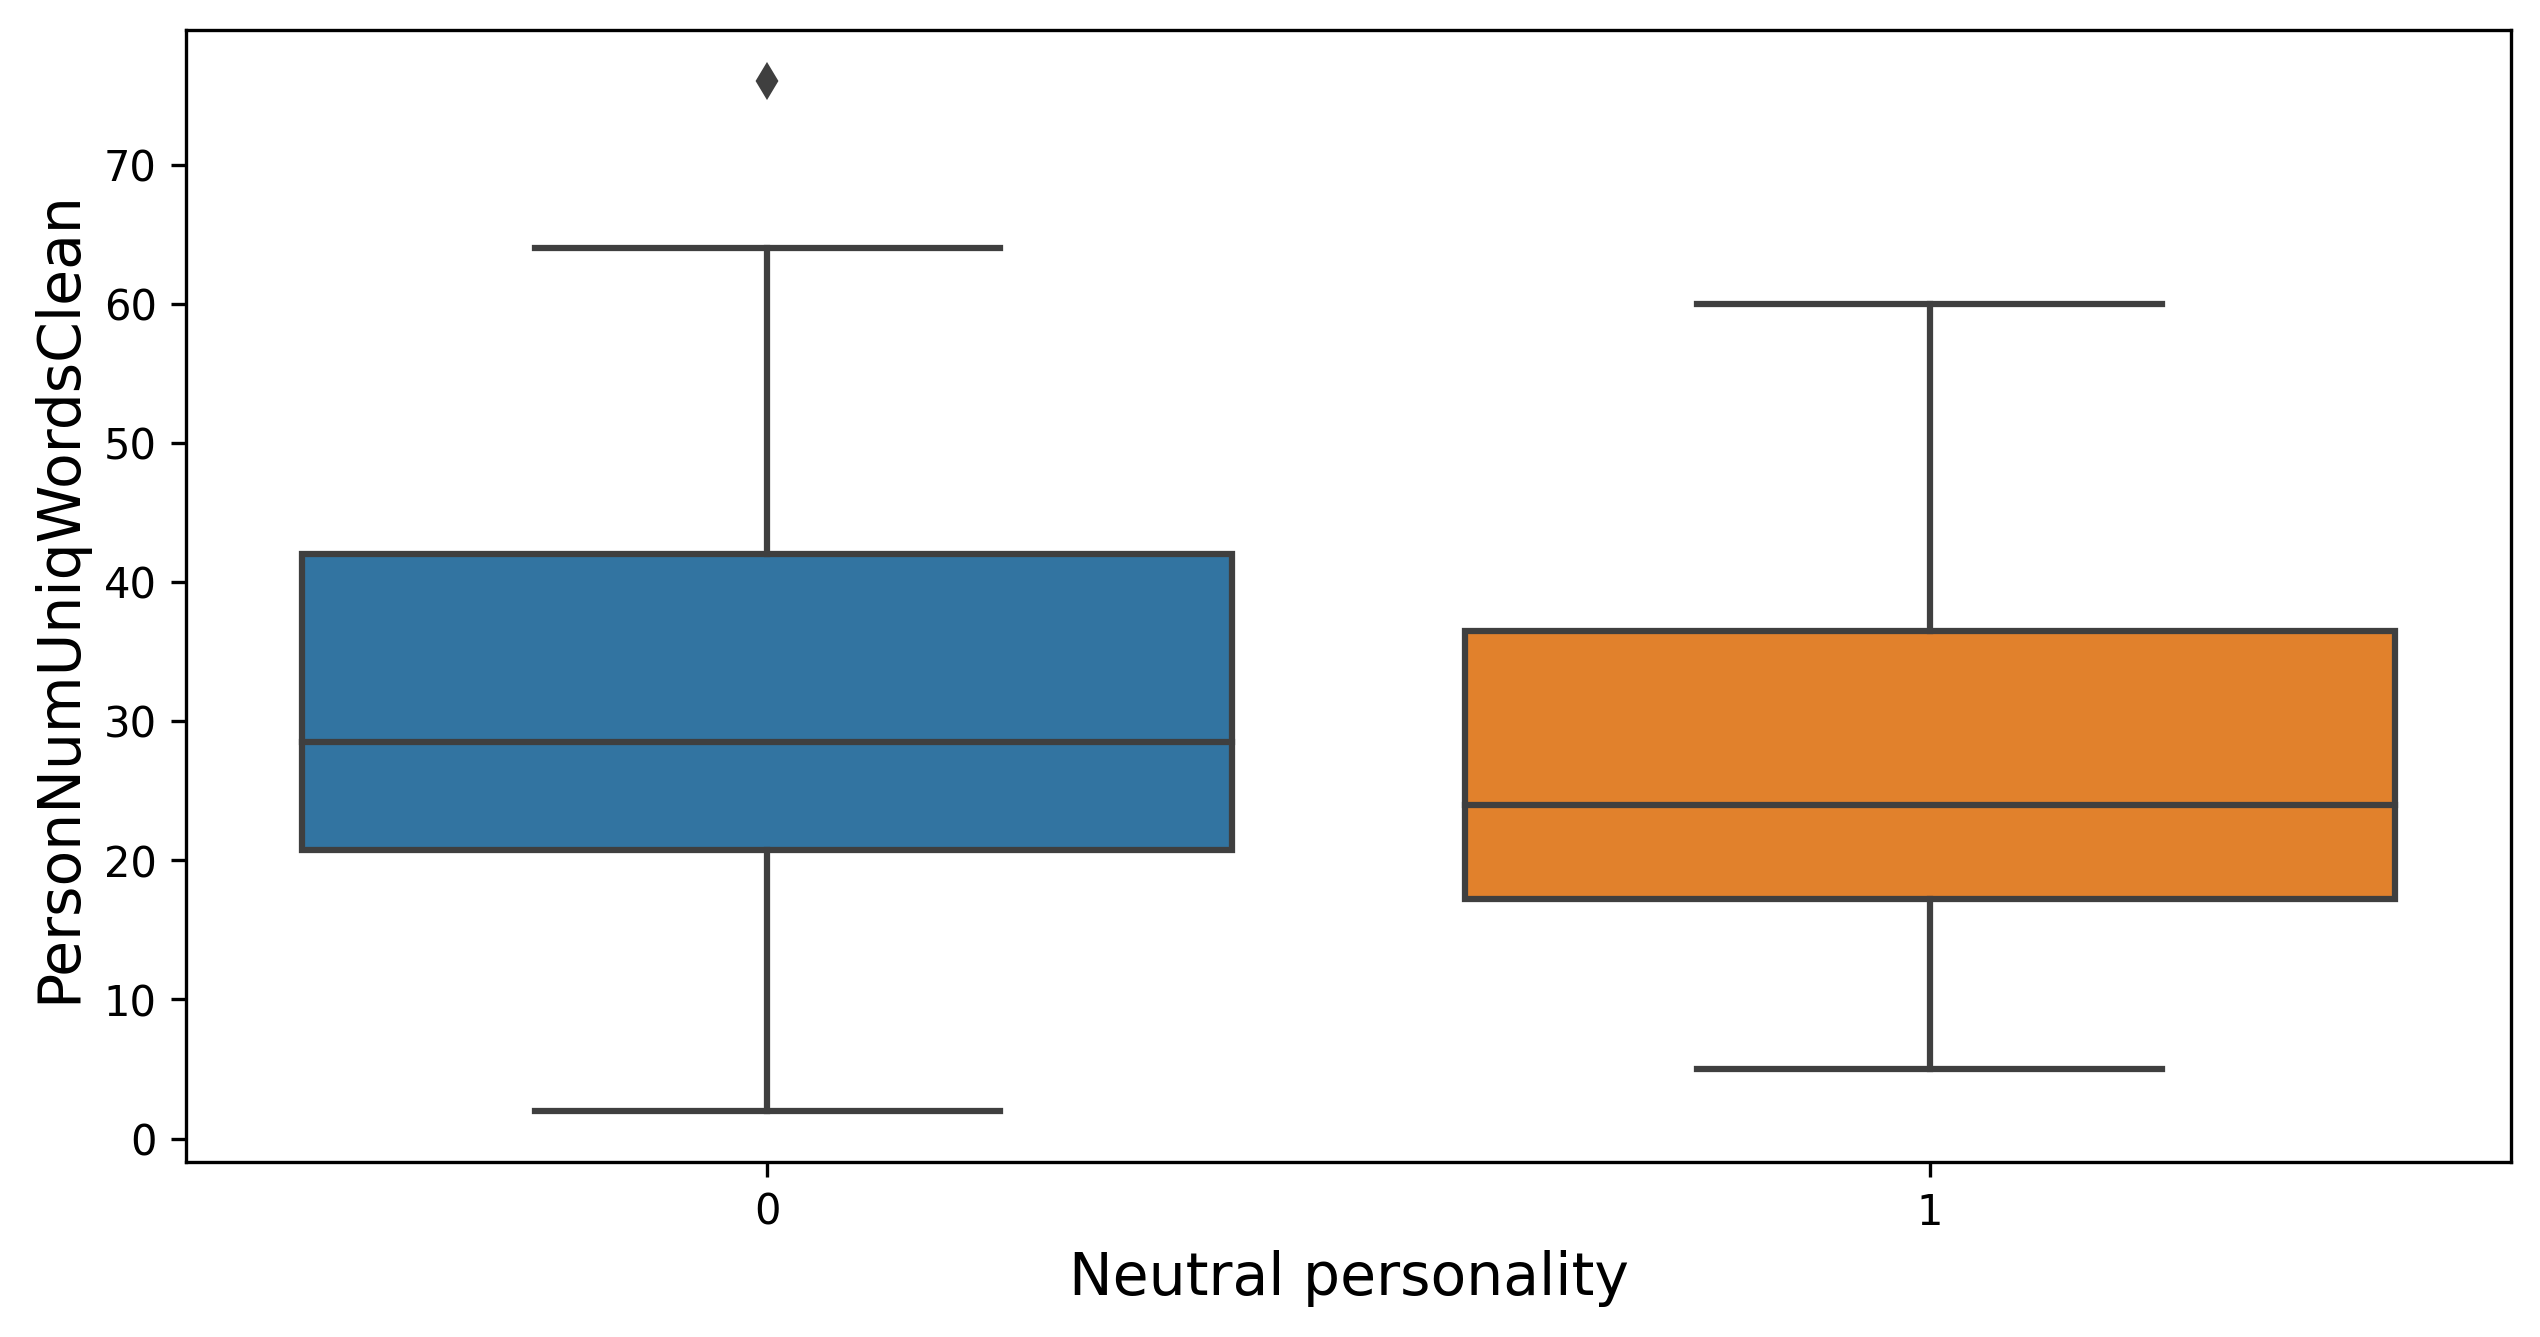

P-value 0.18476009419300082 with significance -


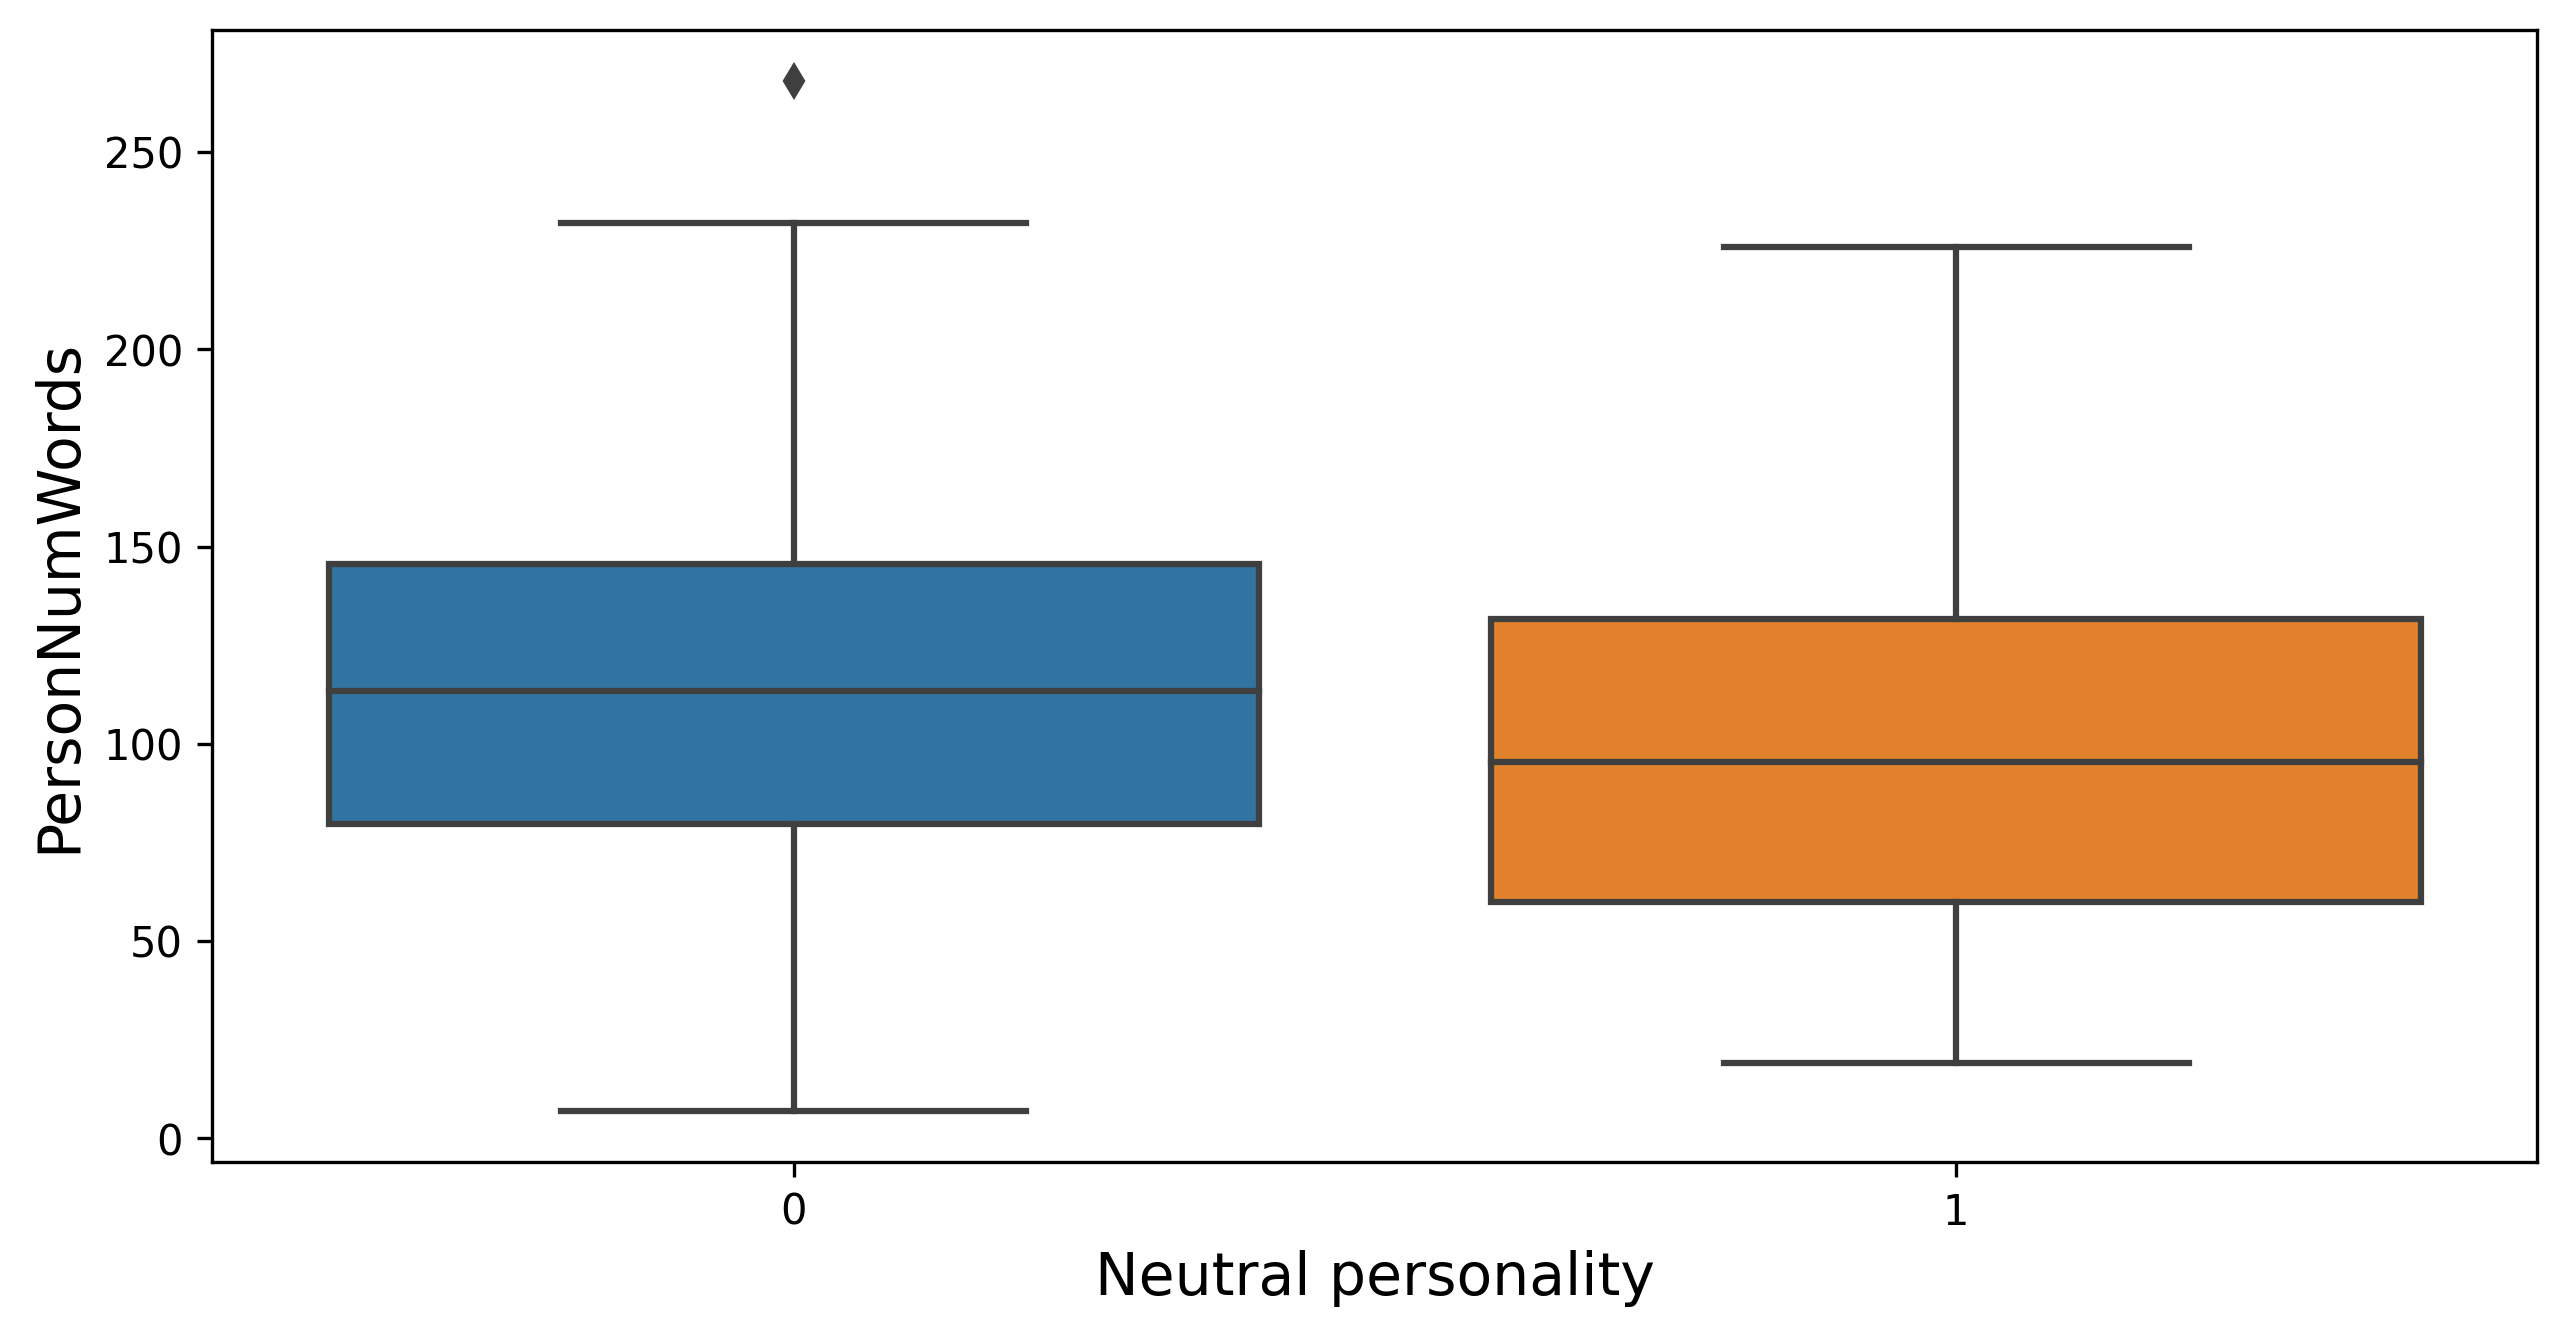

P-value 0.20409849983005462 with significance -


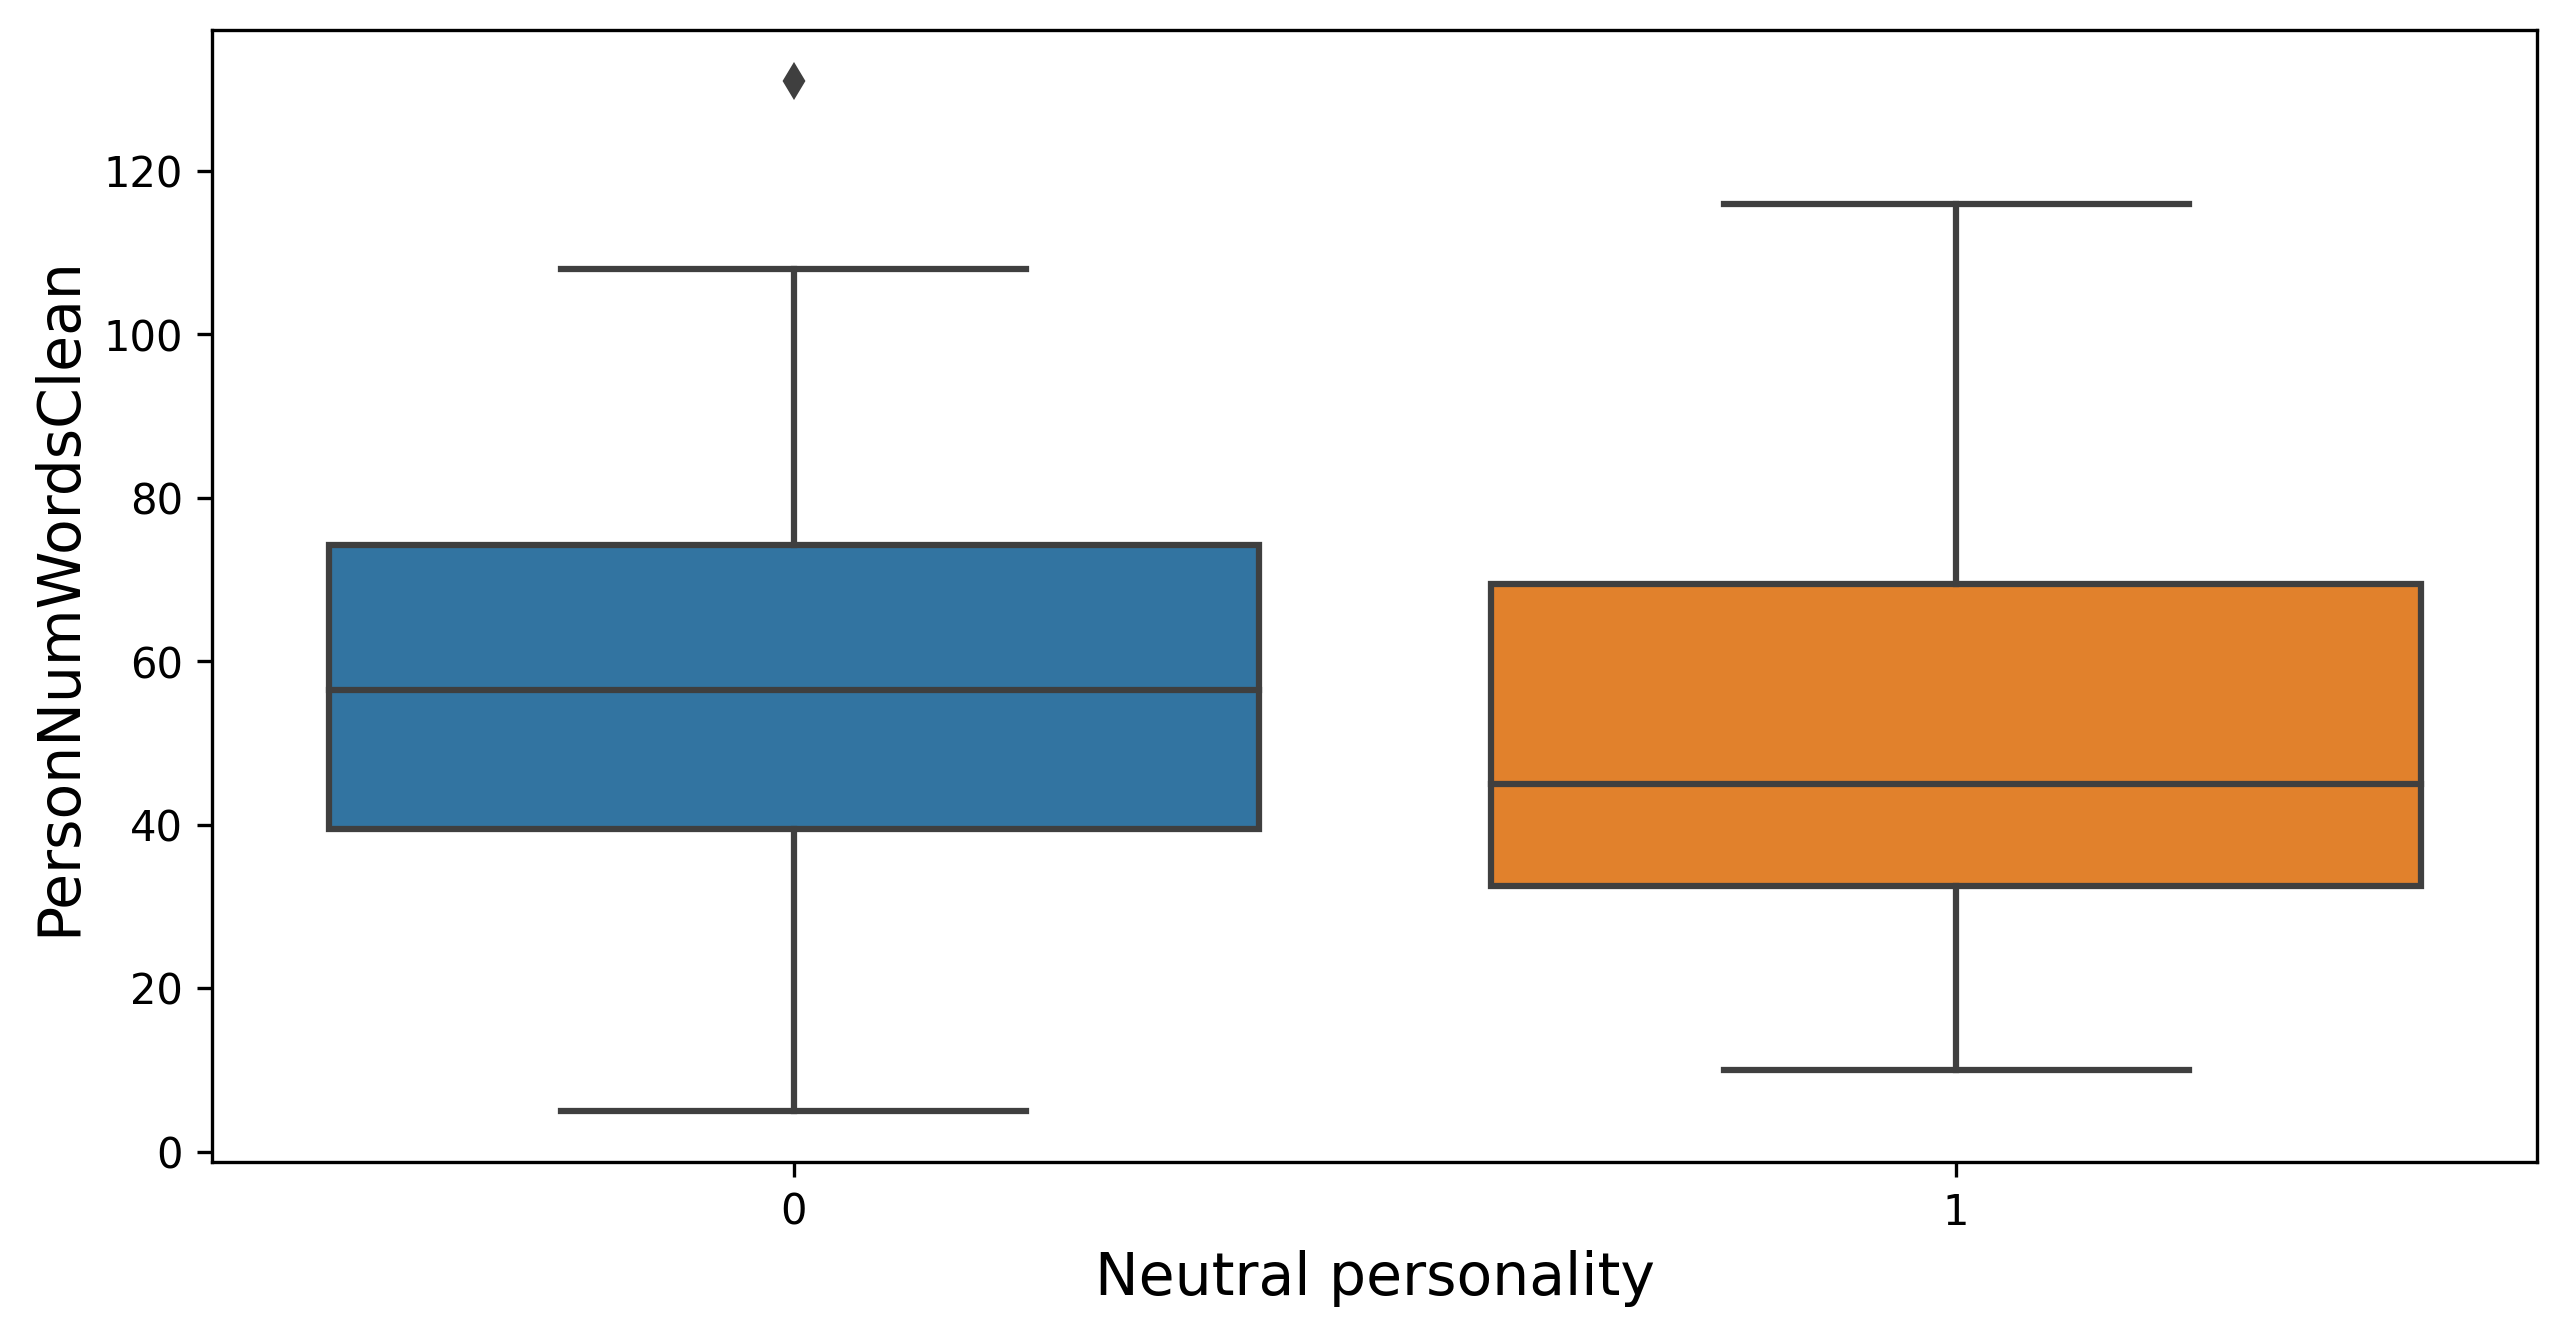

P-value 0.189183843150956 with significance -


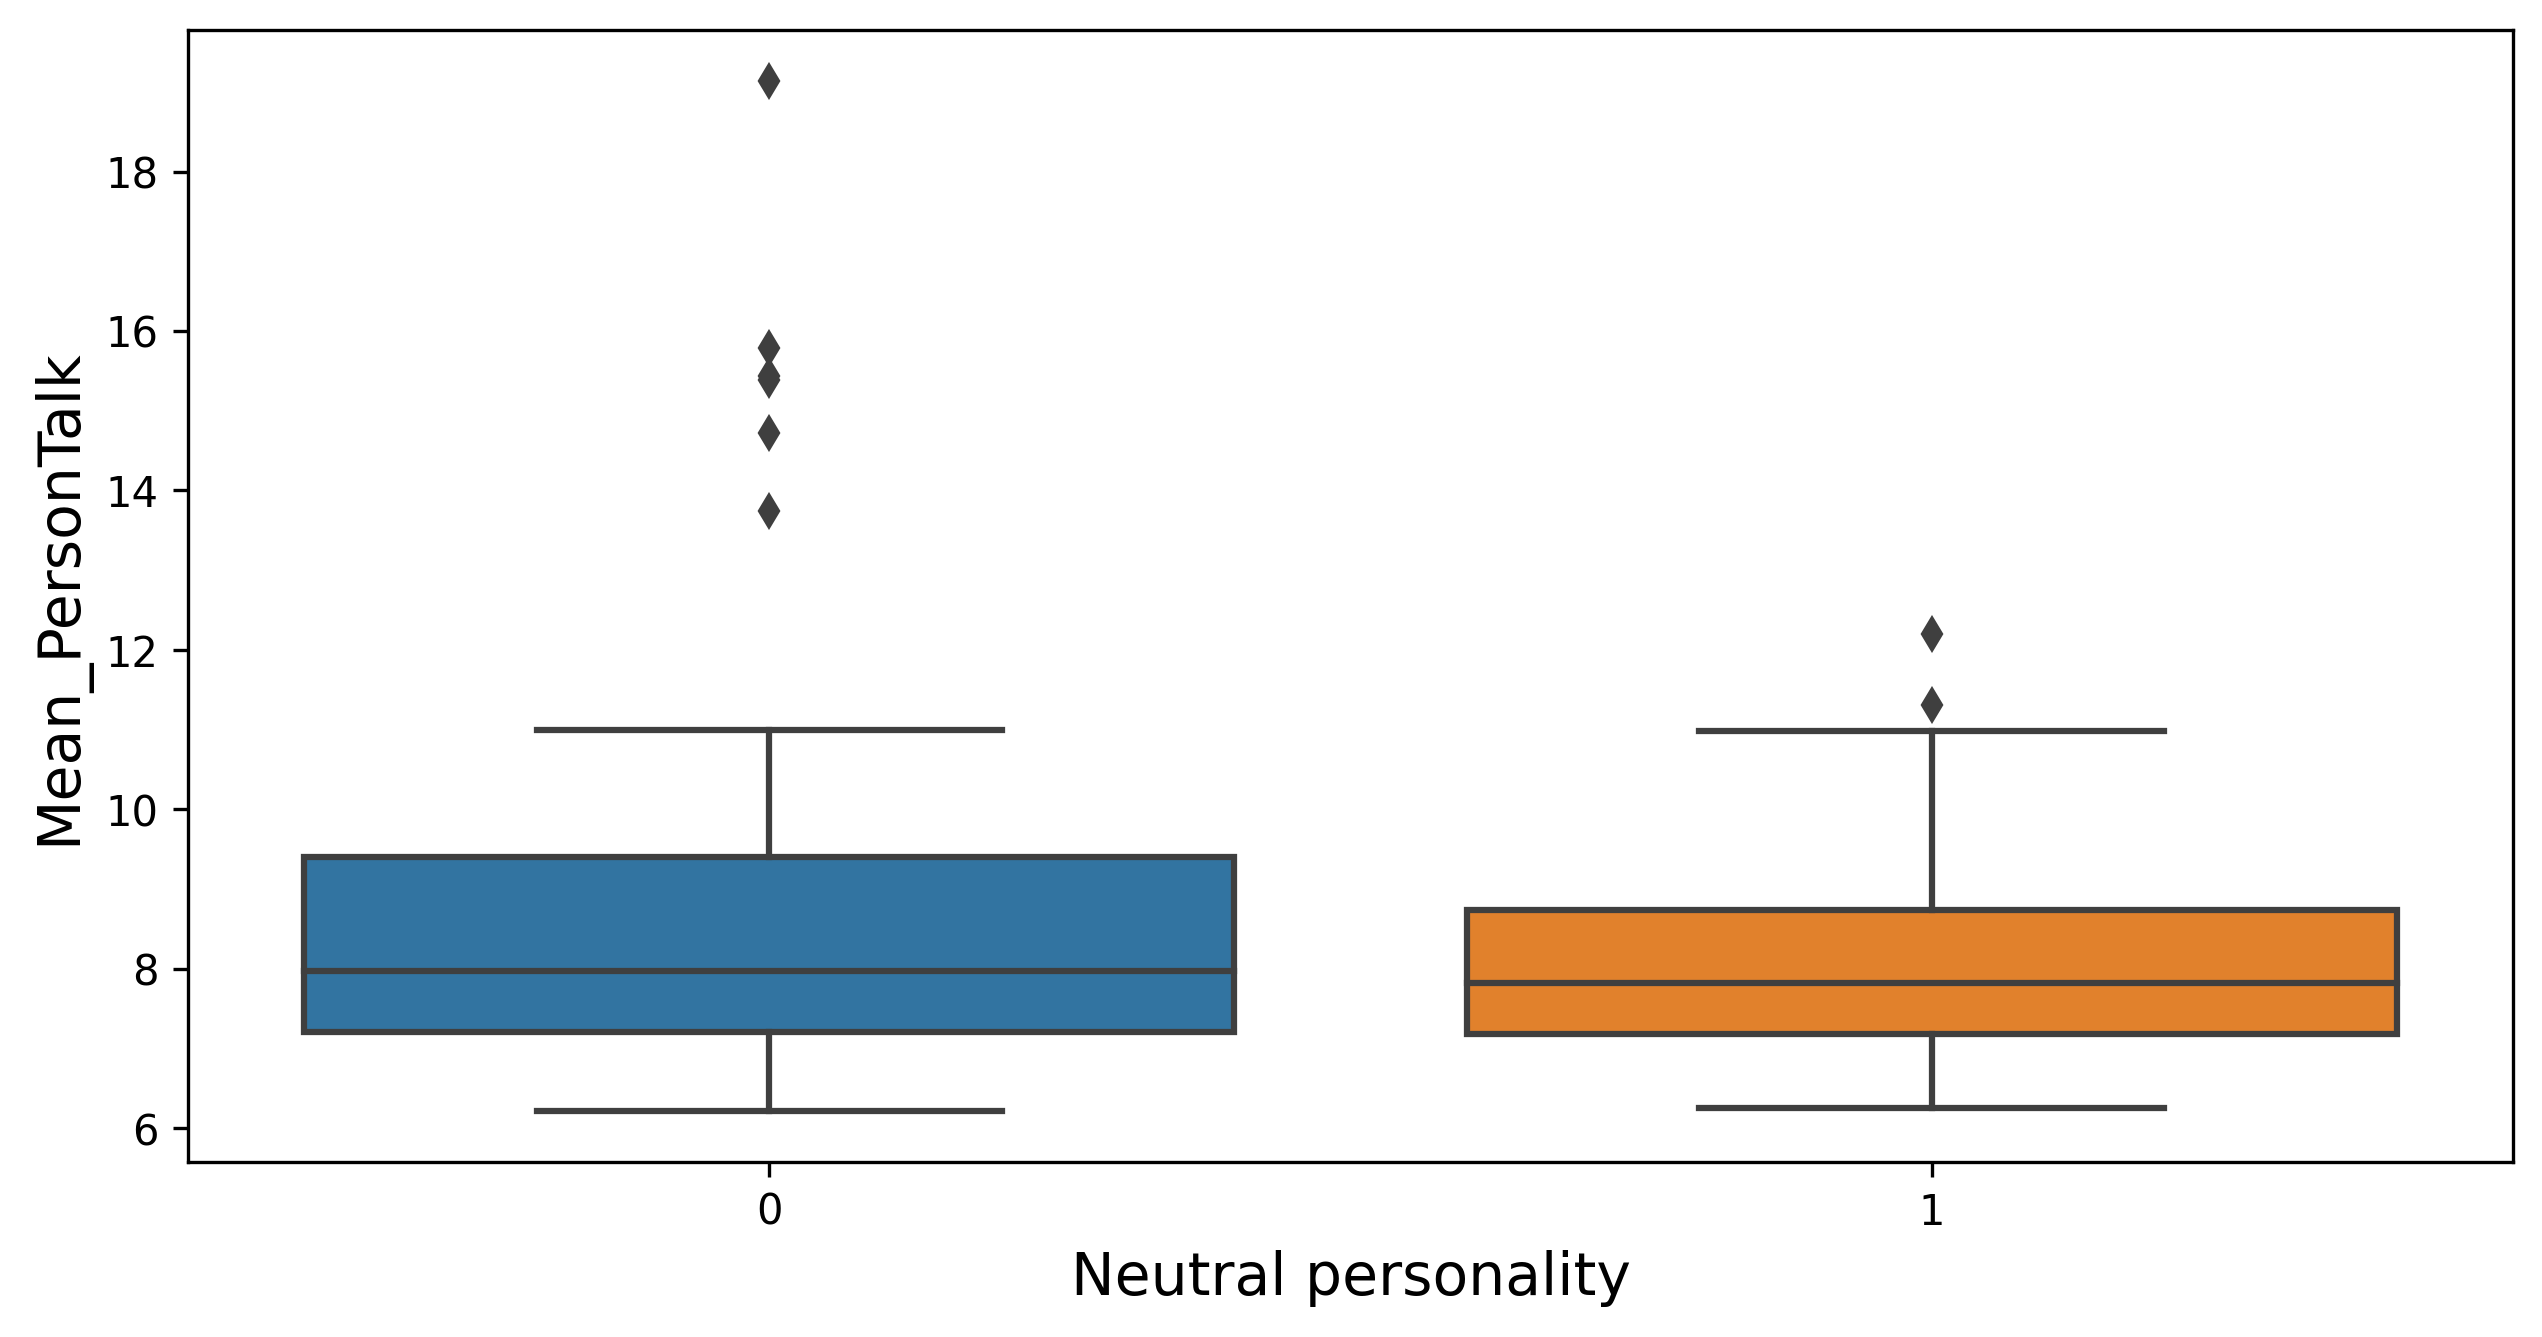

P-value 0.9578828019476496 with significance -


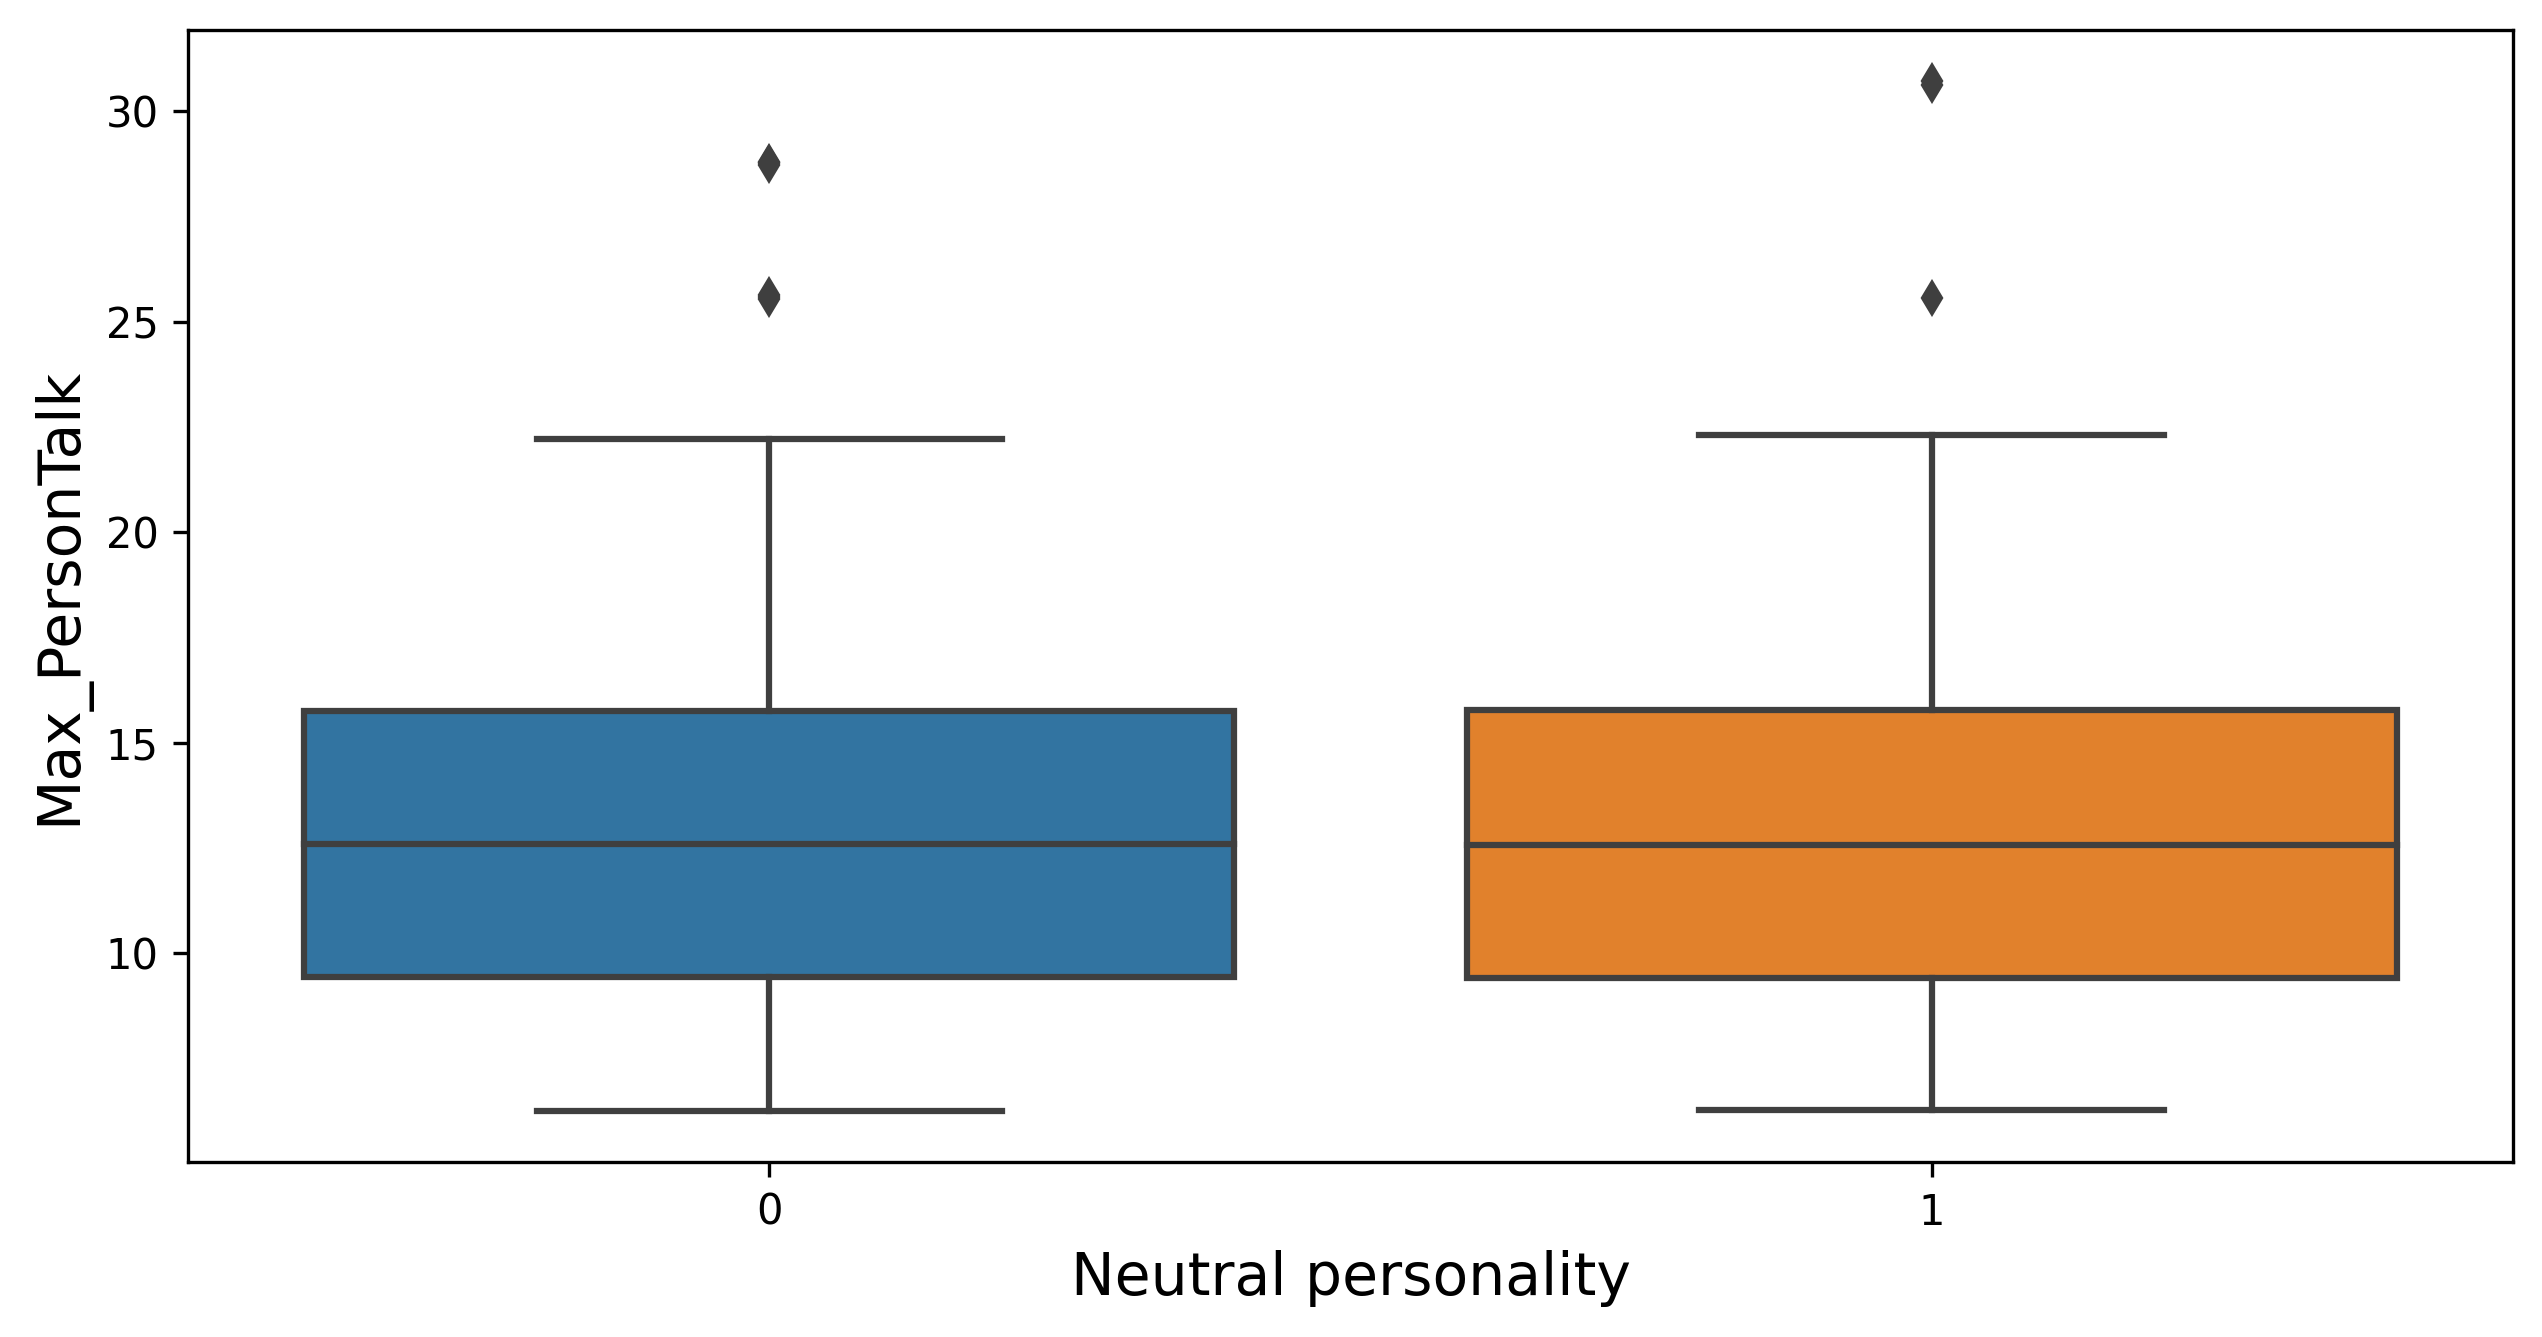

P-value 0.49114649672979316 with significance -


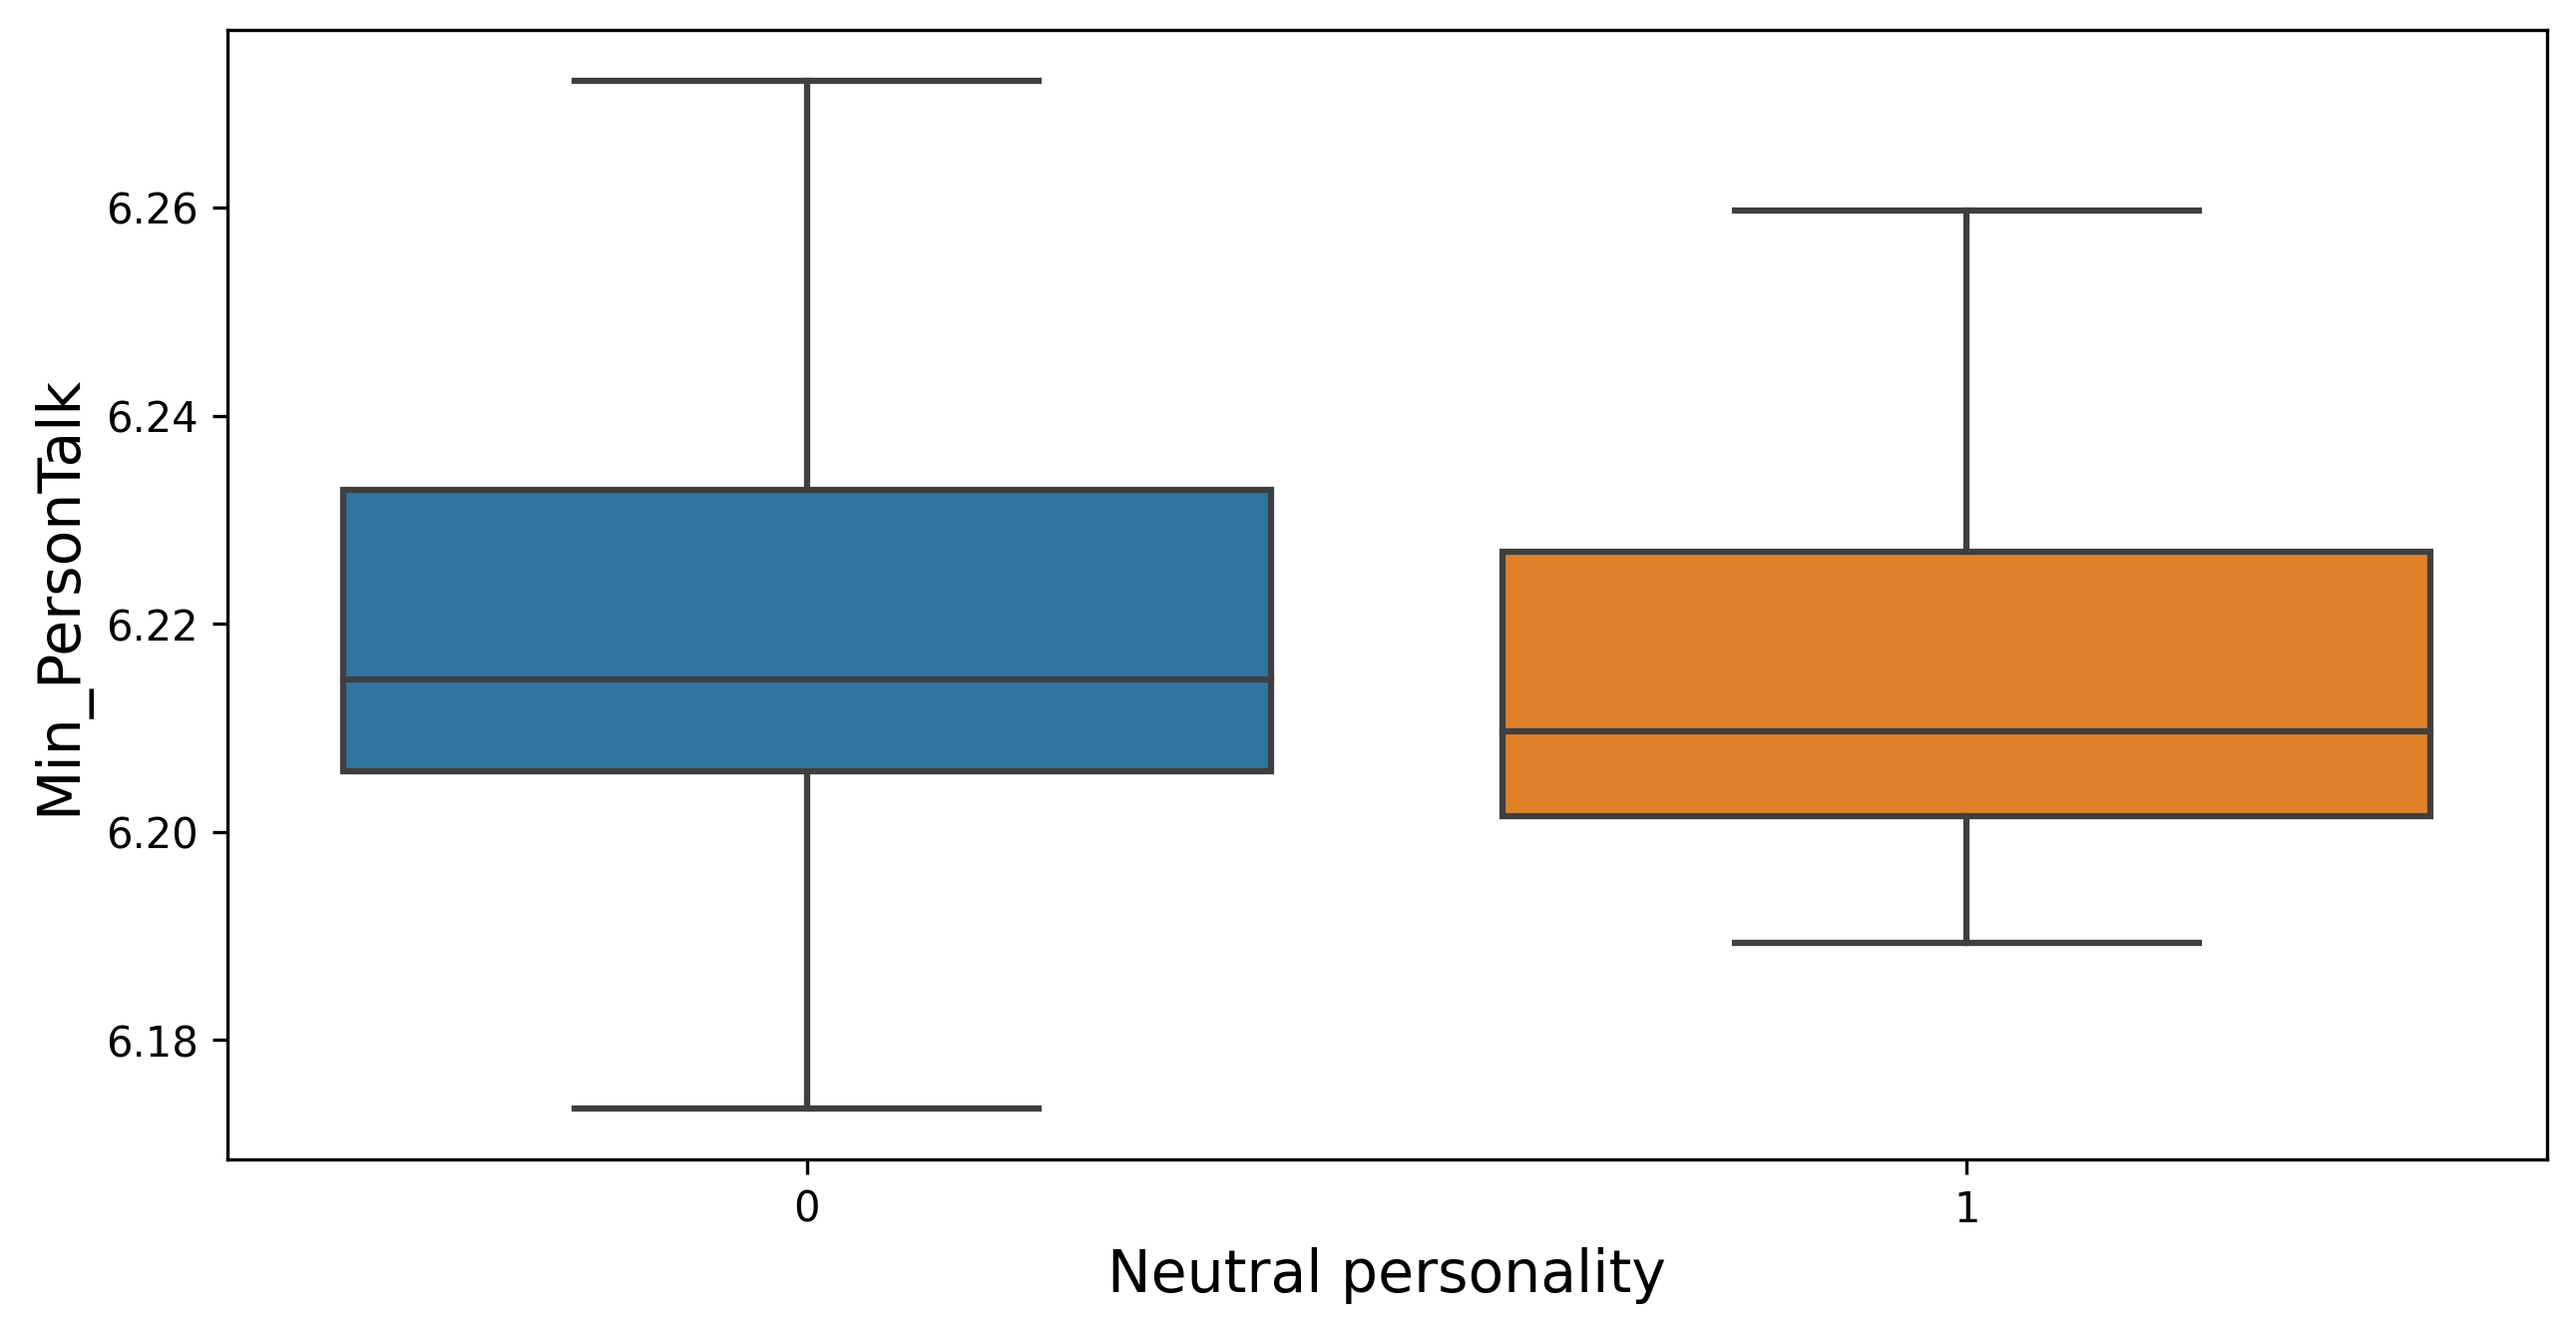

P-value 0.5102781475283915 with significance -


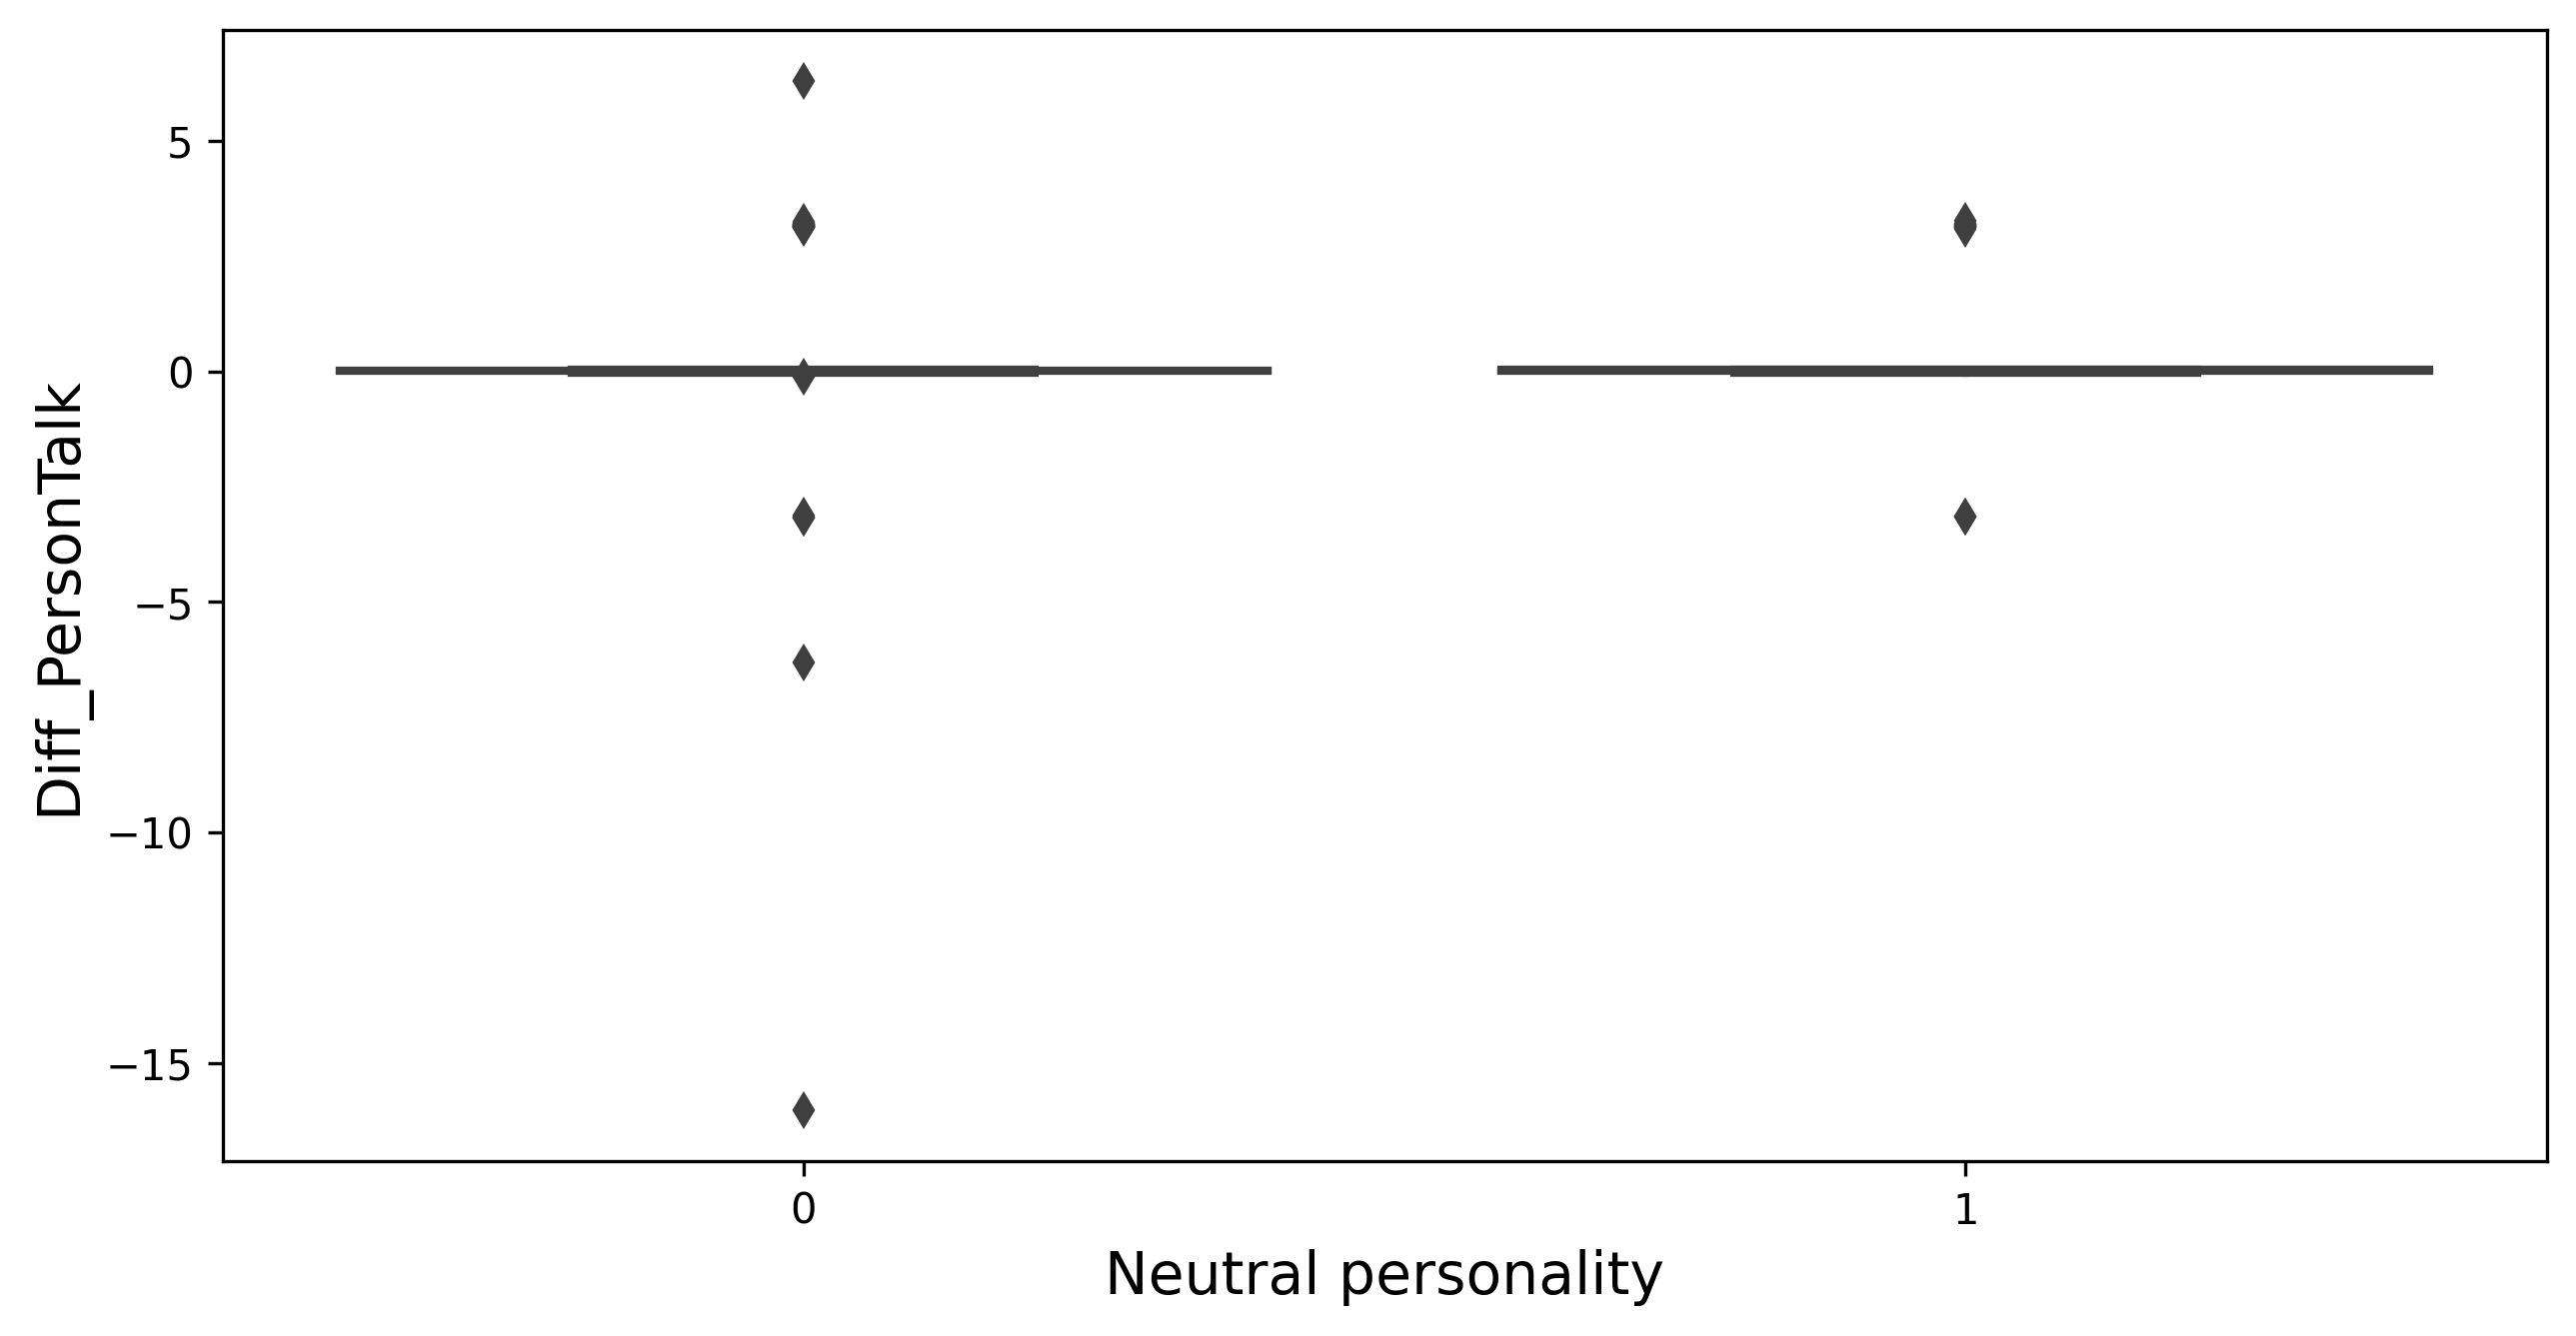

P-value 0.6136989050454091 with significance -


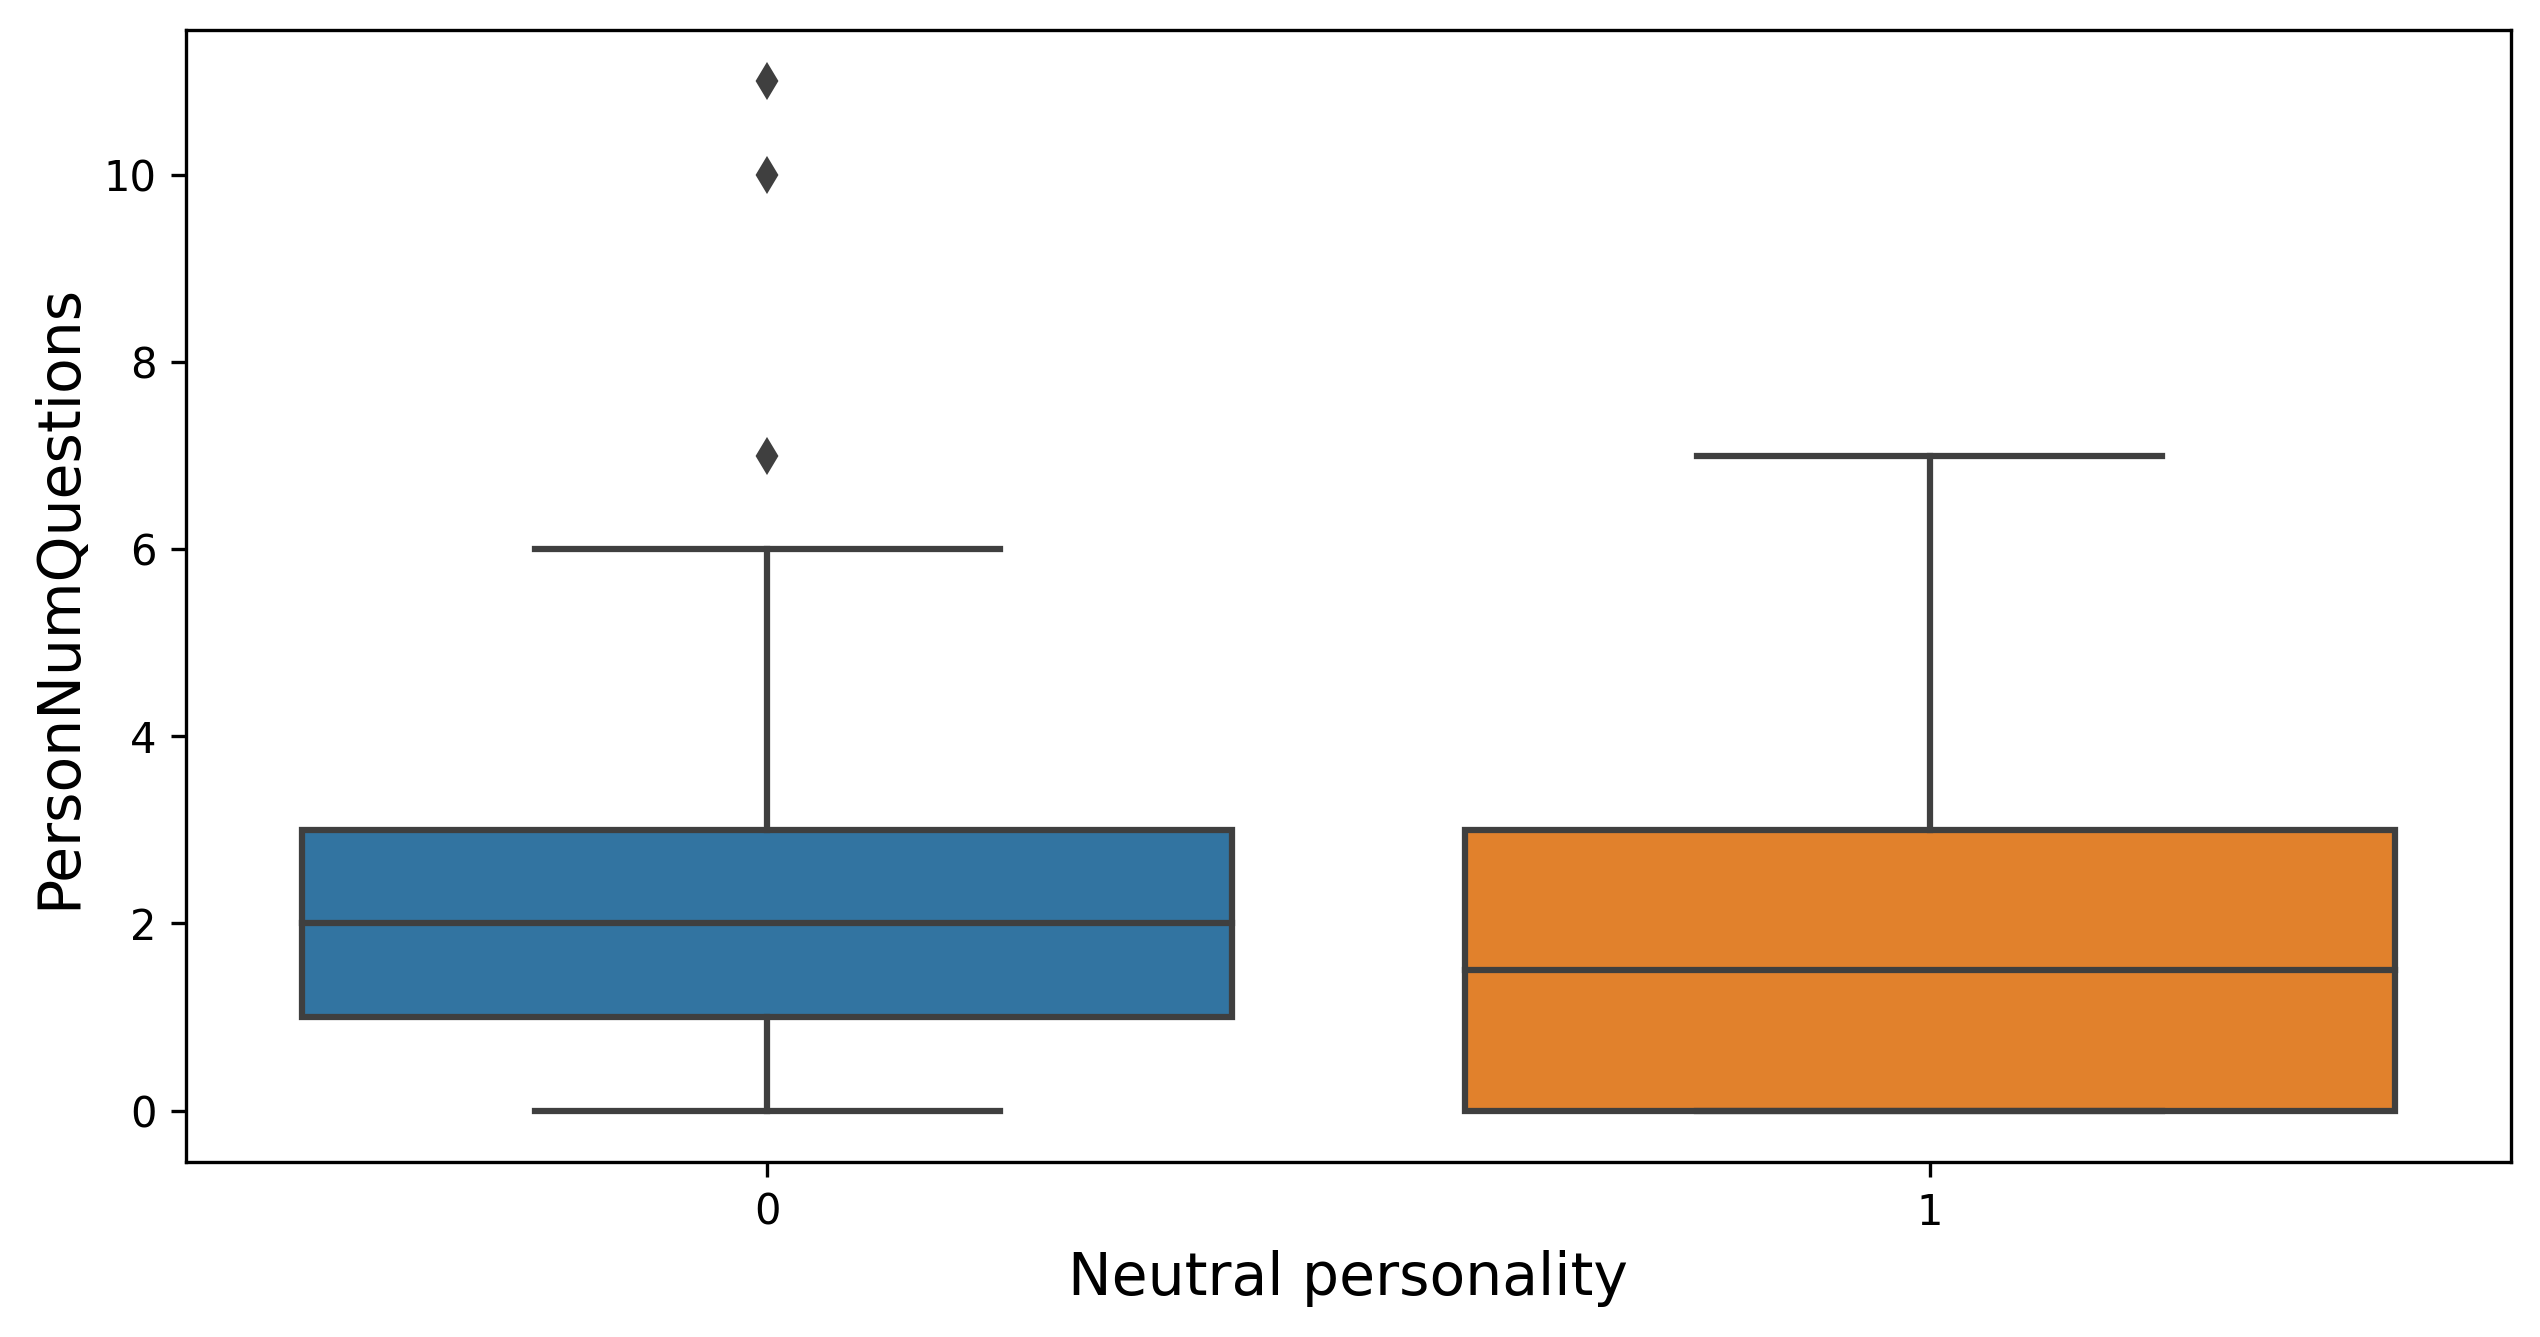

P-value 1.0 with significance -


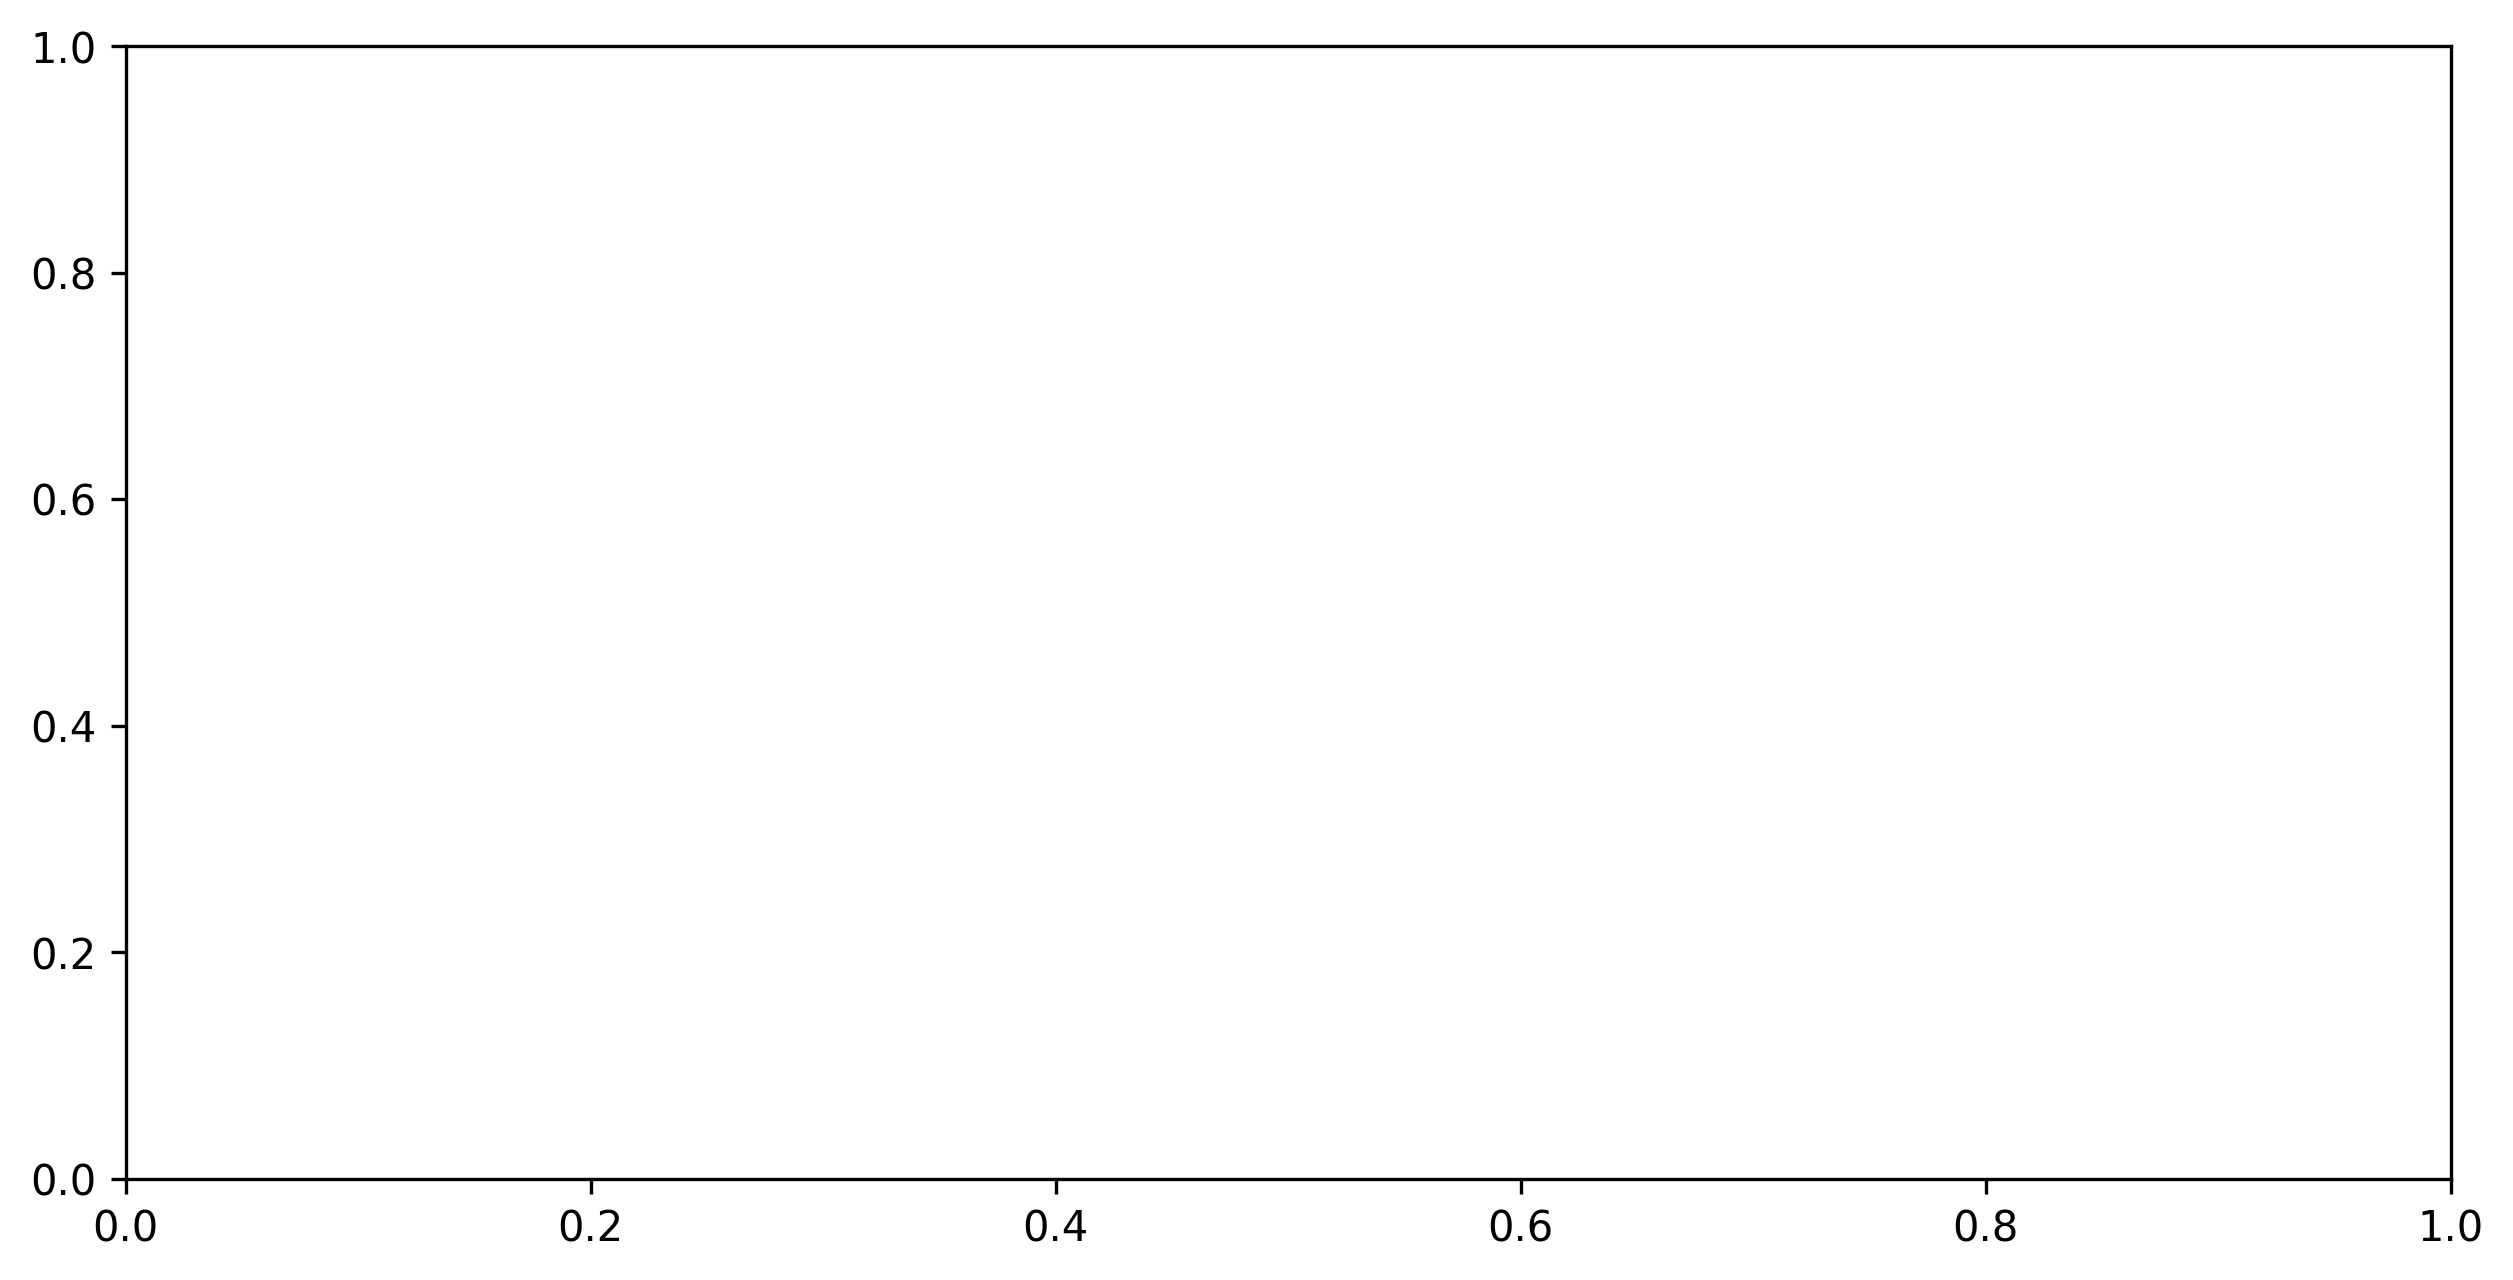

In [47]:
cols_to_see = [
    "ConvTime_s",
    "NumSamples",
    "PersonNumUniqWords",
    "PersonNumUniqWordsClean",
    "PersonNumWords",
    "PersonNumWordsClean",
    'Mean_PersonTalk',
    'Max_PersonTalk', 
    'Min_PersonTalk',
    'Diff_PersonTalk',
    "PersonNumQuestions",
    "AboveMaximumTime"
]

target = "NeutralBool"

for col in cols_to_see:
    try:
        aute.make_binary_plot(data=df_neut, 
                              x_feat=target, x_name="Neutral personality", 
                              y_feat=col, y_name=col)
    except:
        pass

In [48]:
df_neut[cols_to_see + [target]].head(8)

,ConvTime_s,NumSamples,PersonNumUniqWords,PersonNumUniqWordsClean,PersonNumWords,PersonNumWordsClean,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk,PersonNumQuestions,AboveMaximumTime,NeutralBool
0,163.274568,13,57,27,105,53,10.987555,18.949747,6.200216,-0.023398,1,False,1
1,87.746197,9,31,13,50,21,7.830935,9.427005,6.227488,3.175351,0,False,1
2,123.356988,10,43,20,66,32,9.411009,15.750861,6.265236,-3.125580,0,False,0
3,182.710761,15,60,23,106,49,9.390276,15.737232,6.210278,3.124682,2,False,0
4,138.772165,17,43,18,70,34,7.026681,9.435585,6.209277,0.030921,1,False,0
5,122.044762,11,45,23,65,33,8.156119,12.621134,6.251256,-0.008949,1,False,0
6,249.417012,25,42,14,74,31,10.650504,30.711790,6.210377,3.131618,0,True,1
7,138.329784,17,25,11,41,22,6.619163,9.366427,6.210044,0.048138,0,False,1


In [49]:
x_data = df_neut[cols_to_see]
y_data = df_neut[target]

print("Number of samples in X", x_data.shape)
print("Percentage of 1", np.round(100*np.mean(y_data), 2), "%")

save_metrics_result_list = []
iteration_count = 0
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=0)
for train_idxs, test_idxs in rskf.split(x_data, y_data):

    x_train, x_test = x_data.iloc[train_idxs], x_data.iloc[test_idxs] 
    y_train, y_test = y_data.iloc[train_idxs], y_data.iloc[test_idxs]

    model = Pipeline([
        ('scaler', StandardScaler()), 
        ('LogR', LogisticRegression(random_state=0))
    ])

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = skmetrics.accuracy_score(y_test, y_pred)
    kappa = skmetrics.cohen_kappa_score(y_test, y_pred)
    roc = skmetrics.roc_auc_score(y_test, y_pred)

    save_metrics_result_list.append({
        "Iteration": iteration_count,
        "Accuracy": acc,
        "Kappa": kappa,
        "RocAuc": roc
    })

    iteration_count += 1
        
df_metrics = pd.DataFrame(save_metrics_result_list)

Number of samples in X (114, 12)
Percentage of 1 33.33 %


El resultado es muy malo. Tal vez tendría que sacar el número de veces que la conversación super el tiempo máximo permitido que son los 4 minutos. El número de veces que se hacen preguntas. etc.

In [50]:
for metrics in ["Accuracy", "Kappa", "RocAuc"]:
    aute.stat_print(df_metrics[metrics], metrics)

Mean Accuracy = 0.65 +/- 0.1025 ; Median = 0.6364 ; Min. =  0.4545 ; Max. =  0.8333
Mean Kappa = 0.0927 +/- 0.2708 ; Median = 0.12 ; Min. =  -0.375 ; Max. =  0.6071
Mean RocAuc = 0.5415 +/- 0.1229 ; Median = 0.5536 ; Min. =  0.3125 ; Max. =  0.8036


### Can I distinguish between personalities

In [51]:
df_p = df_save.copy()

In [52]:
df_neut["BotPersonality"].unique()

array(['Neutral', 'Happy', 'Relax', 'Sad', 'Angry'], dtype=object)

In [53]:
personality_list = ['Happy', 'Relax', 'Sad', 'Angry']
for personality in personality_list:
    df_p[personality+"Bool"] = (df_p["BotPersonality"] == personality)*1

In [54]:
cols_to_see = [
    "ConvTime_s",
    "NumSamples",
    "PersonNumUniqWords",
    "PersonNumUniqWordsClean",
    "PersonNumWords",
    "PersonNumWordsClean",
    'Mean_PersonTalk',
    'Max_PersonTalk', 
    'Min_PersonTalk',
    'Diff_PersonTalk',
    "PersonNumQuestions",
    "AboveMaximumTime"
]

In [55]:
for pers in personality_list:
    for col in cols_to_see:
        group_list = [df_g[col].tolist() for g, df_g in df_p.groupby(pers+"Bool")]
        _, p_value_anova = sp.stats.f_oneway(*group_list)
        _, p_value_ks = sp.stats.kstest(*group_list)
        if p_value_anova < 0.05 or p_value_ks < 0.05:
            print("Personality", pers)
            print("ANOVA P-value", p_value_anova, "with significance", aute.get_p_string(p_value_anova))
            print("KS P-value", p_value_ks, "with significance", aute.get_p_string(p_value_ks))
            print()

Personality Relax
ANOVA P-value 0.32206814423985075 with significance -
KS P-value 0.046058533785262146 with significance *

Personality Angry
ANOVA P-value 0.016757871514814855 with significance *
KS P-value 0.046058533785262146 with significance *

Personality Angry
ANOVA P-value 0.03156389944857404 with significance *
KS P-value 0.2377553749998027 with significance -



In [56]:
for pers in personality_list:

    x_data = df_p[cols_to_see]
    y_data = df_p[pers+"Bool"]
    
    print("Personality", pers)
    print("Number of samples in X", x_data.shape)
    print("Percentage of 1", np.round(100 * np.mean(y_data), 2), "%")

    save_metrics_result_list = []
    iteration_count = 0
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=0)
    for train_idxs, test_idxs in rskf.split(x_data, y_data):

        x_train, x_test = x_data.iloc[train_idxs], x_data.iloc[test_idxs] 
        y_train, y_test = y_data.iloc[train_idxs], y_data.iloc[test_idxs]

        model = Pipeline([
            ('scaler', StandardScaler()), 
            ('LogR', LogisticRegression(random_state=0))
            # ("RFR", RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0))
        ])

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        acc = skmetrics.accuracy_score(y_test, y_pred)
        kappa = skmetrics.cohen_kappa_score(y_test, y_pred)
        roc = skmetrics.roc_auc_score(y_test, y_pred)

        save_metrics_result_list.append({
            "Iteration": iteration_count,
            "Accuracy": acc,
            "Kappa": kappa,
            "RocAuc": roc
        })

        iteration_count += 1

    df_metrics = pd.DataFrame(save_metrics_result_list)

    for metrics in ["Accuracy", "Kappa", "RocAuc"]:
        aute.stat_print(df_metrics[metrics], metrics)
    print()

Personality Happy
Number of samples in X (114, 12)
Percentage of 1 16.67 %
Mean Accuracy = 0.8292 +/- 0.0319 ; Median = 0.8182 ; Min. =  0.75 ; Max. =  0.9091
Mean Kappa = -0.0062 +/- 0.0272 ; Median = 0.0 ; Min. =  -0.125 ; Max. =  0.0
Mean RocAuc = 0.4975 +/- 0.0109 ; Median = 0.5 ; Min. =  0.45 ; Max. =  0.5

Personality Relax
Number of samples in X (114, 12)
Percentage of 1 16.67 %
Mean Accuracy = 0.8288 +/- 0.0349 ; Median = 0.8258 ; Min. =  0.7273 ; Max. =  0.9091
Mean Kappa = -0.0069 +/- 0.0301 ; Median = 0.0 ; Min. =  -0.1379 ; Max. =  0.0
Mean RocAuc = 0.4972 +/- 0.0121 ; Median = 0.5 ; Min. =  0.4444 ; Max. =  0.5

Personality Sad
Number of samples in X (114, 12)
Percentage of 1 16.67 %
Mean Accuracy = 0.8205 +/- 0.0405 ; Median = 0.8182 ; Min. =  0.6667 ; Max. =  0.9091
Mean Kappa = -0.015 +/- 0.0477 ; Median = 0.0 ; Min. =  -0.2 ; Max. =  0.0
Mean RocAuc = 0.4925 +/- 0.0238 ; Median = 0.5 ; Min. =  0.4 ; Max. =  0.5

Personality Angry
Number of samples in X (114, 12)
Percen

## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [57]:
whole_text = " ".join(df_save["AllOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,gusta,320
1,valencia,224
2,bien,203
3,pues,183
4,si,169
5,hola,165
6,ir,155
7,aquí,133
8,bueno,130
9,gracias,125


In [58]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 2444
Mean frequency 5.90098 +/- 16.11162 Max 320 Min 1


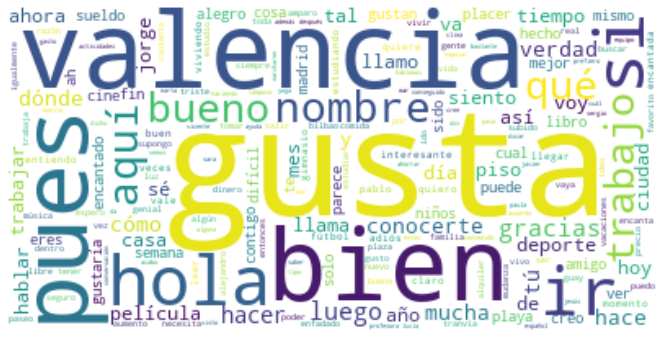

In [59]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [60]:
whole_bot_text = " ".join(df_save["BotOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,gusta,211
1,valencia,121
2,gracias,109
3,ir,109
4,¿qué,107
5,nombre,96
6,hola,94
7,trabajo,90
8,conocerte,79
9,tú?,79


In [61]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 1520
Mean frequency 5.5875 +/- 12.62423 Max 211 Min 1


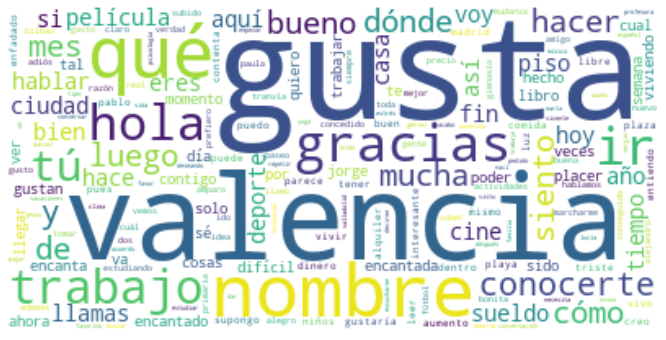

In [62]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analysis against Questionare

In [63]:
random_target = [np.random.randint(1, 5+1) for _ in range(df_save.shape[0])]
random_binary_target = [np.random.randint(0, 1+1) for _ in range(df_save.shape[0])]

In [64]:
df_save["MultilabelTarget"] = random_target
df_save["BinaryTarget"] = random_binary_target

In [65]:
aute.stat_print(df_save["MultilabelTarget"], "Realism degree score", precision=2)
aute.stat_print(100 * df_save["BinaryTarget"], "Repetition score", precision=2)

Mean Realism degree score = 3.0 +/- 1.34 ; Median = 3.0 ; Min. =  1 ; Max. =  5
Mean Repetition score = 53.51 +/- 49.88 ; Median = 100.0 ; Min. =  0 ; Max. =  100


In [66]:
print("Columns", df_save.columns)
df_save.head(5)

Columns Index(['SubjectId', 'ConfigName', 'BotPersonality', 'FirstDate', 'LastDate',
       'ConvTime_s', 'AboveMaximumTime', 'NumConv', 'NumSamples',
       'AllTextClean', 'AllNumUniqWordsClean', 'AllNumUniqWords',
       'AllOriginalText', 'AllNumWords', 'AllNumWordsClean', 'AllNumQuestions',
       'BotTextClean', 'BotNumUniqWordsClean', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotNumWordsClean', 'BotNumQuestions',
       'Mean_OpenAI', 'Max_OpenAI', 'Min_OpenAI', 'Diff_OpenAI', 'Mean_AWS',
       'Max_AWS', 'Min_AWS', 'Diff_AWS', 'Mean_BotTalk', 'Max_BotTalk',
       'Min_BotTalk', 'Diff_BotTalk', 'PersonTextClean',
       'PersonNumUniqWordsClean', 'PersonNumUniqWords', 'PersonOriginalText',
       'PersonNumWords', 'PersonNumWordsClean', 'PersonNumQuestions',
       'Mean_PersonTalk', 'Max_PersonTalk', 'Min_PersonTalk',
       'Diff_PersonTalk', 'MultilabelTarget', 'BinaryTarget'],
      dtype='object')


,SubjectId,ConfigName,BotPersonality,FirstDate,LastDate,ConvTime_s,AboveMaximumTime,NumConv,NumSamples,AllTextClean,...,PersonOriginalText,PersonNumWords,PersonNumWordsClean,PersonNumQuestions,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk,MultilabelTarget,BinaryTarget
0,User_01_CB,Neutral_Female_2,Neutral,1.668588e+09,NaN,163.274568,False,6,13,"hola, nombr laur llam tu. buen jesus. eres, je...",...,"buenas yo soy Jesús. yo sí, Valencia y tú. Pue...",105,53,1,10.987555,18.949747,6.200216,-0.023398,1,1
1,User_01_CB,Neutral_Male_1,Neutral,1.668589e+09,NaN,87.746197,False,4,9,"hola, nombr dav llam tu. buen jesus. hola, jes...",...,buenas yo soy Jesús. Encantado mi deporte favo...,50,21,0,7.830935,9.427005,6.227488,3.175351,1,1
2,User_01_CB,Happy_Woman_1,Happy,1.668589e+09,1.668589e+09,123.356988,False,5,10,"encant conocerte, nombr mari nombre. hol buen ...",...,hola buenas yo me llamo Jesús encantado Yo soy...,66,32,0,9.411009,15.750861,6.265236,-3.125580,1,1
3,User_01_CB,Relax_Man_2,Relax,1.668589e+09,NaN,182.710761,False,7,15,"hola, nombr pabl nombre. hola, llam jesus gust...",...,"Hola, yo me llamo Jesús te gusta la playa, qué...",106,49,2,9.390276,15.737232,6.210278,3.124682,2,0
4,User_01_CB,Sad_Woman_2,Sad,1.668590e+09,NaN,138.772165,False,8,17,"hola, llam sar tu. hola, sar jesus hac buen di...",...,"Hola, Sara yo soy Jesús hace un buen día, no?....",70,34,1,7.026681,9.435585,6.209277,0.030921,4,0


In [67]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="BotTimeAns", x_name="Bot Time Answer (s)", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="NumSamples", x_name="Number of sentences", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumUniqWords", x_name="Number of Bot unique words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumWords", x_name="Number of Bot words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

TypeError: make_scatter_plot() got an unexpected keyword argument 'df'

In [ ]:
aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotTimeAns", y_name="Bot time answer (s)", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="NumSamples", y_name="Num. sentences", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumUniqWords", y_name="Bot number unique words", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumWords", y_name="Bot number words", 
                      violin_plot=True)

## Study sentence similarity

In [ ]:
# ### Bot ###

all_bot_sentence_list = []
for sent in df_save["BotOriginalText"].tolist():
    all_bot_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_bot_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_bot_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_bot_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )
        
# ### Person ###
        
all_person_sentence_list = []
for sent in df_save["PersonOriginalText"].tolist():
    all_person_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_person_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_person_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_person_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )

In [ ]:
aute.stat_print(save_res_similarity_bot_list, "Bot sentence similarity")
aute.stat_print(save_res_similarity_person_list, "Person sentence similarity")

plt.figure(figsize=(15, 6))

plt.hist(save_res_similarity_bot_list, bins=31, alpha=0.7, label="Bot")
plt.hist(save_res_similarity_person_list, bins=31, alpha=0.7, label="Person")

plt.legend(fontsize=14)

plt.show()

### Circle plot

In [5]:
all_subj_states_1 = np.array([np.random.randint(0, 2, size=2) for i in range(50)])
mean_states_1 = np.mean(all_subj_states_1, axis=0)
std_states_1 = np.std(all_subj_states_1, axis=0)

all_subj_states_2 = np.array([np.random.randint(-1, 1, size=2) for i in range(50)])
mean_states_2 = np.mean(all_subj_states_2, axis=0)
std_states_2 = np.std(all_subj_states_2, axis=0)

all_subj_states_3 = np.array([np.random.randint(-1, 2, size=2) for i in range(50)])
mean_states_3 = np.mean(all_subj_states_3, axis=0)
std_states_3 = np.std(all_subj_states_3, axis=0)

all_subj_states_4 = np.array([np.random.randint(-2, 2, size=2) for i in range(50)])
mean_states_4 = np.mean(all_subj_states_4, axis=0)
std_states_4 = np.std(all_subj_states_4, axis=0)

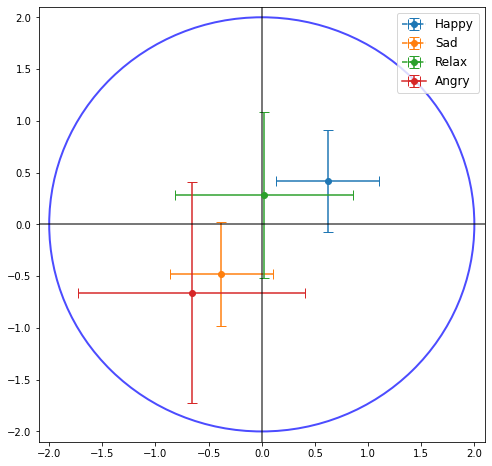

In [6]:
circle2 = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, alpha=0.7)

fig, ax = plt.subplots(figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

plt.errorbar(mean_states_1[0], mean_states_1[1], 
             xerr=std_states_1[0], yerr=std_states_1[1], 
             marker='o', capsize=5, linestyle="--", label="Happy")

plt.errorbar(mean_states_2[0], mean_states_2[1], 
             xerr=std_states_2[0], yerr=std_states_2[1], 
             marker='o', capsize=5, linestyle="--", label="Sad")

plt.errorbar(mean_states_3[0], mean_states_3[1], 
             xerr=std_states_3[0], yerr=std_states_3[1], 
             marker='o', capsize=5, linestyle="--", label="Relax")

plt.errorbar(mean_states_4[0], mean_states_4[1], 
             xerr=std_states_4[0], yerr=std_states_4[1], 
             marker='o', capsize=5, label="Angry")

ax.add_patch(circle2)

plt.axvline(0, c="black", alpha=0.7)
plt.axhline(0, c="black", alpha=0.7)

plt.legend(fontsize=12)

plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)

plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.